# Libraries Used

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import lightgbm as lgb
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import pacf
from sklearn.model_selection import RandomizedSearchCV

# How can a meal delivery service improve operations?

## 📖 Background
Your client is a food company in India that provides meal delivery services to thousands of customers per week. They operate in 51 cities inside eight different regions of the country. To better serve their customers, they deliver meals from 77 fulfillment centers.

The company wants you to help them understand their customer base, meal preferences, and fluctuations in orders. They want to investigate ways to improve operations and reduce food waste.

## 💾 The data

Your client has provided you with almost three years of order information for each of their 77 fulfillment centers:

- "week" - week (1 - 145)
- "center_id" - id of the fulfillment center
- "city_code" - city identifier
- "region_code" - region identifier
- "center_type" - there are three types of centers: A, B, and C
- "op_area" - the size of the area serviced by the fulfillment center
- "meal_id" - each meal has a unique id
- "category" - food category (beverages, pasta, rice, etc.)
- "cuisine" - the type of cuisine for each meal
- "checkout_price" - the price the customer pays (including discounts, promotions, etc.)
- "base_price" - list price for the meal
- "emailer" - 1 if there was an email promotion for the meal, 0 otherwise
- "featured" - 1 if the website featured the meal, 0 otherwise
- "orders" - number of orders for that week for that meal id

In [3]:
import pandas as pd
deliveries = pd.read_csv('meal_deliveries.csv').sort_values(by='week')
deliveries

id  week  center_id  city_code  region_code center_type  op_area  \
114136  1276995     1         77        676           34           A      3.8   
96763   1478891     1         72        638           56           C      3.9   
189605  1275693     1        132        522           56           A      3.9   
96636   1325813     1         74        702           35           A      2.8   
189711  1291713     1         72        638           56           C      3.9   
...         ...   ...        ...        ...          ...         ...      ...   
51485   1450815   145        108        579           56           B      4.4   
34154   1427022   145         11        679           56           A      3.7   
42025   1005716   145         94        632           34           C      3.6   
196464  1131679   145         89        703           56           A      4.8   
162455  1339028   145         43        590           56           A      5.1   

        meal_id      category      cuisine  checkout_price  base_price  \
114136     2306         Pasta      Italian          244.50      339.53   
96763      1885     Beverages         Thai          133.86      134.86   
189605     2139     Beverages       Indian          339.50      436.53   
96636      1962         Pizza  Continental          589.82      612.13   
189711     2760  Other Snacks         Thai          241.53      231.83   
...         ...           ...          ...             ...         ...   
51485      2581         Pizza  Continental          563.60      563.60   
34154      2139     Beverages       Indian          288.12      289.12   
42025      2707     Beverages      Italian          205.64      207.64   
196464     2104          Fish  Continental          640.23      639.23   
162455     1438          Soup         Thai          196.00      195.00   

        emailer  featured  orders  
114136        0         0      26  
96763         0         1     769  
189605        0         0      69  
96636         1         0      81  
189711        0         1      40  
...         ...       ...     ...  
51485         0         0     271  
34154         0         0     122  
42025         0         0     285  
196464        0         0      42  
162455        0         0     162  

[228274 rows x 15 columns]

## 💪 Competition challenge

Create a report that covers the following:
1. What are the most popular food categories in each region?
2. For each of the two cities with more than three fulfillment centers, would you recommend:
	* Keeping the number of centers the same,
	* Combine fulfillment centers, or
	* Opening new centers
3. Investigate the effectiveness of email campaigns and promoting meals on the website.
4. Explore ways of forecasting food order numbers to assist purchasing managers in their planning.

# Catatan

1. Objective function Order = x * MaxOrder per Center Type/Region/City per Cuisine/Category/Meal ID
2. Decision Variable = x
3. Constraint = Order Forecast

4. Cari tau berapa kapasitas maks order tiap center_type

# Data Cleaning

## Identifying Missing Values

In [4]:
round(deliveries.isna().sum()/len(deliveries)*100,2)

id                0.0
week              0.0
center_id         0.0
city_code         0.0
region_code       0.0
center_type       0.0
op_area           0.0
meal_id           0.0
category          0.0
cuisine           0.0
checkout_price    0.0
base_price        0.0
emailer           0.0
featured          0.0
orders            0.0
dtype: float64

No missing values detected

## Identifying Duplicates

In [5]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228274 entries, 114136 to 162455
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              228274 non-null  int64  
 1   week            228274 non-null  int64  
 2   center_id       228274 non-null  int64  
 3   city_code       228274 non-null  int64  
 4   region_code     228274 non-null  int64  
 5   center_type     228274 non-null  object 
 6   op_area         228274 non-null  float64
 7   meal_id         228274 non-null  int64  
 8   category        228274 non-null  object 
 9   cuisine         228274 non-null  object 
 10  checkout_price  228274 non-null  float64
 11  base_price      228274 non-null  float64
 12  emailer         228274 non-null  int64  
 13  featured        228274 non-null  int64  
 14  orders          228274 non-null  int64  
dtypes: float64(3), int64(9), object(3)
memory usage: 27.9+ MB


In [6]:
deliveries.duplicated().sum()

0

In [7]:
deliveries.duplicated(subset=('id')).sum()

0

In [8]:
deliveries.duplicated(subset=['center_id', 'meal_id', 'week']).sum()

0

No duplicates identified

## Changing Data Type

In [9]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228274 entries, 114136 to 162455
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              228274 non-null  int64  
 1   week            228274 non-null  int64  
 2   center_id       228274 non-null  int64  
 3   city_code       228274 non-null  int64  
 4   region_code     228274 non-null  int64  
 5   center_type     228274 non-null  object 
 6   op_area         228274 non-null  float64
 7   meal_id         228274 non-null  int64  
 8   category        228274 non-null  object 
 9   cuisine         228274 non-null  object 
 10  checkout_price  228274 non-null  float64
 11  base_price      228274 non-null  float64
 12  emailer         228274 non-null  int64  
 13  featured        228274 non-null  int64  
 14  orders          228274 non-null  int64  
dtypes: float64(3), int64(9), object(3)
memory usage: 27.9+ MB


All columns data type are workable

## Correcting Weird Value

In [10]:
col = list(set(deliveries.select_dtypes(include=['object', 'int64']).columns.to_list()) - set(['id','orders', 'week']))
for i in col:
  print(f'========{i}: {deliveries[i].nunique()} unique values========')
  print(deliveries[i].value_counts(), '\n')

========center_id: 77 unique values========
center_id
13     3551
10     3529
52     3518
43     3502
27     3501
       ... 
139    2270
57     2238
162    2173
41     2029
91     1734
Name: count, Length: 77, dtype: int64 

========city_code: 51 unique values========
city_code
590    27497
526    21686
638    10019
522     6644
517     6635
604     6561
699     6039
647     5911
576     5804
676     5617
614     5614
593     5384
685     3518
713     3501
700     3469
579     3431
679     3343
456     3335
703     3288
698     3274
577     3171
596     3168
659     3134
599     3113
654     3052
602     3014
473     3005
648     3005
615     2985
556     2983
628     2976
562     2950
461     2890
651     2890
485     2877
620     2869
561     2868
609     2846
675     2820
649     2804
658     2783
553     2754
695     2674
632     2659
680     2655
702     2653
683     2633
515     2524
478     2441
693     2270
541     2238
Name: count, dtype: int64 

========cuisine: 4 unique val

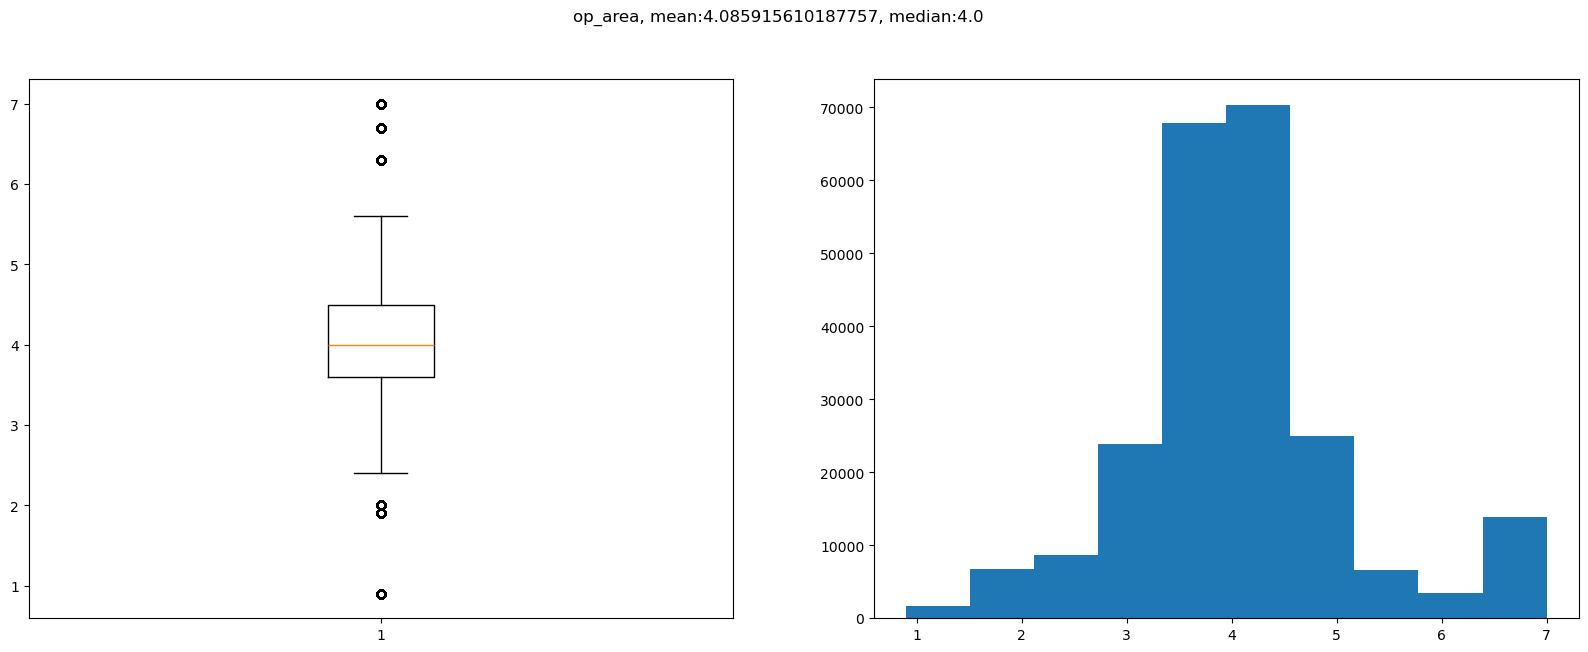

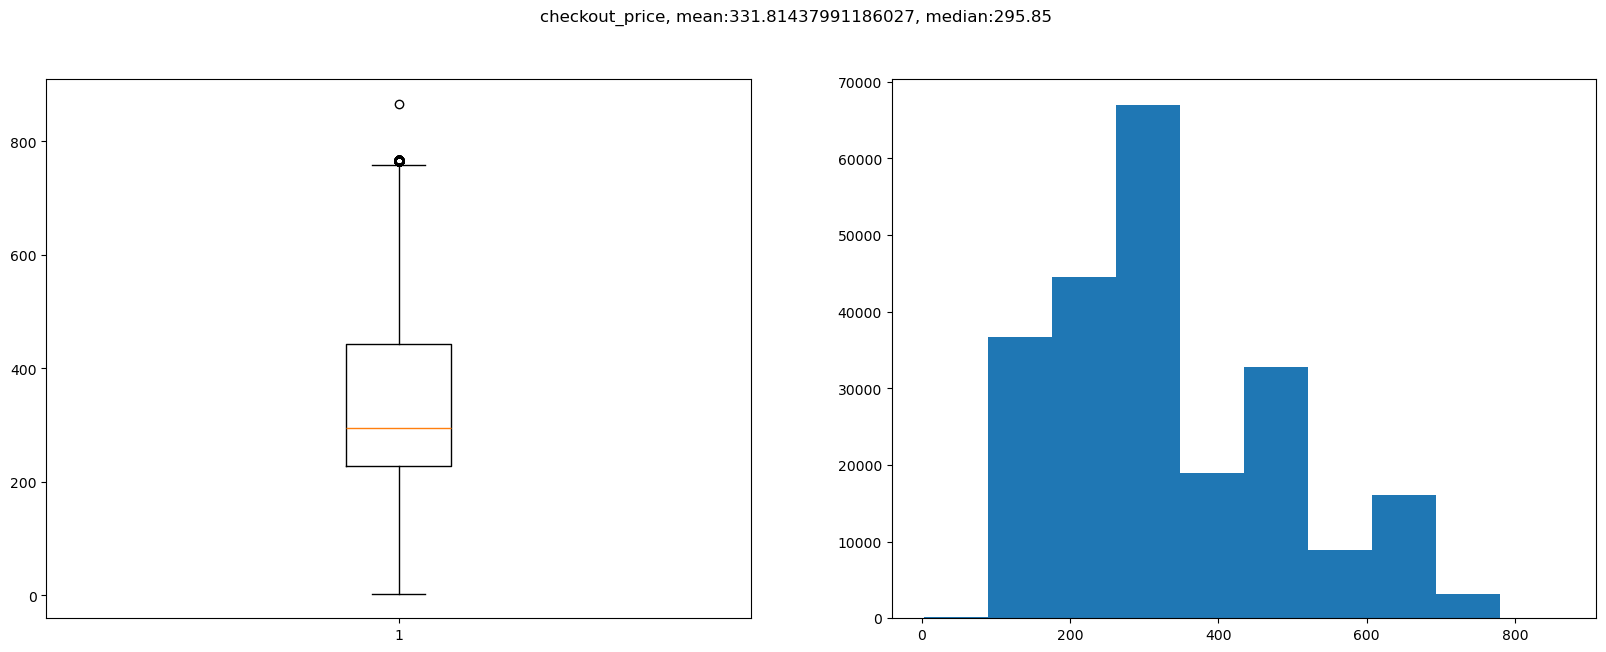

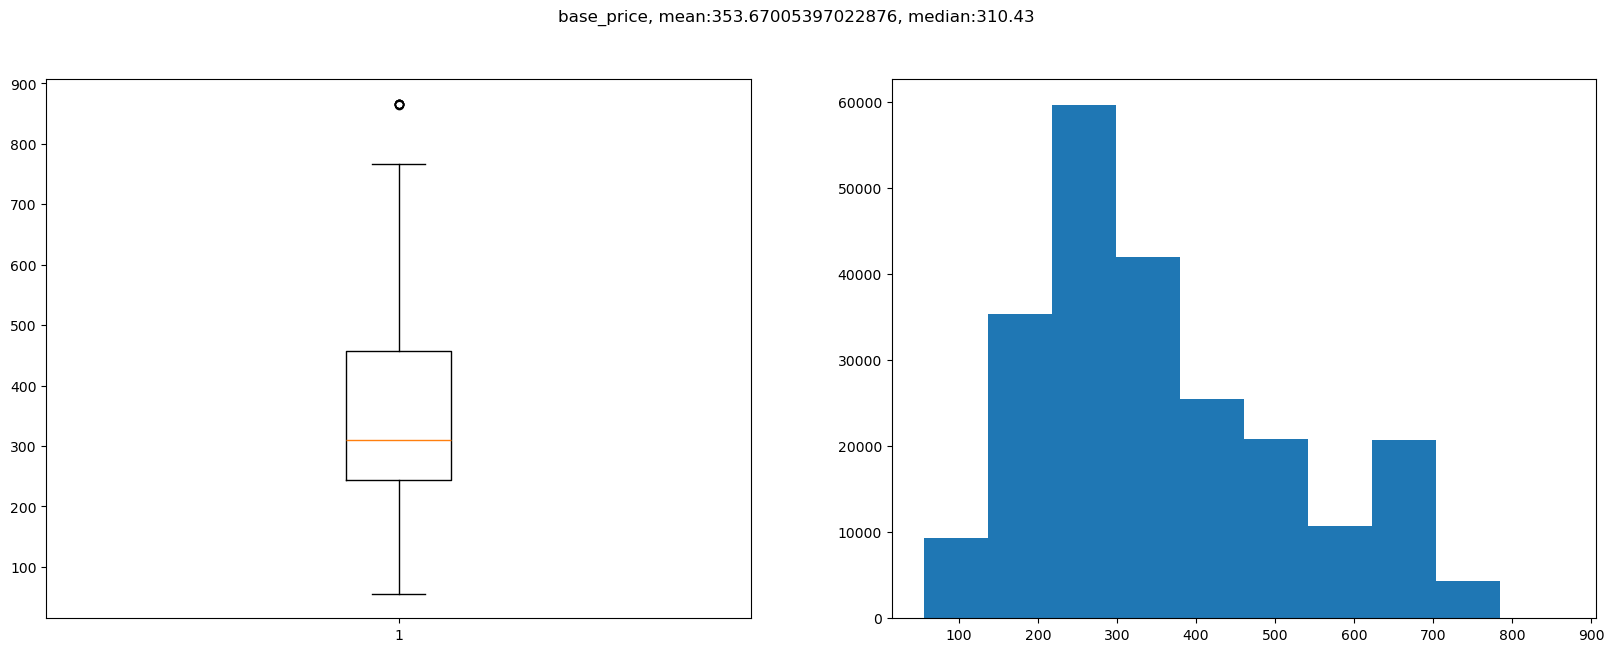

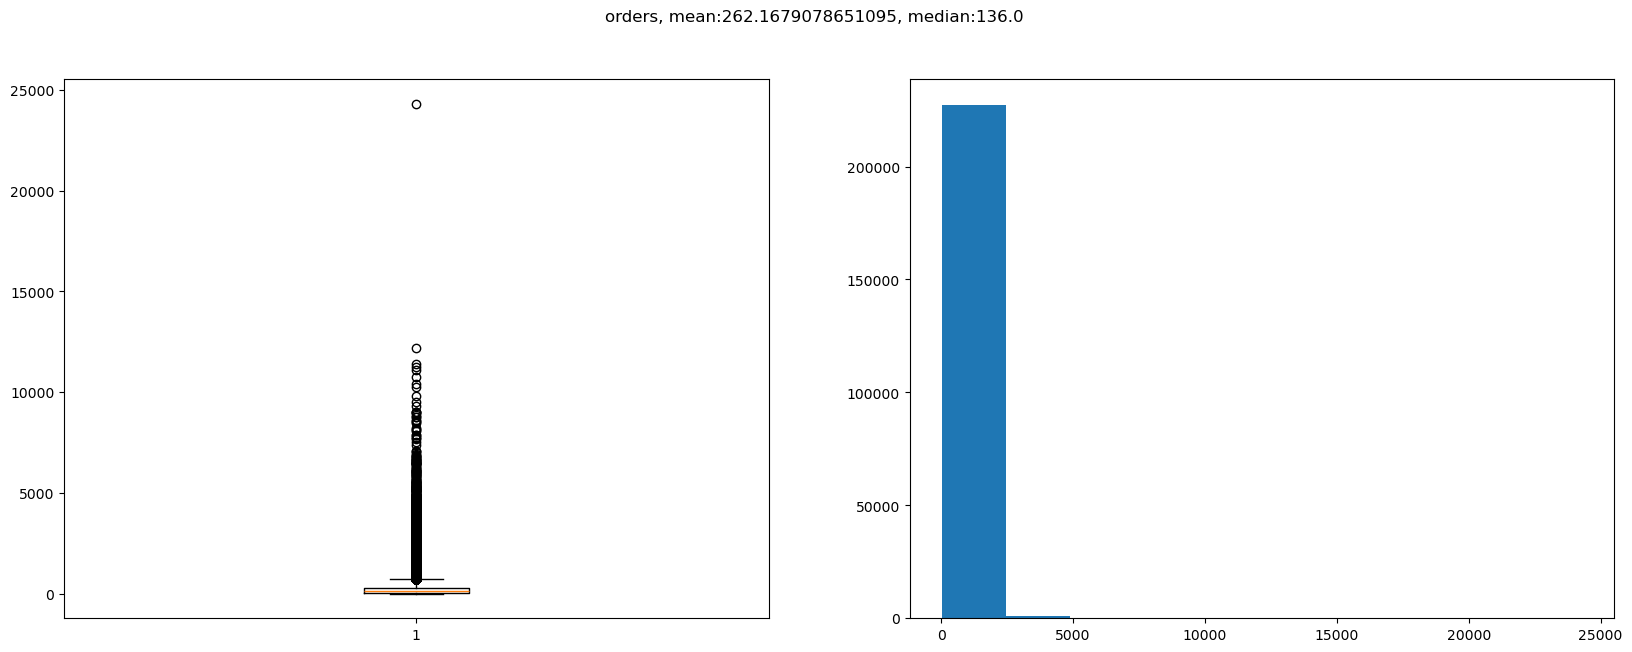

In [11]:
num_col = list(deliveries.select_dtypes('float64').columns)
num_col.append('orders')

for i in num_col:
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
  ax[0].boxplot(deliveries[i])

  ax[1].hist(deliveries[i])

  fig.suptitle(f'{i}, mean:{deliveries[i].mean()}, median:{deliveries[i].median()}')
  print('\n')
  plt.show()

In [12]:
deliveries.query("orders > 10000").sort_values(by='orders', ascending=False)

id  week  center_id  city_code  region_code center_type  op_area  \
131872  1452474     5         43        590           56           A      5.1   
2879    1091831     5        137        590           56           A      4.4   
226428  1398441    30        126        577           56           A      2.7   
190170  1323375     5        104        647           56           A      4.5   
178207  1062364    70         43        590           56           A      5.1   
14528   1470093     5         13        590           56           B      6.7   
72136   1233579     5         52        685           56           B      5.6   
83577   1030363     5        108        579           56           B      4.4   

        meal_id   category  cuisine  checkout_price  base_price  emailer  \
131872     2290  Rice Bowl   Indian          159.08      311.43        1   
2879       2290  Rice Bowl   Indian          159.11      307.49        1   
226428     1754   Sandwich  Italian          144.56      279.36        1   
190170     2290  Rice Bowl   Indian          163.02      309.43        1   
178207     1754   Sandwich  Italian          192.12      279.42        1   
14528      2290  Rice Bowl   Indian          162.02      311.43        1   
72136      2290  Rice Bowl   Indian          157.14      310.43        1   
83577      2290  Rice Bowl   Indian          162.05      301.73        1   

        featured  orders  
131872         1   24299  
2879           1   12177  
226428         1   11380  
190170         1   11246  
178207         1   11110  
14528          1   10745  
72136          1   10435  
83577          1   10259

<Axes: xlabel='week', ylabel='orders'>

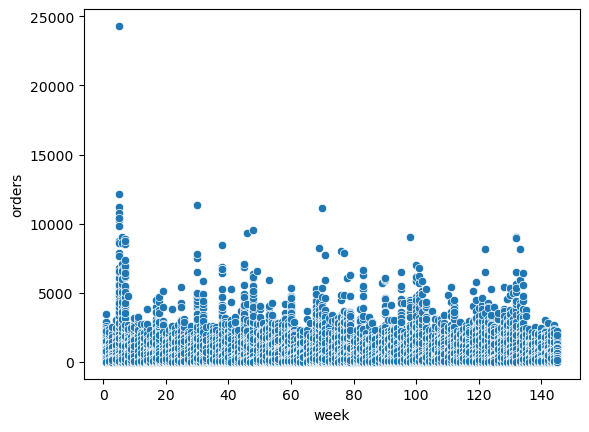

In [13]:
sns.scatterplot(data=deliveries, x='week', y='orders')

No weird values on object column. Hard to discern abnormal and deletable outlier on numeric column, although orders column has 1 very large value. Will investigate further in EDA section.

## Adding feature

In [14]:
deliveries['sales'] = deliveries['orders'] * deliveries['checkout_price']
deliveries['discount'] = (deliveries['checkout_price'] - deliveries['base_price'])/deliveries['base_price']*100

# EDA

## Descriptive Statistics and Univariate Analysis

In [15]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228274 entries, 114136 to 162455
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              228274 non-null  int64  
 1   week            228274 non-null  int64  
 2   center_id       228274 non-null  int64  
 3   city_code       228274 non-null  int64  
 4   region_code     228274 non-null  int64  
 5   center_type     228274 non-null  object 
 6   op_area         228274 non-null  float64
 7   meal_id         228274 non-null  int64  
 8   category        228274 non-null  object 
 9   cuisine         228274 non-null  object 
 10  checkout_price  228274 non-null  float64
 11  base_price      228274 non-null  float64
 12  emailer         228274 non-null  int64  
 13  featured        228274 non-null  int64  
 14  orders          228274 non-null  int64  
 15  sales           228274 non-null  float64
 16  discount        228274 non-null  float64
dtypes: float64

In [16]:
deliveries.select_dtypes('object').describe()

center_type   category  cuisine
count       228274     228274   228274
unique           3         14        4
top              A  Beverages  Italian
freq        131520      64152    61617

In [17]:
deliveries.select_dtypes('float64').describe().round(2)

op_area  checkout_price  base_price       sales   discount
count  228274.00       228274.00   228274.00   228274.00  228274.00
mean        4.09          331.81      353.67    69943.87      -5.70
std         1.09          152.65      160.47    88975.62      11.35
min         0.90            2.97       55.35       41.58     -99.06
25%         3.60          228.92      243.50    17329.90      -5.61
50%         4.00          295.85      310.43    41773.91      -0.14
75%         4.50          442.38      456.93    89831.70       0.15
max         7.00          866.27      866.27  3865484.92      72.79

In [18]:
deliveries[col].astype('str').describe().round(2)

center_id city_code  cuisine emailer region_code featured center_type  \
count     228274    228274   228274  228274      228274   228274      228274   
unique        77        51        4       2           8        2           3   
top           13       590  Italian       0          56        0           A   
freq        3551     27497    61617  209740       95620   203172      131520   

         category meal_id  
count      228274  228274  
unique         14      51  
top     Beverages    1062  
freq        64152    5640

In [19]:
print("{:,}".format(deliveries['sales'].sum().round(2)))

15,966,367,729.89


In [20]:
print("{:,}".format(deliveries['orders'].sum().round(2)))

59,846,117


In [21]:
print(deliveries['sales'].sum()/deliveries['orders'].sum())

266.7903705413335


In [22]:
deliveries['cuisine'].unique()

array(['Italian', 'Thai', 'Indian', 'Continental'], dtype=object)

In [23]:
deliveries['category'].unique()

array(['Pasta', 'Beverages', 'Pizza', 'Other Snacks', 'Rice Bowl',
       'Desert', 'Starters', 'Seafood', 'Soup', 'Sandwich', 'Extras',
       'Biryani', 'Salad', 'Fish'], dtype=object)

In [24]:
deliveries['meal_id'].nunique()

51

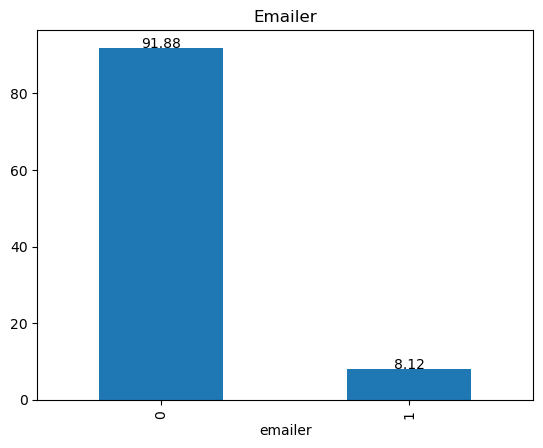

In [25]:
chart = deliveries['emailer'].value_counts(normalize=True)*100

chart.plot(kind='bar')
plt.title("Emailer")
for i in chart.index:
  plt.text(i, chart[i], round(chart[i],2), horizontalalignment='center')

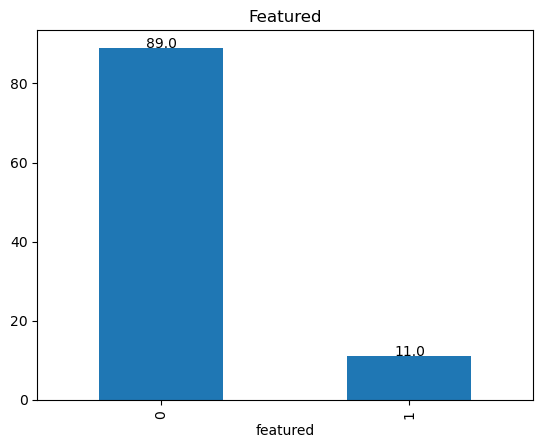

In [26]:
chart = deliveries['featured'].value_counts(normalize=True)*100

chart.plot(kind='bar')
plt.title("Featured")
for i in chart.index:
  plt.text(i, chart[i], round(chart[i],2), horizontalalignment='center')

## Popular food category per region

In [27]:
deliveries['category'].unique()

array(['Pasta', 'Beverages', 'Pizza', 'Other Snacks', 'Rice Bowl',
       'Desert', 'Starters', 'Seafood', 'Soup', 'Sandwich', 'Extras',
       'Biryani', 'Salad', 'Fish'], dtype=object)

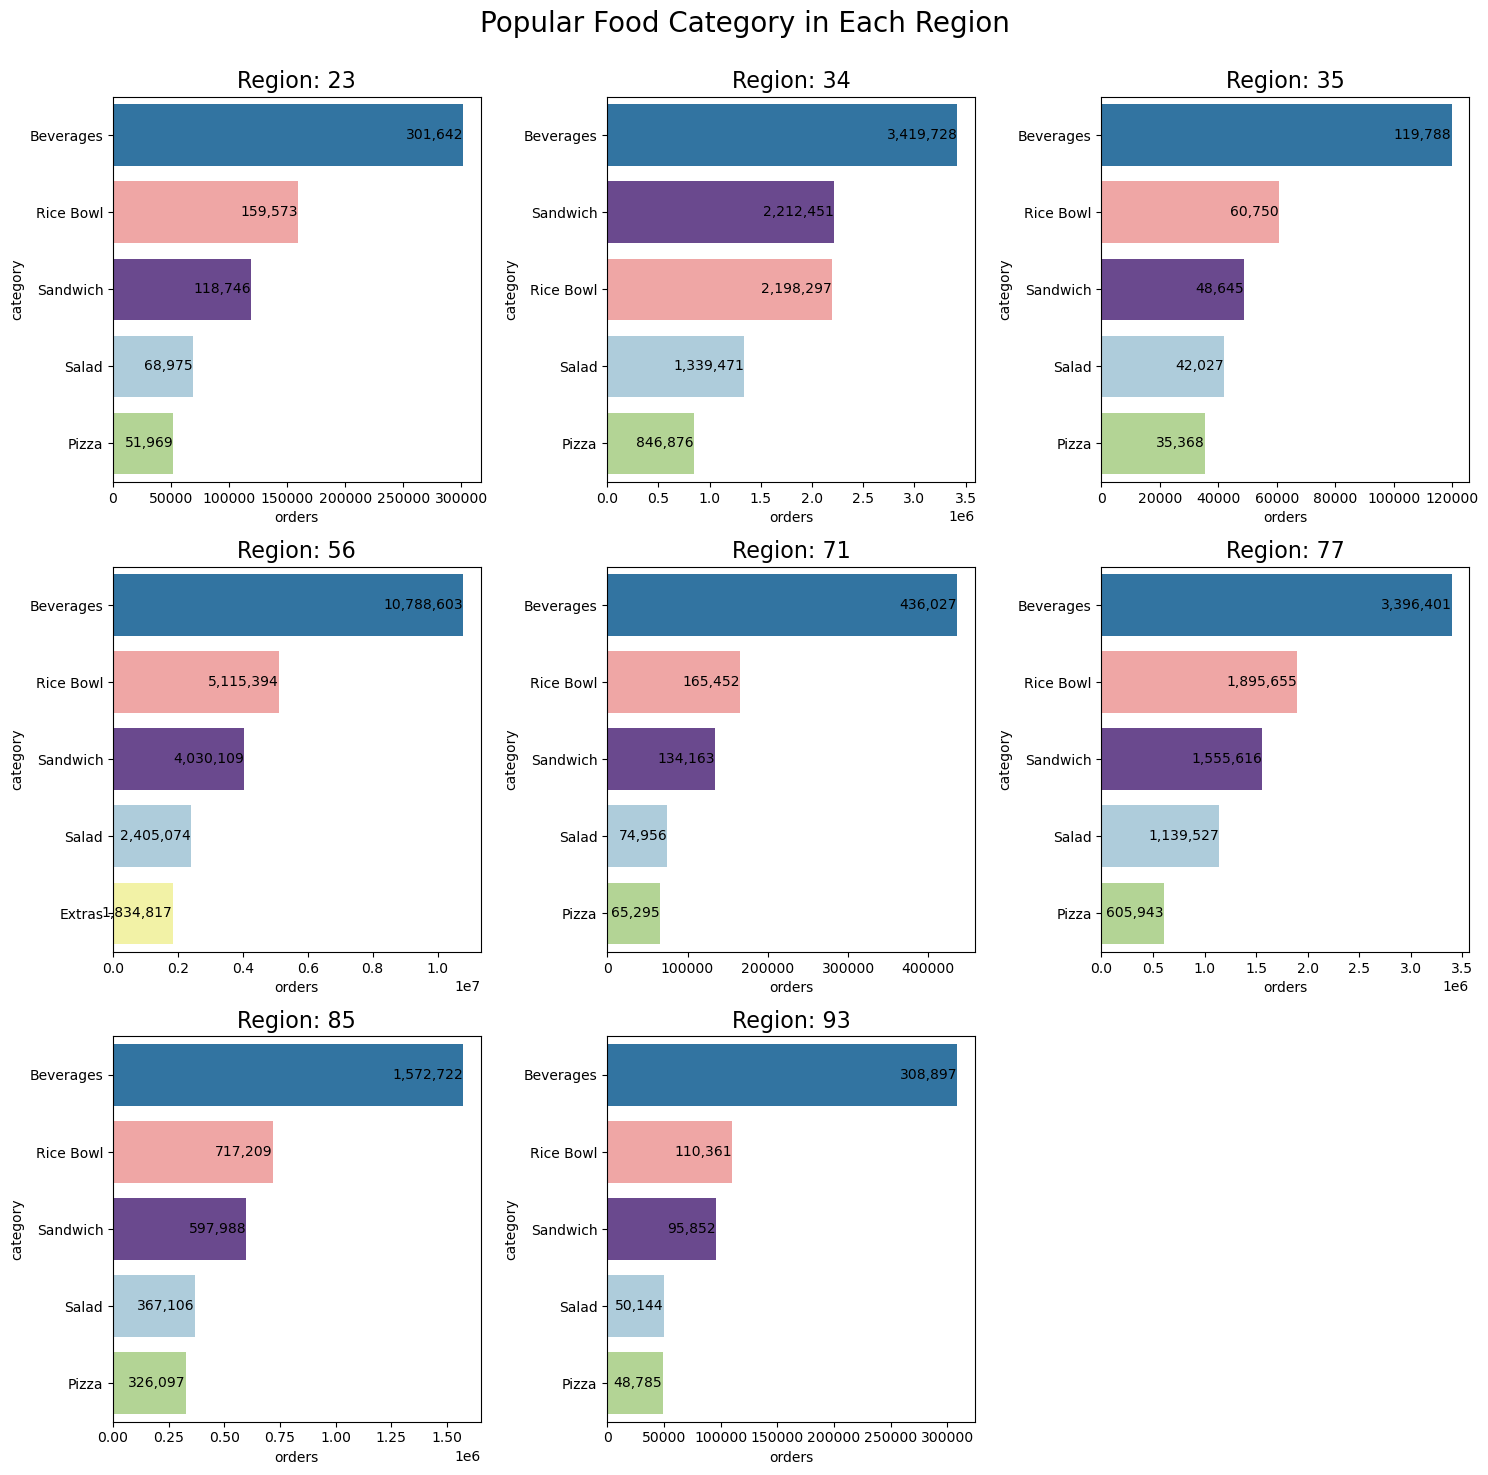

In [28]:
temp_df = deliveries.groupby(['region_code', 'category'],as_index=False).agg({'orders':'sum'})

food_categories = ['Pasta', 'Beverages', 'Pizza', 'Other Snacks', 'Rice Bowl', 
                   'Desert', 'Starters', 'Seafood', 'Soup', 'Sandwich', 
                   'Extras', 'Biryani', 'Salad', 'Fish']

palet = sns.color_palette('Paired', len(food_categories))
color_dict = dict(zip(food_categories, palet))

# Count the number of regions
num_regions = temp_df['region_code'].nunique()
num_cols = math.ceil(num_regions / 3)  # Ensure only 3 rows
fig, axes = plt.subplots(nrows=3, ncols=num_cols, figsize=(5*num_cols, 5*3))
axes = axes.flatten()  # Flatten the axes array to iterate easily

# Loop through each region and plot on the corresponding subplot
for idx, region in enumerate(temp_df['region_code'].unique()):
    temp_df_i = temp_df[temp_df['region_code'] == region].sort_values(by='orders', ascending=False).nlargest(n=5, columns='orders')
    
    ax = axes[idx]  # Select the correct subplot
    ax.set_title(f"Region: {region}", fontsize=16)
    
    barplot = sns.barplot(data=temp_df_i, x='orders', y='category', hue='category', ax=ax, palette=color_dict, dodge=False)
    
    # Add text labels inside the end of each bar
    for index, value in enumerate(temp_df_i['orders']):
        ax.text(value - 10, index, f'{value:,.0f}', color='black', ha="right", va='center')

# Remove any extra axes (if any)
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle("Popular Food Category in Each Region\n", fontsize=20)
plt.tight_layout()

# Save the figure as a PNG file
fig.savefig("Popular Food Category in Each Region.png", dpi=300, bbox_inches='tight')

plt.show()

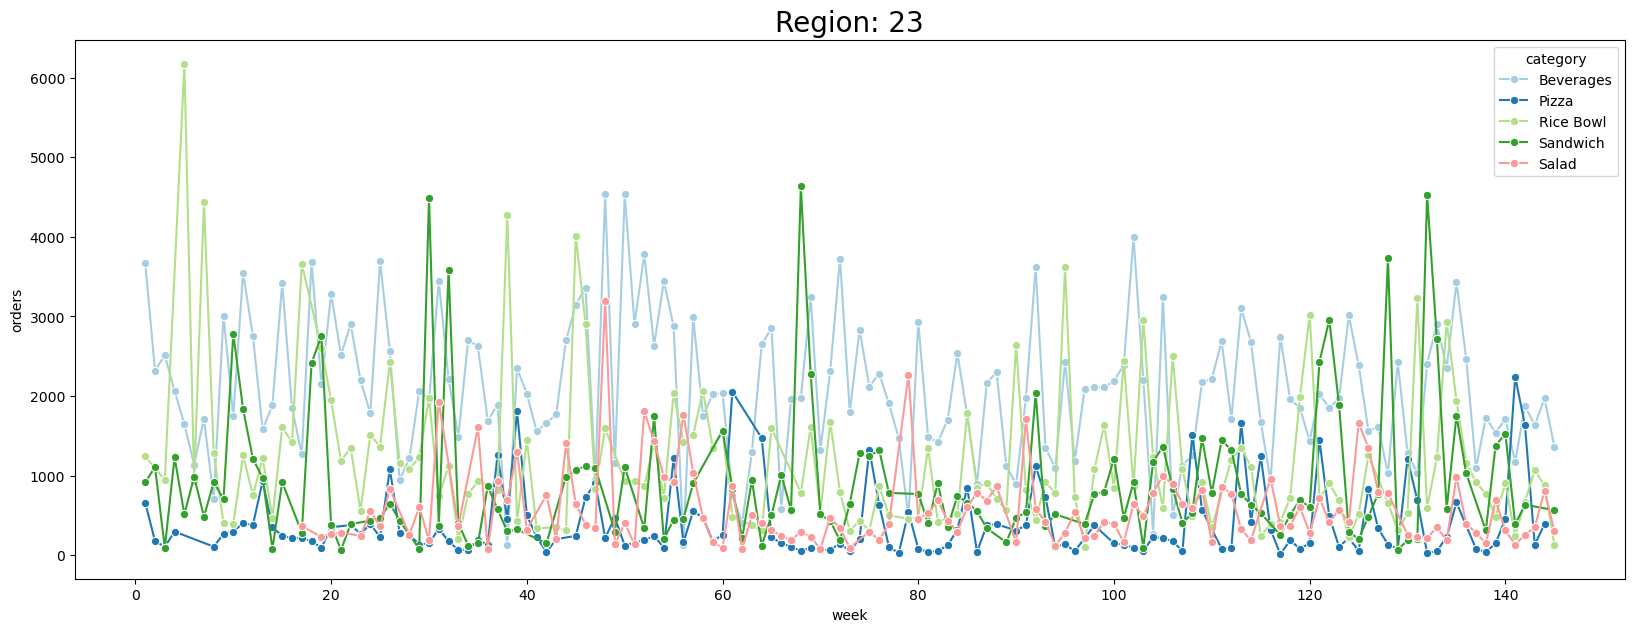

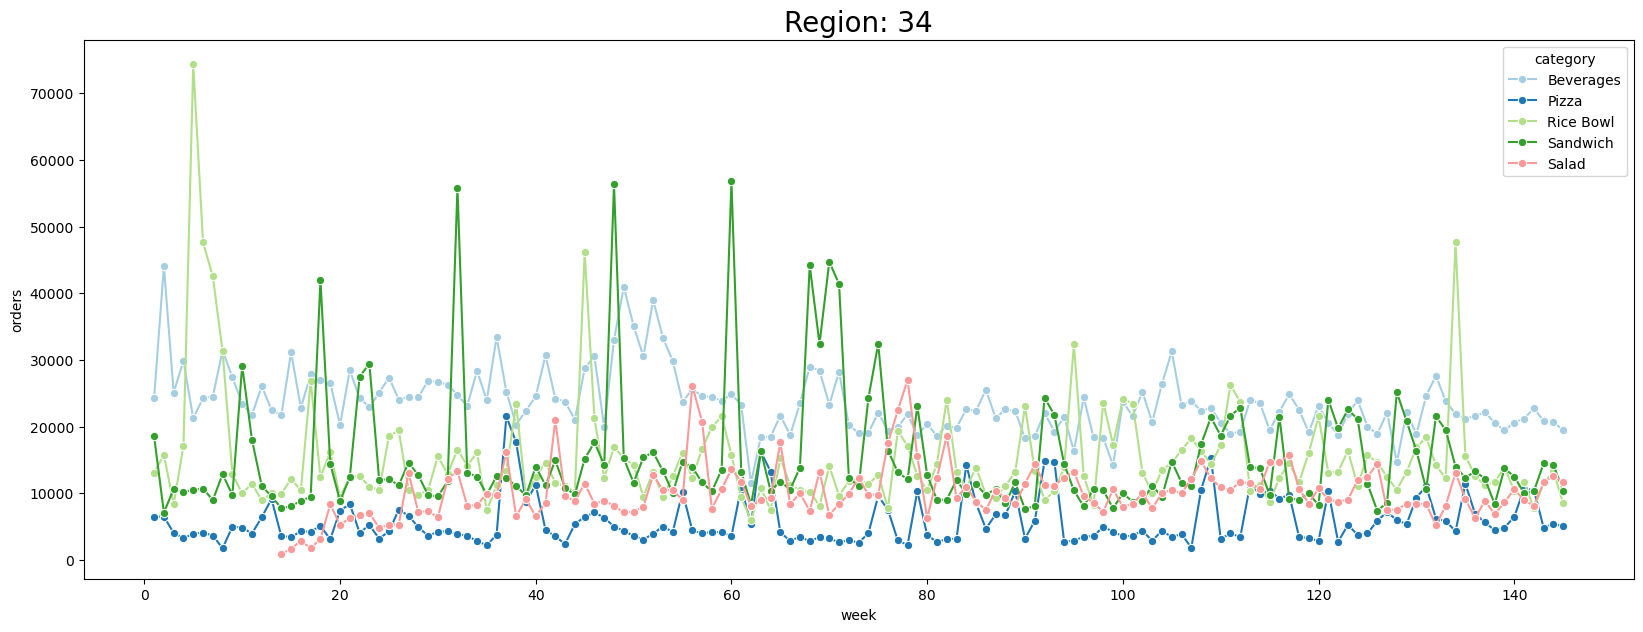

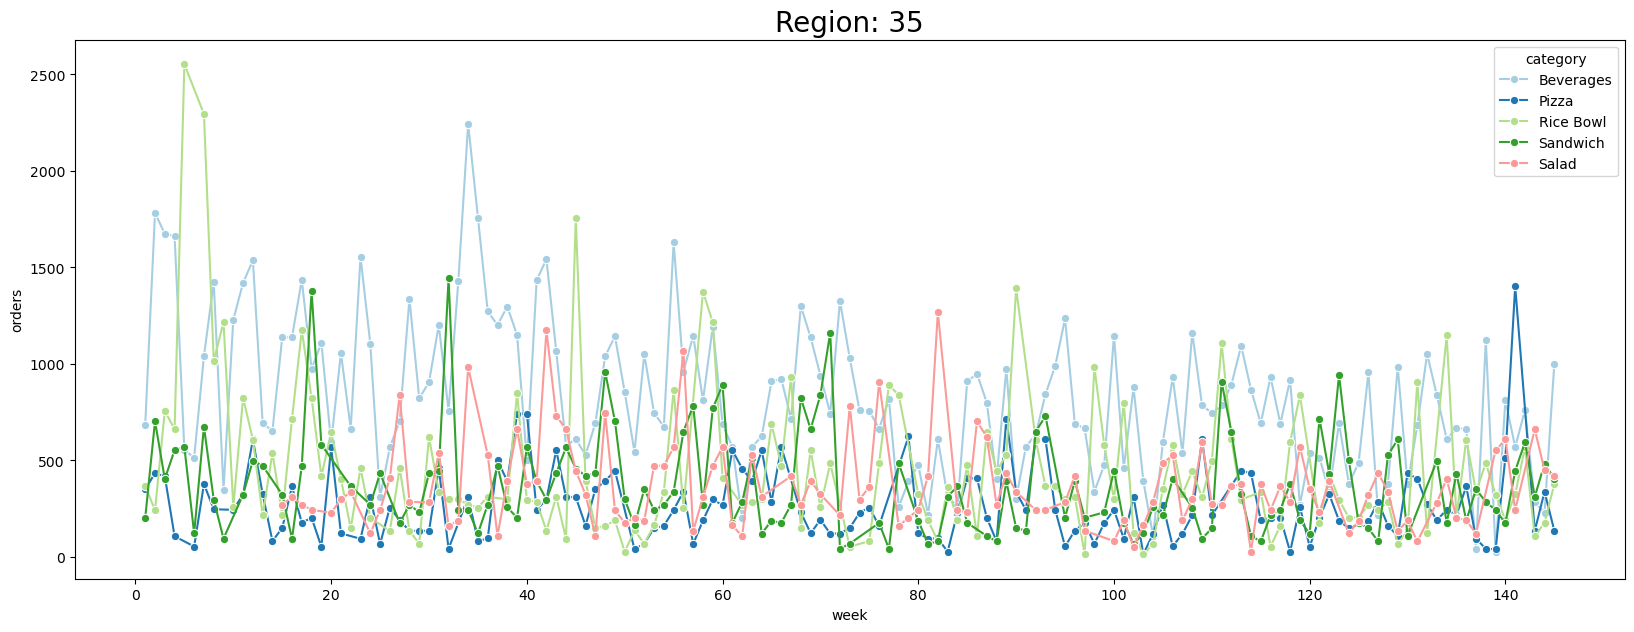

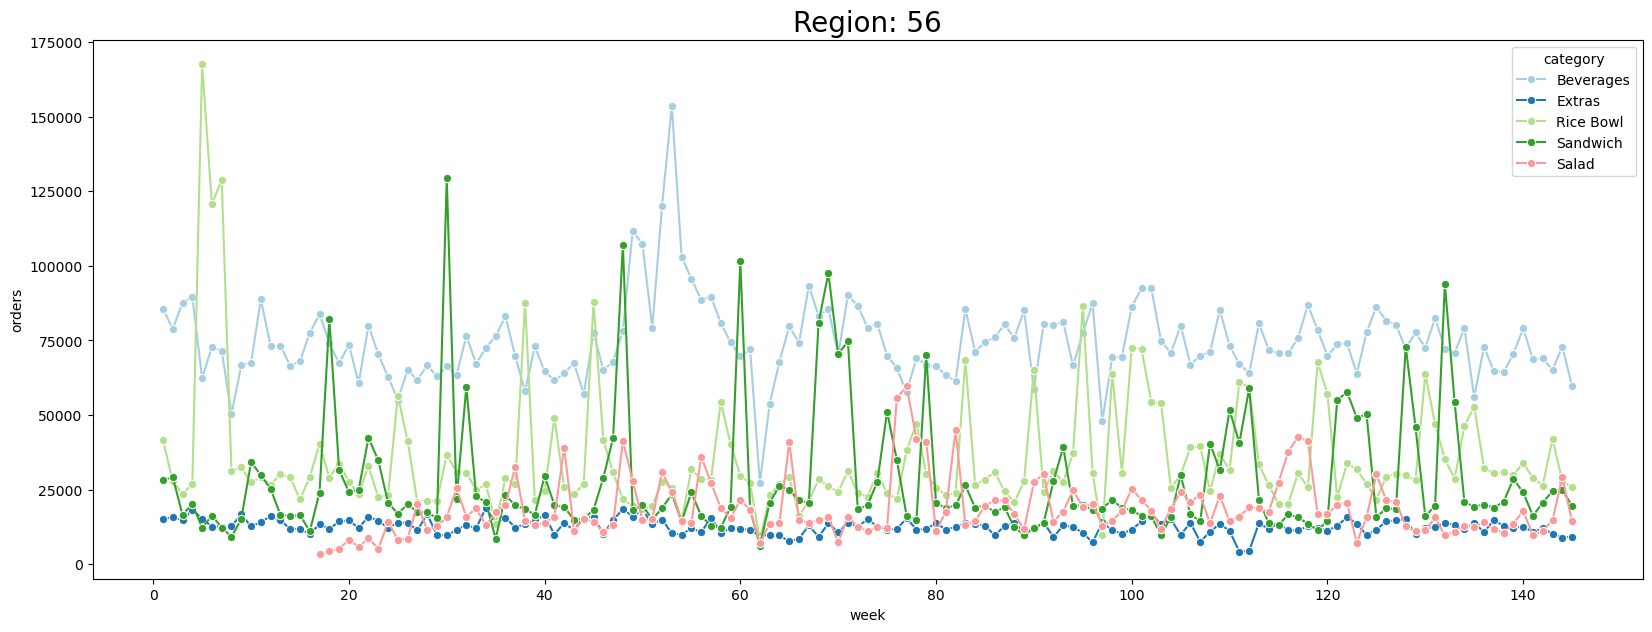

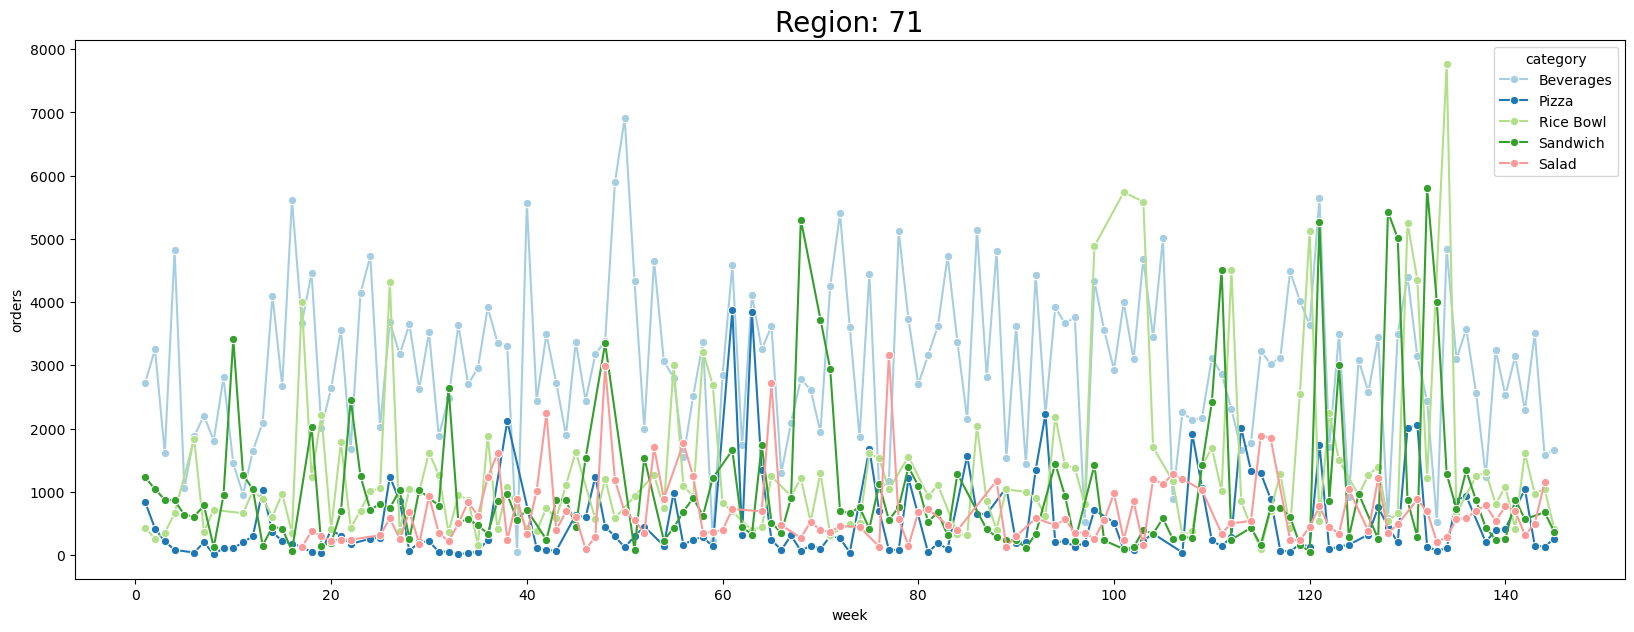

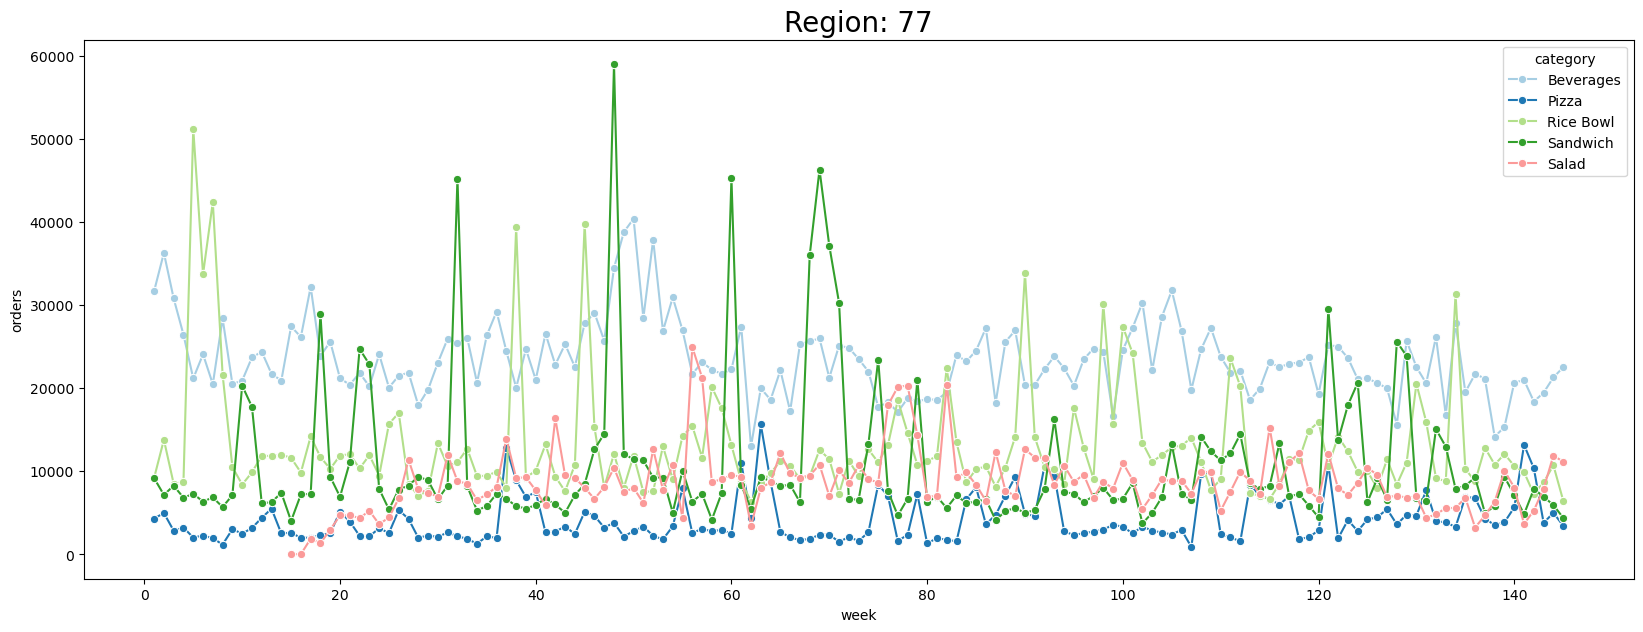

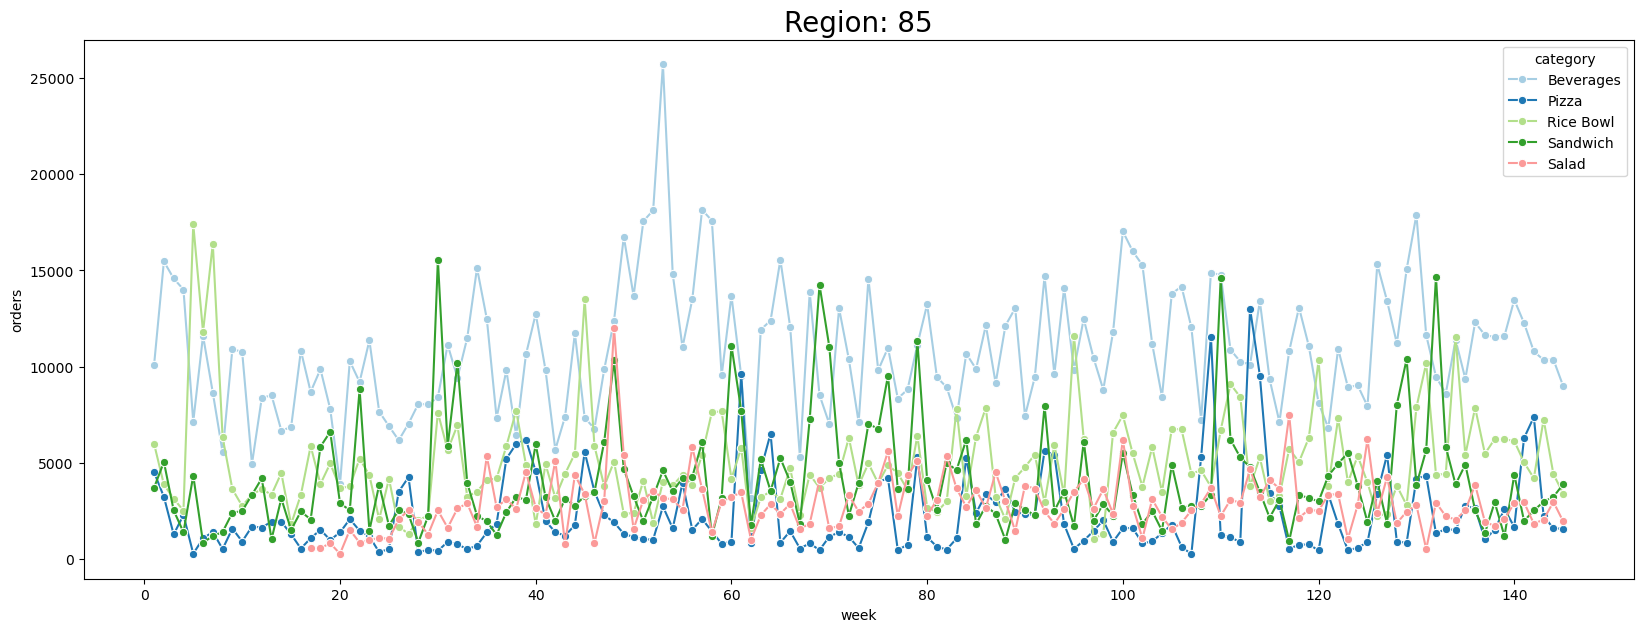

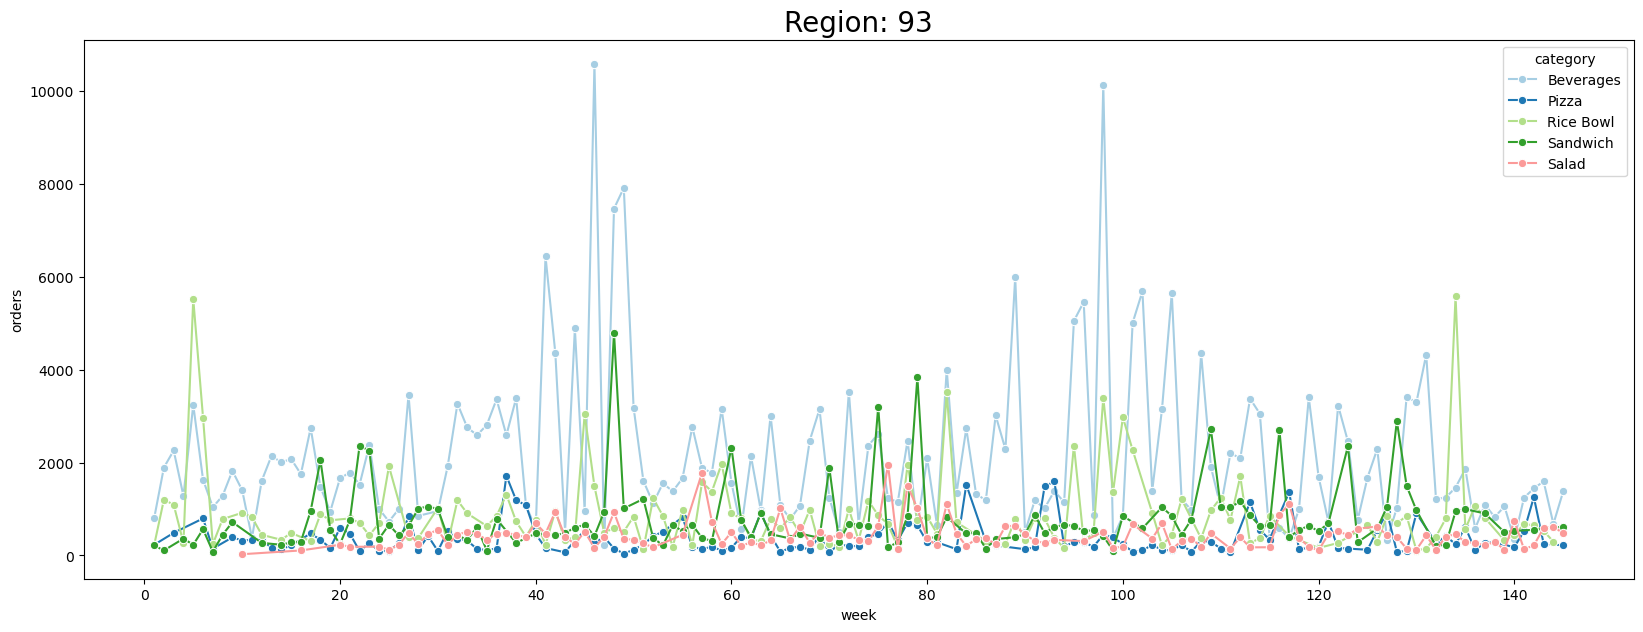

In [29]:
temp_df = deliveries.groupby(['week', 'region_code', 'category'],as_index=False).agg({'orders':'sum'})

for i in temp_df['region_code'].unique():
  temp_df_i = temp_df[temp_df['region_code']==i]
  top5 = temp_df_i.groupby('category', as_index=False).agg({'orders':'sum'}).nlargest(n=5, columns='orders')['category']

  temp_df_i = temp_df_i[temp_df_i['category'].isin(top5)]
  fig, ax = plt.subplots(figsize=(20,7))
  plt.title(f"Region: {i}", fontsize=20)
  sns.lineplot(data=temp_df_i, x='week', y='orders', hue='category', ax=ax, palette=palet[:5], marker='o')

  plt.show()

# Analysis of fulfillment center capacity

### Is there any characteristic difference between center_type A, B and C

In [30]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228274 entries, 114136 to 162455
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              228274 non-null  int64  
 1   week            228274 non-null  int64  
 2   center_id       228274 non-null  int64  
 3   city_code       228274 non-null  int64  
 4   region_code     228274 non-null  int64  
 5   center_type     228274 non-null  object 
 6   op_area         228274 non-null  float64
 7   meal_id         228274 non-null  int64  
 8   category        228274 non-null  object 
 9   cuisine         228274 non-null  object 
 10  checkout_price  228274 non-null  float64
 11  base_price      228274 non-null  float64
 12  emailer         228274 non-null  int64  
 13  featured        228274 non-null  int64  
 14  orders          228274 non-null  int64  
 15  sales           228274 non-null  float64
 16  discount        228274 non-null  float64
dtypes: float64

#### What is the average area handled by each center type?

In [31]:
area_cid = deliveries[['center_id', 'op_area']].sort_values(by='center_id')
area_cid

center_id  op_area
180769         10      6.3
75671          10      6.3
84162          10      6.3
108645         10      6.3
141376         10      6.3
...           ...      ...
156453        186      3.4
36126         186      3.4
206626        186      3.4
160115        186      3.4
124830        186      3.4

[228274 rows x 2 columns]

Each center_id has unique op_area

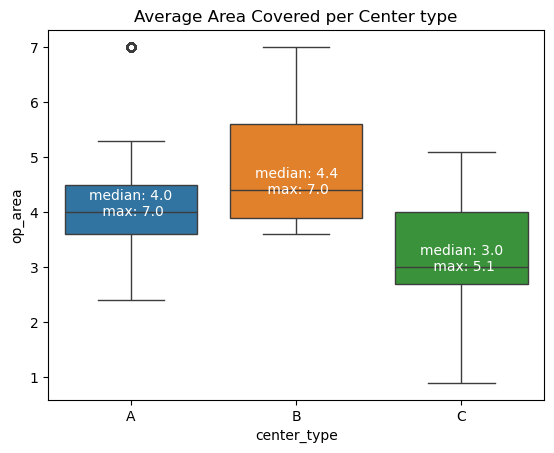

In [32]:
area_ctype = deliveries.groupby(['center_type', 'center_id', 'week'], as_index=False).agg({'op_area':'mean'}).sort_values(by='op_area', ascending=False)

sns.boxplot(data=area_ctype, y='op_area', x='center_type', hue='center_type',palette='tab10')

for i,v in enumerate(area_ctype['center_type'].unique()):
  y = area_ctype[area_ctype['center_type']==v]['op_area'].values
  plt.text(i, np.median(y),
           f'median: {round(np.median(y),2)}\n max: {np.max(y)}\n',
           horizontalalignment='center',
           verticalalignment='center',
           color='white',
           fontsize=10)

plt.title('Average Area Covered per Center type')
plt.show()

B: cover the largest area and medium order
A: cover the medium area and largest order
C: cover the lowest area and lowest order

#### Are there any difference cuisine or category by center_type?

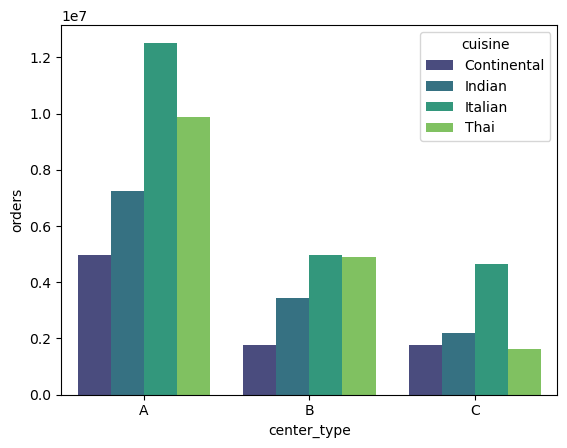

In [33]:
cuisine_ctype = deliveries.groupby(['center_type', 'cuisine'], as_index=False).agg({'orders':'sum'})

sns.barplot(data=cuisine_ctype, x='center_type', y='orders', hue='cuisine', palette='viridis')
plt.show()

No clear specialties for each center type

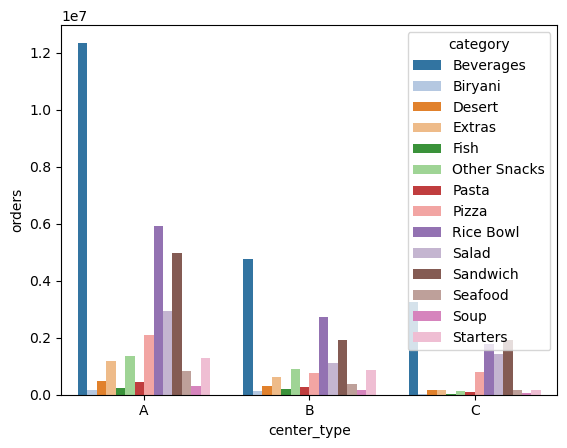

In [34]:
category_ctype = deliveries.groupby(['center_type', 'category'], as_index=False).agg({'orders':'sum'})

sns.barplot(data=category_ctype, x='center_type', y='orders', hue='category', palette='tab20')
plt.show()

### Which cities has > 3 fulfillment center

In [35]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228274 entries, 114136 to 162455
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              228274 non-null  int64  
 1   week            228274 non-null  int64  
 2   center_id       228274 non-null  int64  
 3   city_code       228274 non-null  int64  
 4   region_code     228274 non-null  int64  
 5   center_type     228274 non-null  object 
 6   op_area         228274 non-null  float64
 7   meal_id         228274 non-null  int64  
 8   category        228274 non-null  object 
 9   cuisine         228274 non-null  object 
 10  checkout_price  228274 non-null  float64
 11  base_price      228274 non-null  float64
 12  emailer         228274 non-null  int64  
 13  featured        228274 non-null  int64  
 14  orders          228274 non-null  int64  
 15  sales           228274 non-null  float64
 16  discount        228274 non-null  float64
dtypes: float64

In [36]:
city_fulfil = deliveries.groupby('city_code', as_index=False)\
                        .agg({'center_id':pd.Series.nunique})\
                        .rename(columns={'center_id':'center_count'})
                                                            
city_fulfil_3_up = city_fulfil[city_fulfil['center_count']>3]

city_fulfil_3_up

city_code  center_count
8         526             8
17        590             9

### What is the max of weekly order for each center type?

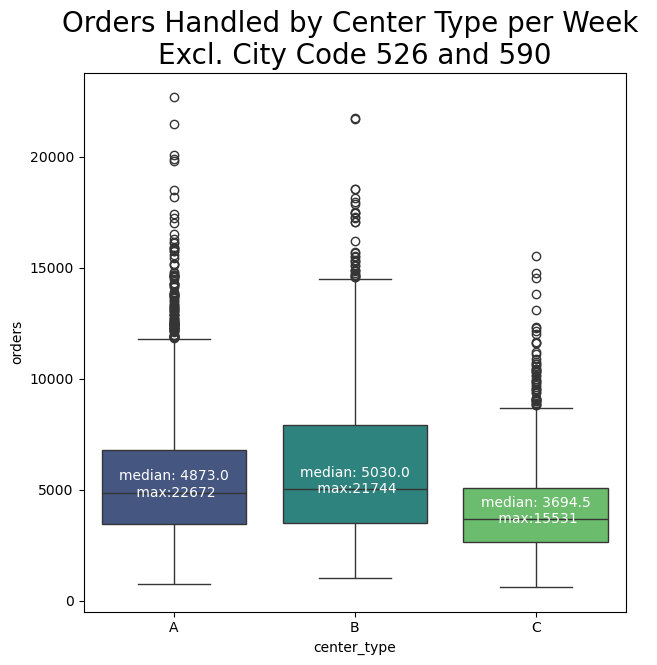

In [37]:
order_excl_526_590 = deliveries[~deliveries['city_code'].isin(city_fulfil_3_up['city_code'])]

order_ctype = order_excl_526_590.groupby(['center_type','center_id','week'], as_index=False).agg({'orders':'sum'})

fig, ax= plt.subplots(figsize=(7,7))
ax.set_title("Orders Handled by Center Type per Week \nExcl. City Code 526 and 590", fontsize=20)
sns.boxplot(data=order_ctype, x='center_type', y='orders', hue='center_type', palette='viridis', ax=ax)

for i,v in enumerate(order_ctype['center_type'].unique()):
  y = order_ctype[order_ctype['center_type']==v]['orders'].values
  plt.text(i, np.median(y),
           f'median: {round(np.median(y),2)}\n max:{np.max(y)}\n',
           horizontalalignment='center',
           verticalalignment='center',
           color='white',
           fontsize=10)
ax.grid(False)

plt.show()

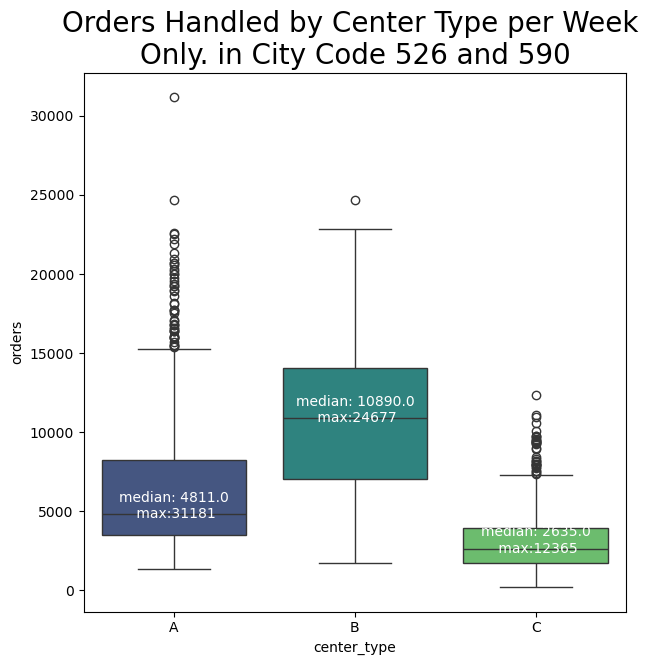

In [38]:
order_incl_526_590 = deliveries[deliveries['city_code'].isin(city_fulfil_3_up['city_code'])]

order_ctype = order_incl_526_590.groupby(['center_type','center_id','week'], as_index=False).agg({'orders':'sum'})

fig, ax= plt.subplots(figsize=(7,7))
ax.set_title("Orders Handled by Center Type per Week \nOnly. in City Code 526 and 590", fontsize=20)
sns.boxplot(data=order_ctype, x='center_type', y='orders', palette='viridis', ax=ax)

for i,v in enumerate(order_ctype['center_type'].unique()):
  y = order_ctype[order_ctype['center_type']==v]['orders'].values
  plt.text(i, np.median(y),
           f'median: {round(np.median(y),2)}\n max:{np.max(y)}\n',
           horizontalalignment='center',
           verticalalignment='center',
           color='white',
           fontsize=10)
ax.grid(False)

plt.show()

### Center Type A and B seems to be overburdened. In which city?

### Order Analysis Per City, Center Type and Center ID

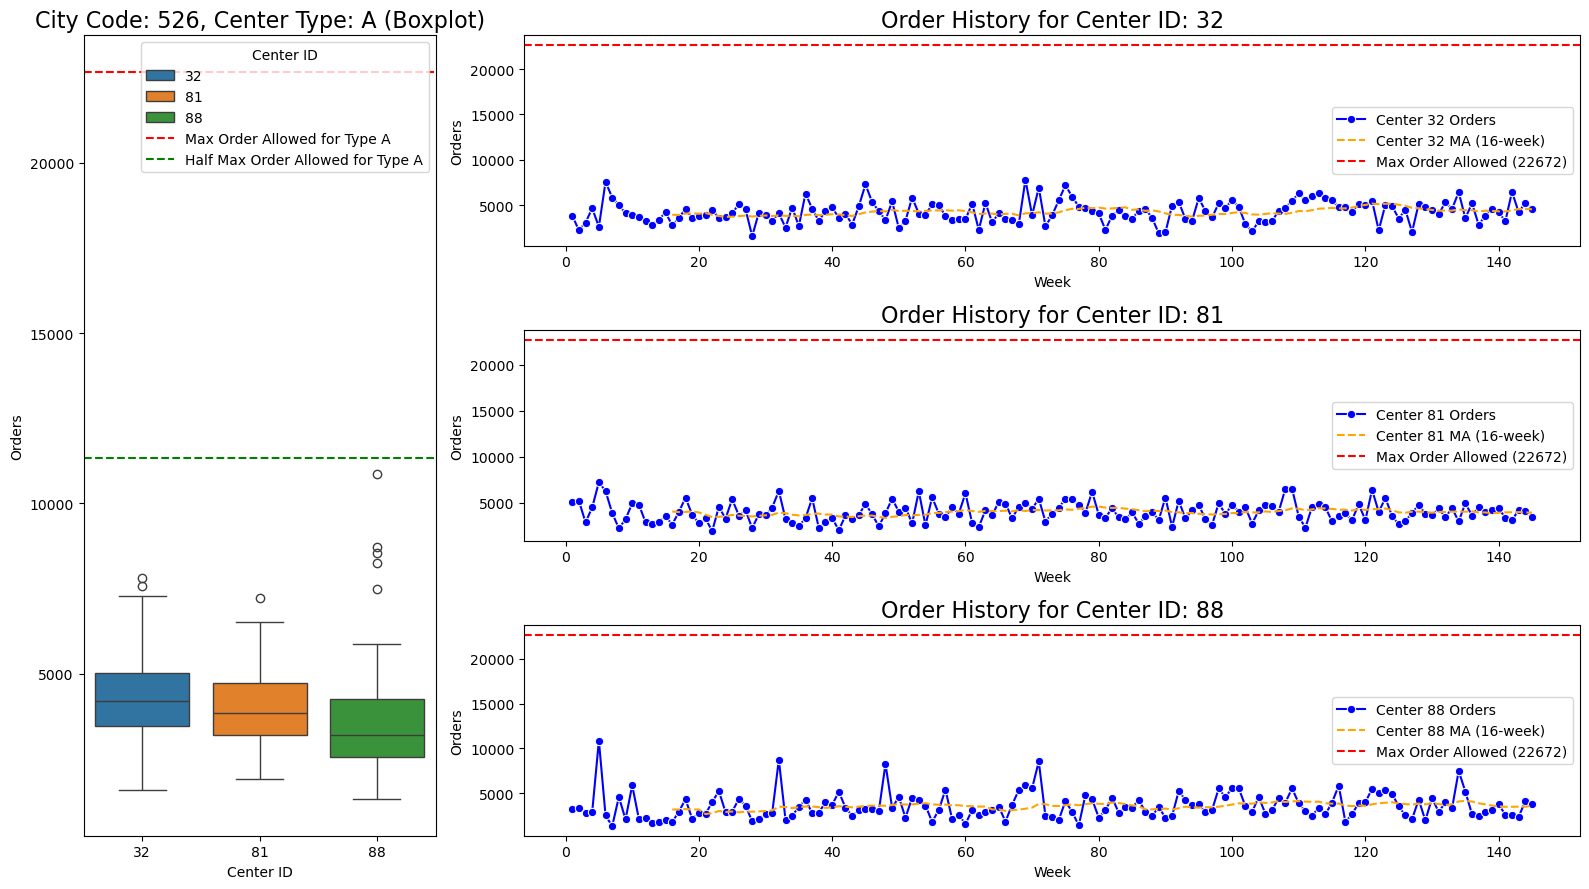

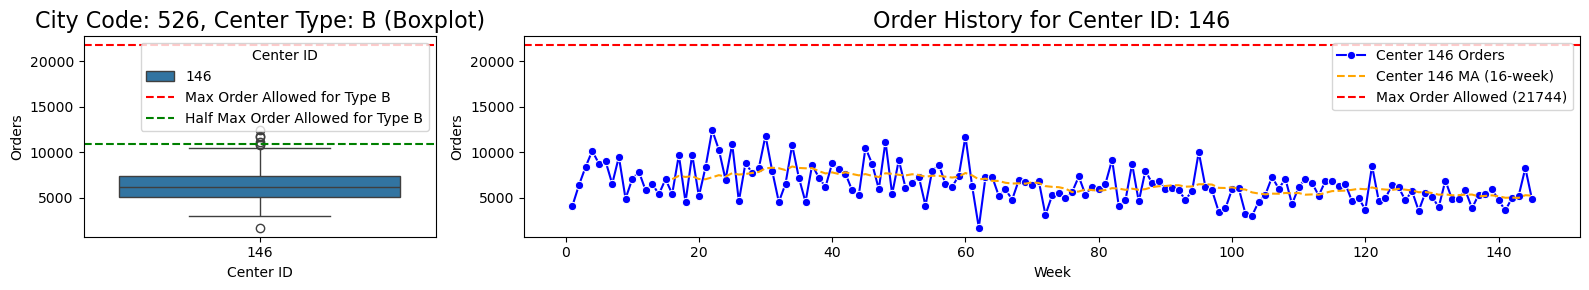

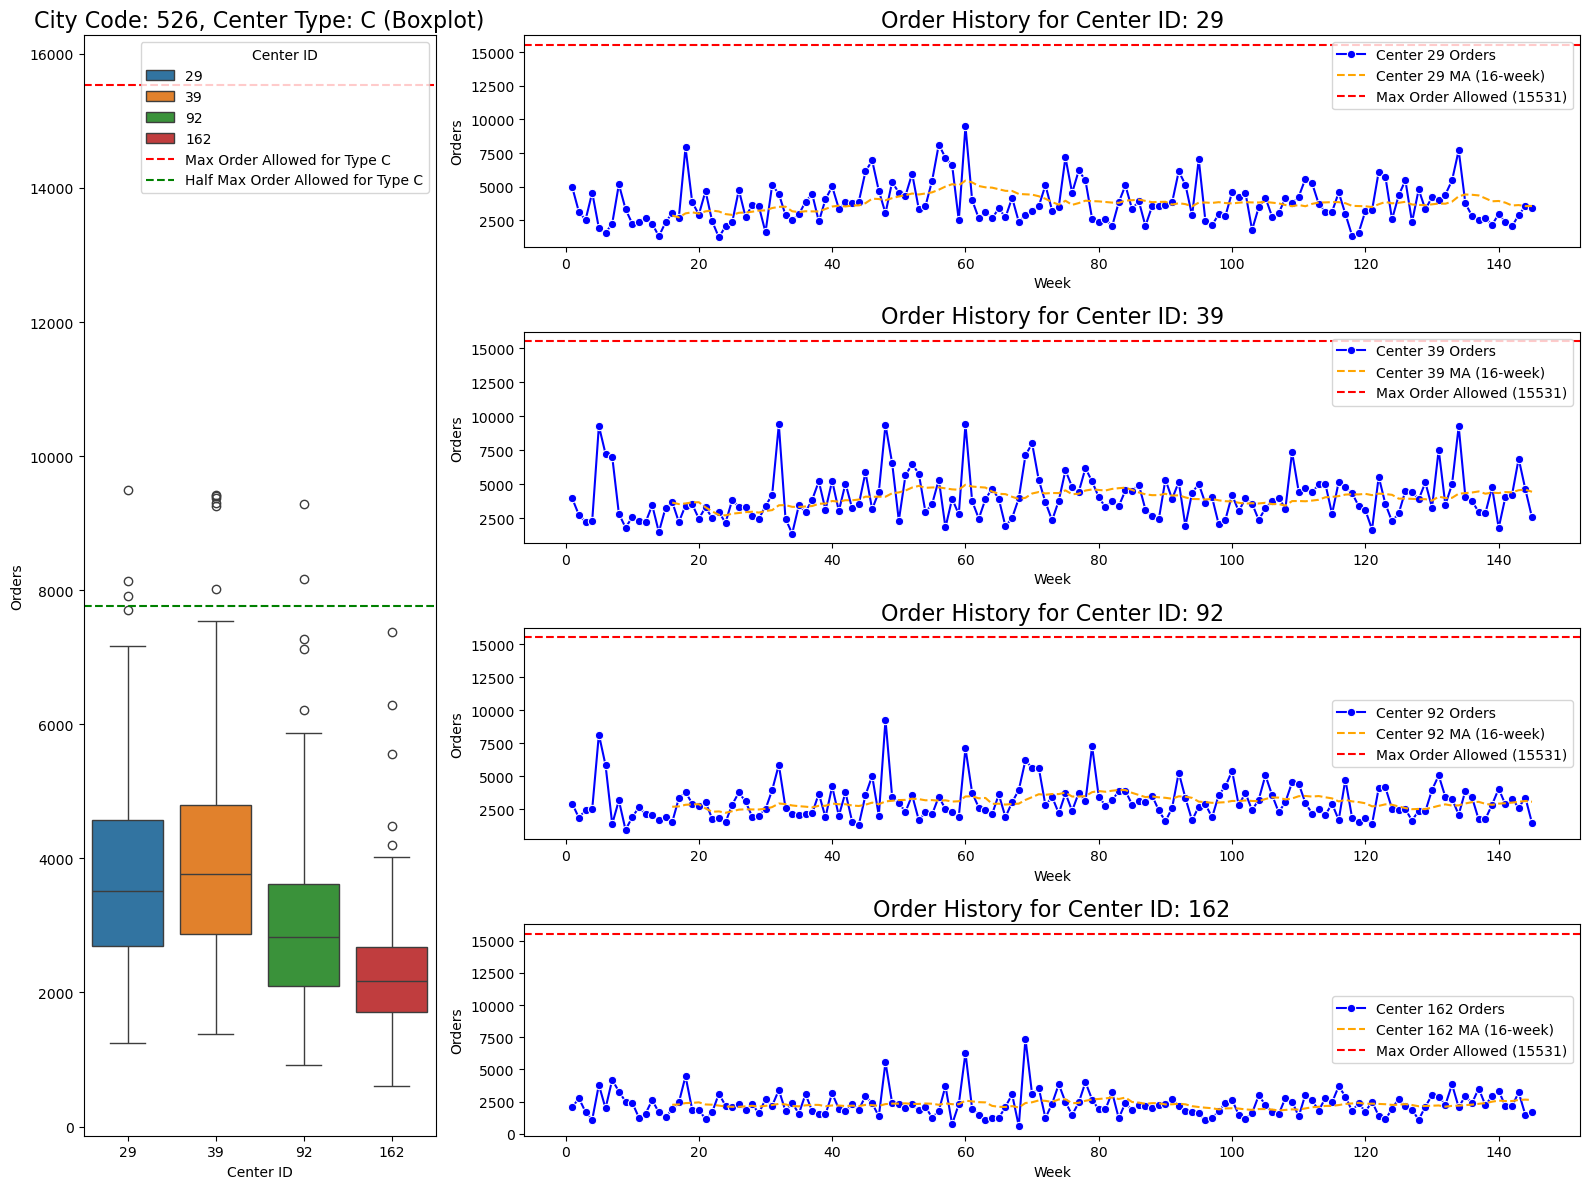

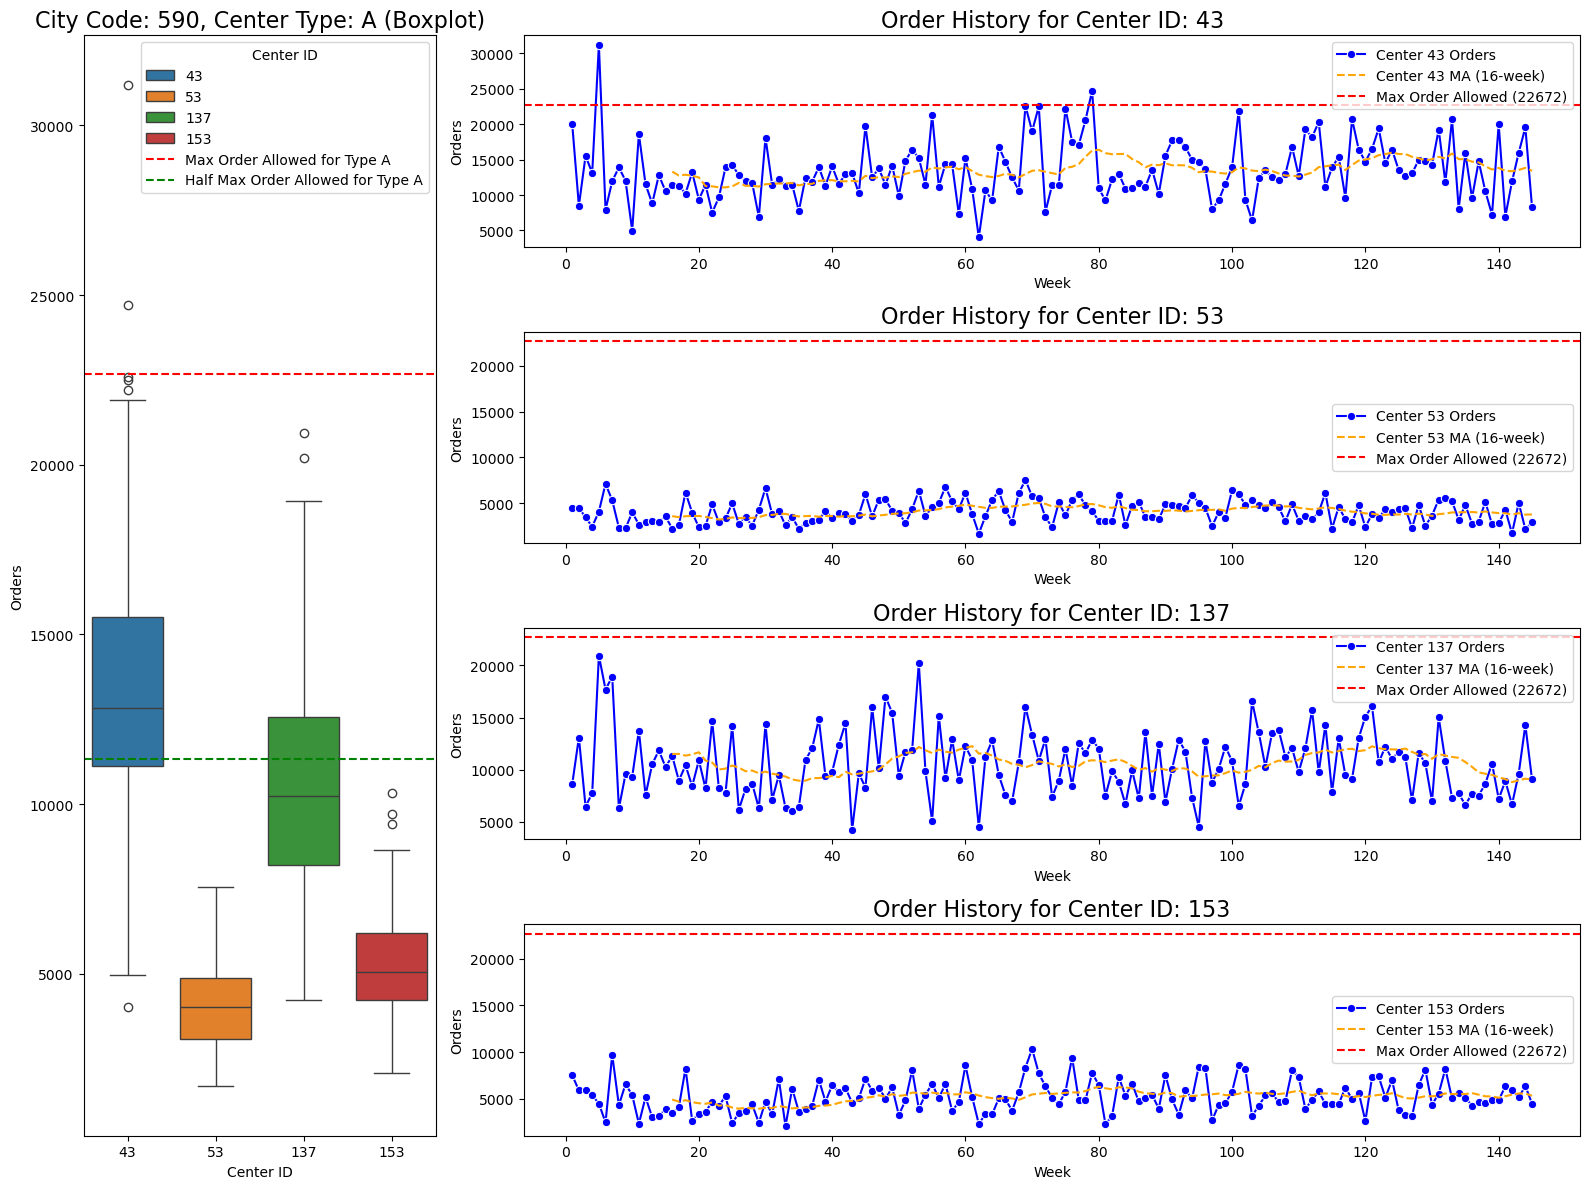

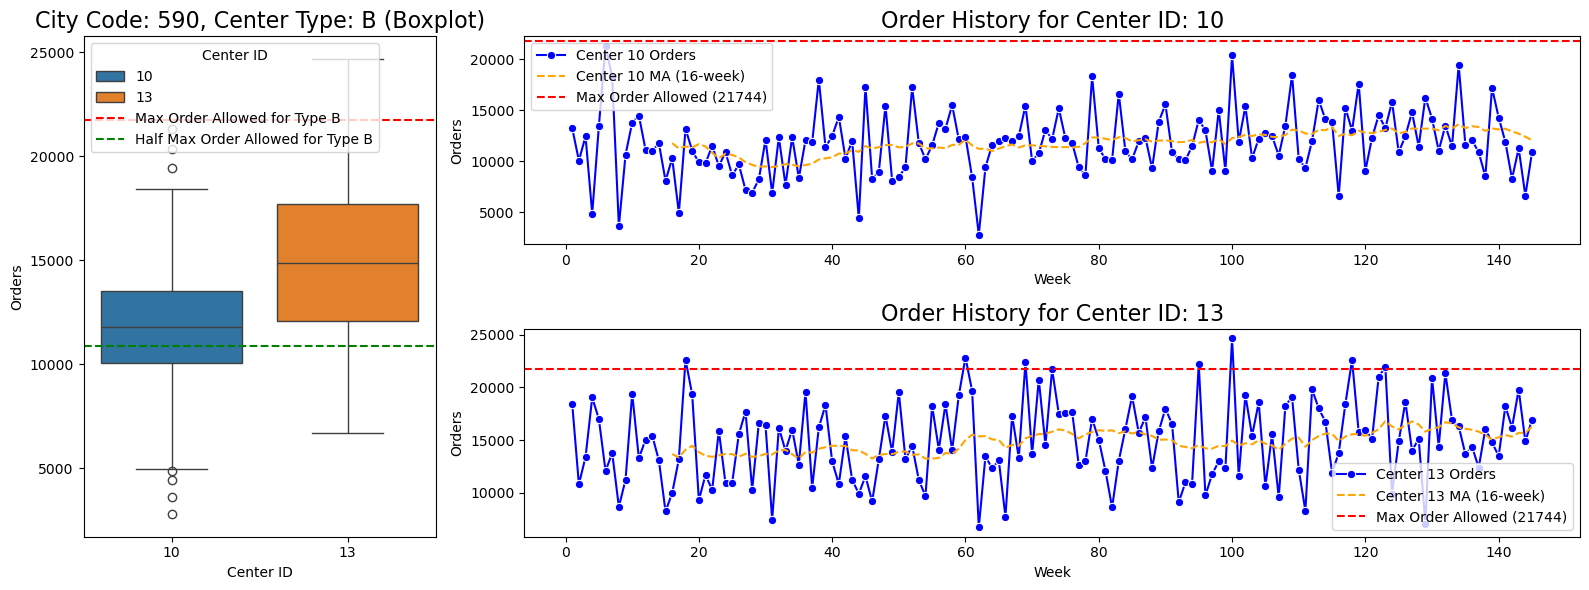

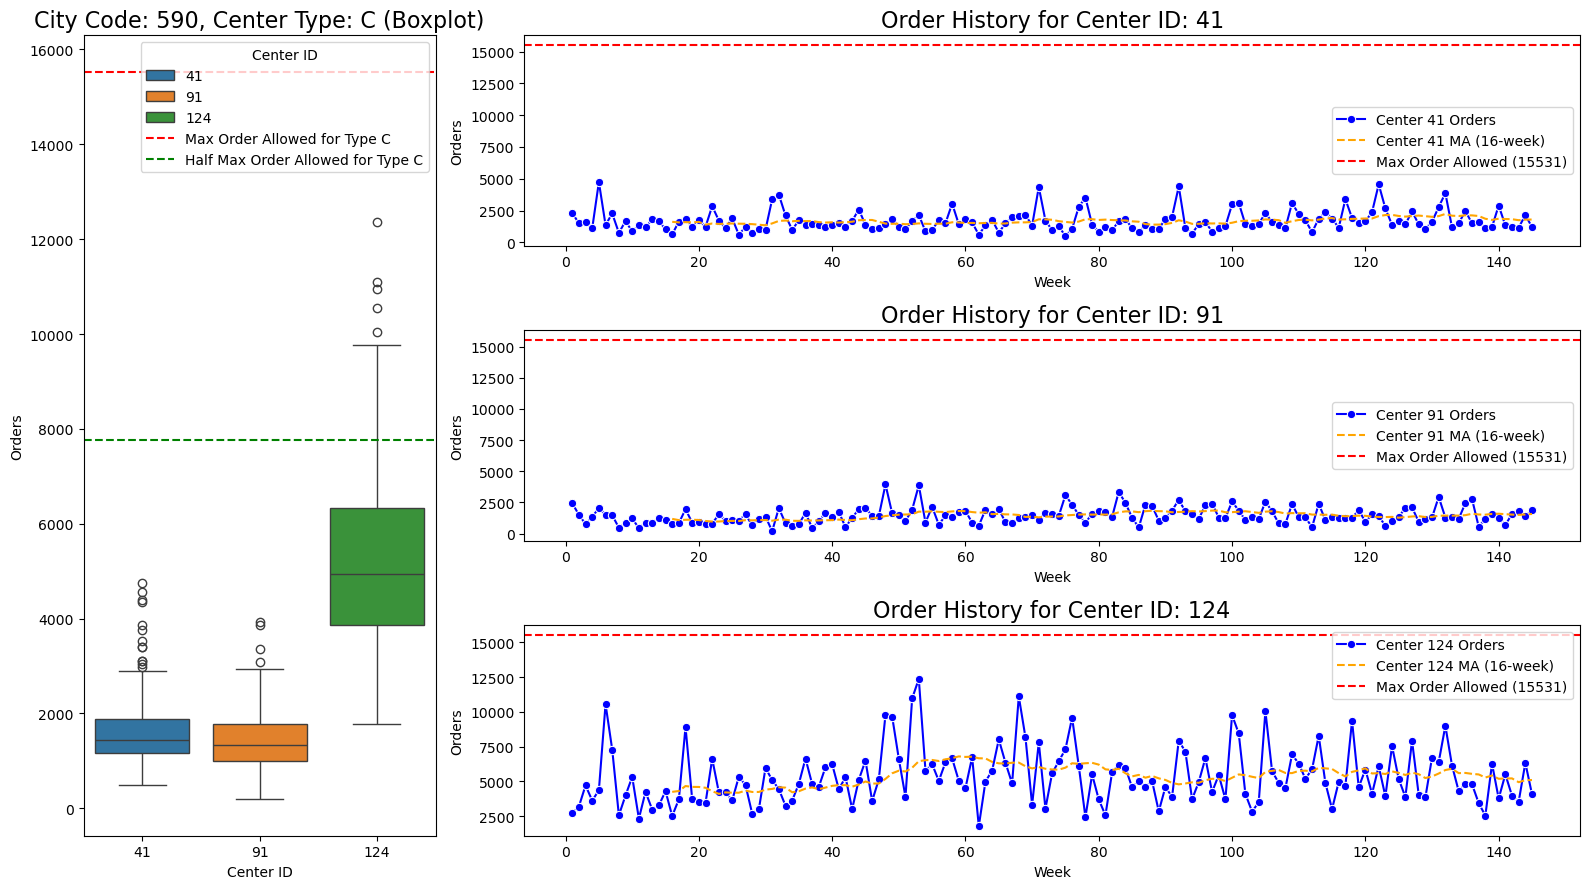

In [39]:
# Subset for city codes 526 and 590
order_526_590 = deliveries[deliveries['city_code'].isin([526, 590])]

# Group by week, city_code, center_type, and center_id
order_526_590_group = order_526_590.groupby(['week', 'city_code', 'center_type', 'center_id']).agg({'orders': 'sum'}).reset_index()

# Define target horizontal lines for each center_type
horizontal_lines = {
    'C': 15531,
    'B': 21744,
    'A': 22672
}

# Loop through each city code
for city in order_526_590_group['city_code'].unique():
    temp_dfcity = order_526_590_group[order_526_590_group['city_code'] == city]
    
    # Loop through each center type
    for ctype in temp_dfcity['center_type'].unique():
        temp_dfctype = temp_dfcity[temp_dfcity['center_type'] == ctype]
        
        # Determine the number of center_ids
        num_center_ids = temp_dfctype['center_id'].nunique()
        
        # Create a figure with GridSpec
        fig = plt.figure(figsize=(16, 3 * (num_center_ids)))  # Adjust height based on number of center_ids
        gs = GridSpec(num_center_ids, 2, width_ratios=[1, 3])  # 1/4 width for boxplot, 3/4 for lineplots

        # Create the boxplot on the left (1st column)
        ax_boxplot = fig.add_subplot(gs[:, 0])  # This will span all rows on the left column
        sns.boxplot(data=temp_dfctype, x='center_id', y='orders', hue='center_id', palette='tab10', ax=ax_boxplot)

        # Add horizontal lines for max orders allowed and half max orders allowed in the boxplot
        if ctype in horizontal_lines:
            ax_boxplot.axhline(y=horizontal_lines[ctype], color='red', linestyle='--', label=f'Max Order Allowed for Type {ctype}')
            ax_boxplot.axhline(y=horizontal_lines[ctype]/2, color='green', linestyle='--', label=f'Half Max Order Allowed for Type {ctype}')
        
        # Set title and labels for the boxplot
        ax_boxplot.set_title(f'City Code: {city}, Center Type: {ctype} (Boxplot)', fontsize=16)
        ax_boxplot.set_ylabel('Orders')
        ax_boxplot.set_xlabel('Center ID')
        ax_boxplot.legend(title='Center ID')

        # Create individual line plots for each center_id in the second column
        for i, center_id in enumerate(temp_dfctype['center_id'].unique()):
            center_data = temp_dfctype[temp_dfctype['center_id'] == center_id].sort_values(by='week')

            # Create a subplot for each center_id in the second column
            ax_lineplot = fig.add_subplot(gs[i, 1])  # Each line plot gets its own row on the second column
            
            # Plot orders
            sns.lineplot(data=center_data, x='week', y='orders', ax=ax_lineplot, label=f'Center {center_id} Orders', marker='o', color='blue')

            # Calculate and plot the moving average
            center_data['MA'] = center_data['orders'].rolling(16).mean()
            sns.lineplot(data=center_data, x='week', y='MA', ax=ax_lineplot, label=f'Center {center_id} MA (16-week)', linestyle='--', color='orange')

            # Add horizontal line for max orders allowed based on center_type
            if ctype in horizontal_lines:
                ax_lineplot.axhline(y=horizontal_lines[ctype], color='red', linestyle='--', label=f'Max Order Allowed ({horizontal_lines[ctype]})')

            # Set title and labels for the line plot
            ax_lineplot.set_title(f'Order History for Center ID: {center_id}', fontsize=16)
            ax_lineplot.set_ylabel('Orders')
            ax_lineplot.set_xlabel('Week')
            ax_lineplot.legend()

        # Save the figure as PNG
        fig.savefig(f"Order_Handled_City_{city}_Type_{ctype}.png", dpi=300, bbox_inches='tight')

        # Adjust layout and show the plots
        plt.tight_layout()
        plt.show()


### Insights 1: Merge 81 and 88 (City 526, Type A), 92 and 162 (City 526 Type C), 53 and 153 (City 590 Type A)

### Insights 2: Add 1 type C near center id 43 (city 590 type A); Add 1 type C near center 13 (city 590 type B)

# Promo Analysis

In [40]:
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228274 entries, 114136 to 162455
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              228274 non-null  int64  
 1   week            228274 non-null  int64  
 2   center_id       228274 non-null  int64  
 3   city_code       228274 non-null  int64  
 4   region_code     228274 non-null  int64  
 5   center_type     228274 non-null  object 
 6   op_area         228274 non-null  float64
 7   meal_id         228274 non-null  int64  
 8   category        228274 non-null  object 
 9   cuisine         228274 non-null  object 
 10  checkout_price  228274 non-null  float64
 11  base_price      228274 non-null  float64
 12  emailer         228274 non-null  int64  
 13  featured        228274 non-null  int64  
 14  orders          228274 non-null  int64  
 15  sales           228274 non-null  float64
 16  discount        228274 non-null  float64
dtypes: float64

### If promo is given on certain week, did everyone buy in that period get the promo?

In [41]:
tes = deliveries[deliveries['meal_id']==1109].groupby(['week','meal_id'], as_index=False).agg({'emailer':'mean'})
tes[(tes['emailer']>0)&(tes['emailer']<1)]

week  meal_id   emailer
0      1     1109  0.534884
1      2     1109  0.619048
29    30     1109  0.500000
40    41     1109  0.931818
46    47     1109  0.542857

In [42]:
tes = deliveries[deliveries['meal_id']==1109].groupby(['week','meal_id'], as_index=False).agg({'featured':'mean'})
tes[(tes['featured']>0)&(tes['featured']<1)]

week  meal_id  featured
0       1     1109  0.023256
1       2     1109  0.309524
2       3     1109  0.083333
3       4     1109  0.025641
7       8     1109  0.026316
..    ...      ...       ...
137   138     1109  0.026316
138   139     1109  0.027027
140   141     1109  0.025641
141   142     1109  0.027027
142   143     1109  0.050000

[61 rows x 3 columns]

### Is the promo given by region or city?

In [43]:
deliveries.columns

Index(['id', 'week', 'center_id', 'city_code', 'region_code', 'center_type',
       'op_area', 'meal_id', 'category', 'cuisine', 'checkout_price',
       'base_price', 'emailer', 'featured', 'orders', 'sales', 'discount'],
      dtype='object')

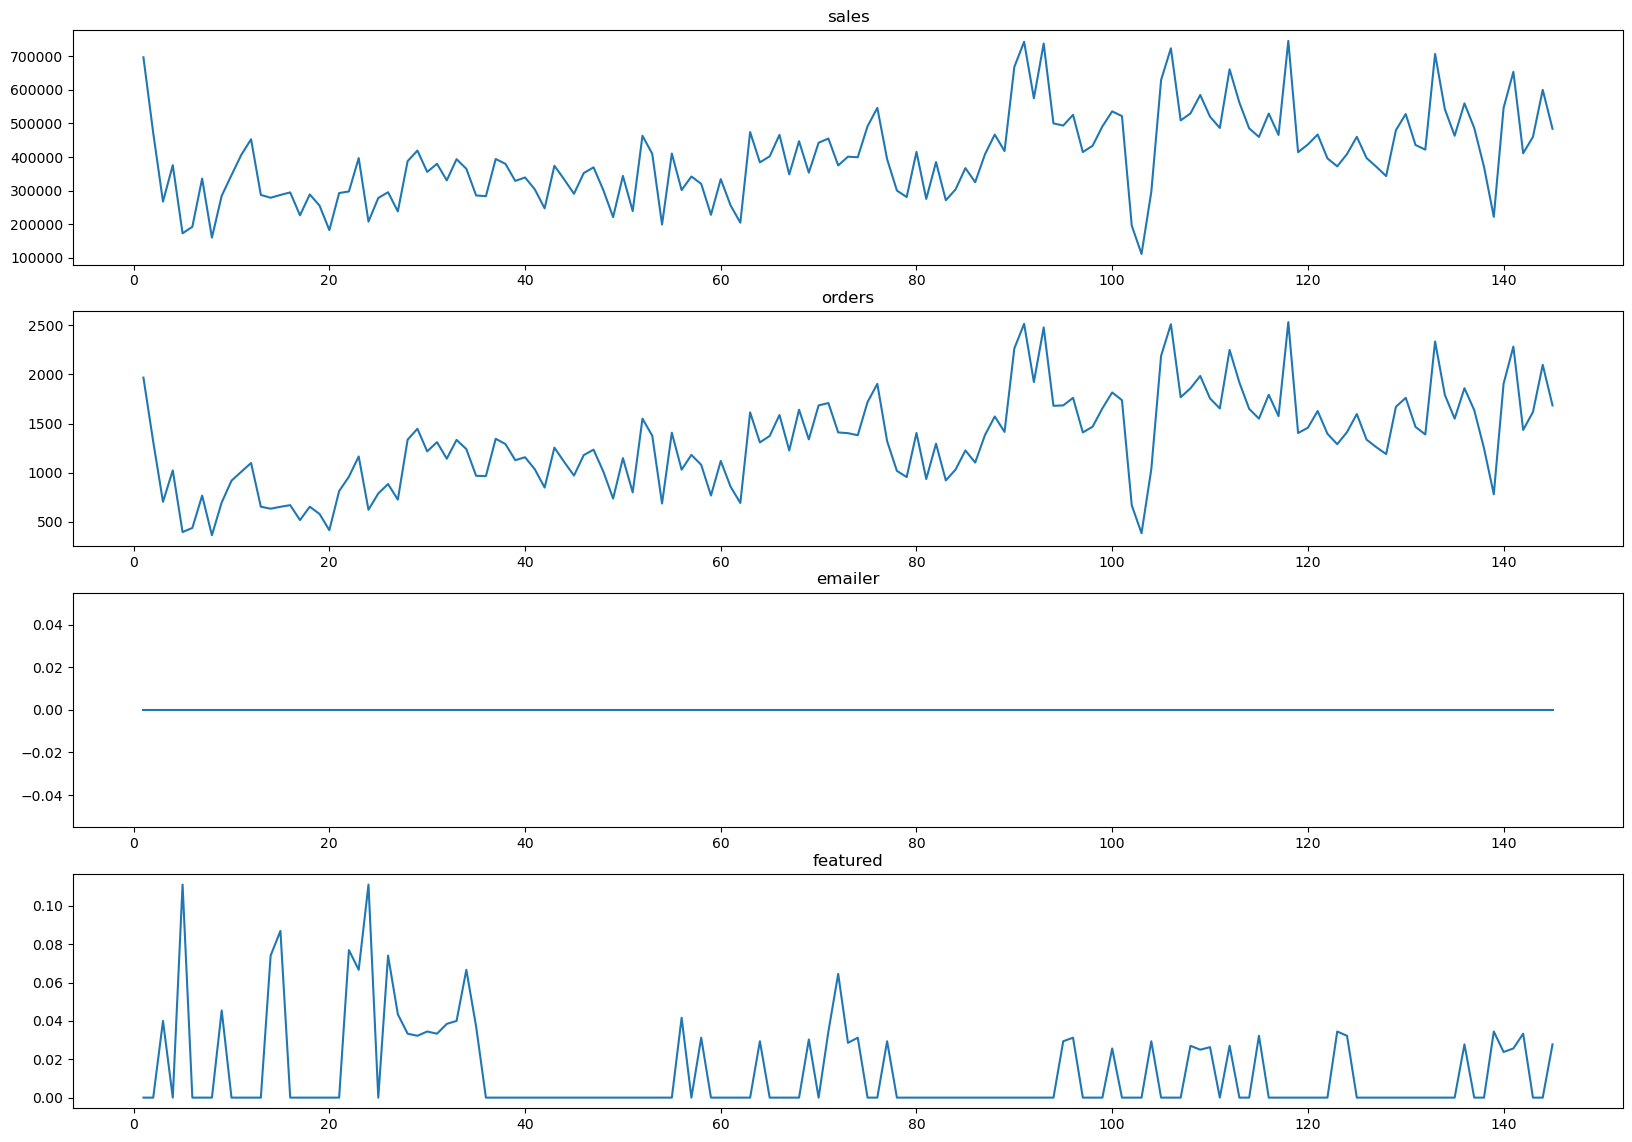

In [44]:
deliveries_meal_specified = deliveries[deliveries['meal_id']==2139]

weekly_meal_specified = deliveries_meal_specified.groupby('week',as_index=False).agg({'orders':'sum', 'sales':'sum', 'emailer':'mean', 'featured':'mean'})

fig, ax = plt.subplots(figsize=(20,14), nrows = 4, ncols = 1)
ax[0].plot(weekly_meal_specified['week'], weekly_meal_specified['sales'])
ax[0].set_title('sales')
ax[1].plot(weekly_meal_specified['week'], weekly_meal_specified['orders'])
ax[1].set_title('orders')
ax[2].plot(weekly_meal_specified['week'], weekly_meal_specified['emailer'])
ax[2].set_title('emailer')
ax[3].plot(weekly_meal_specified['week'], weekly_meal_specified['featured'])
ax[3].set_title('featured')

plt.show()

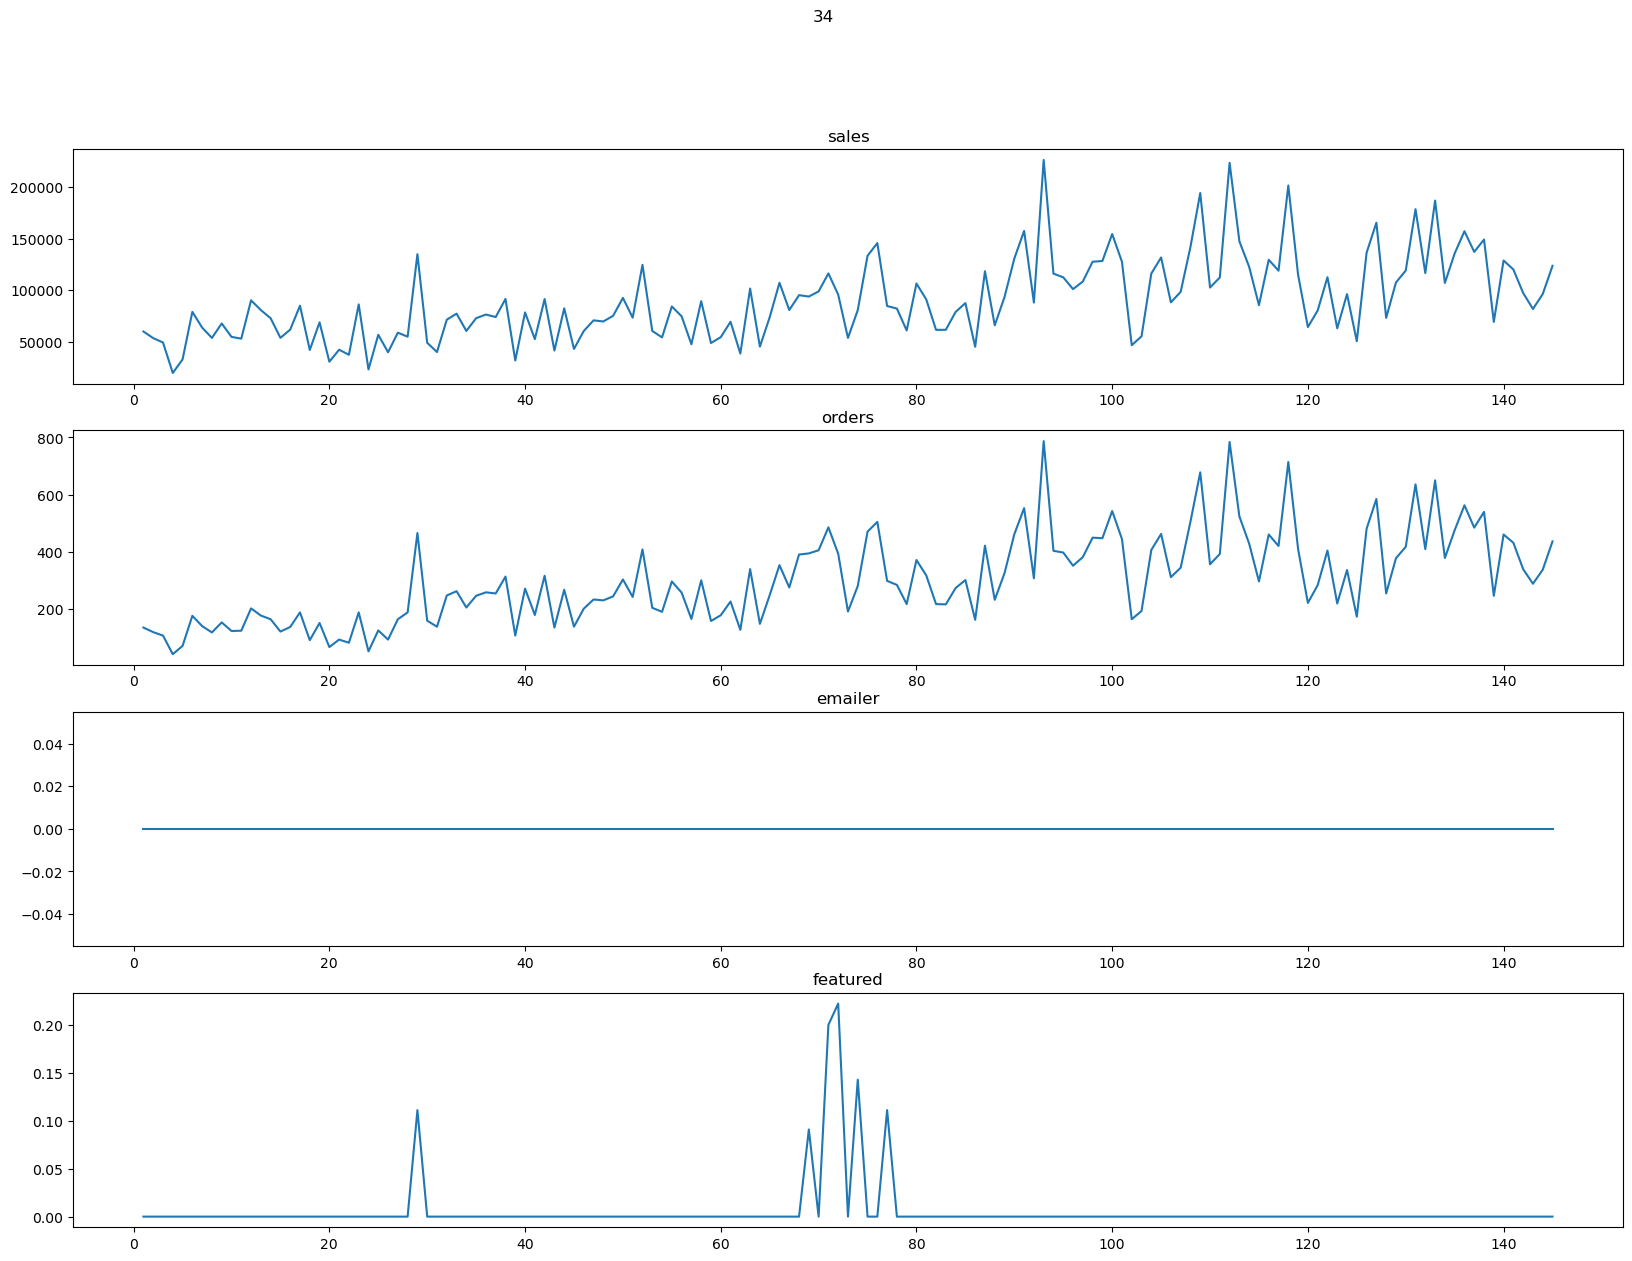

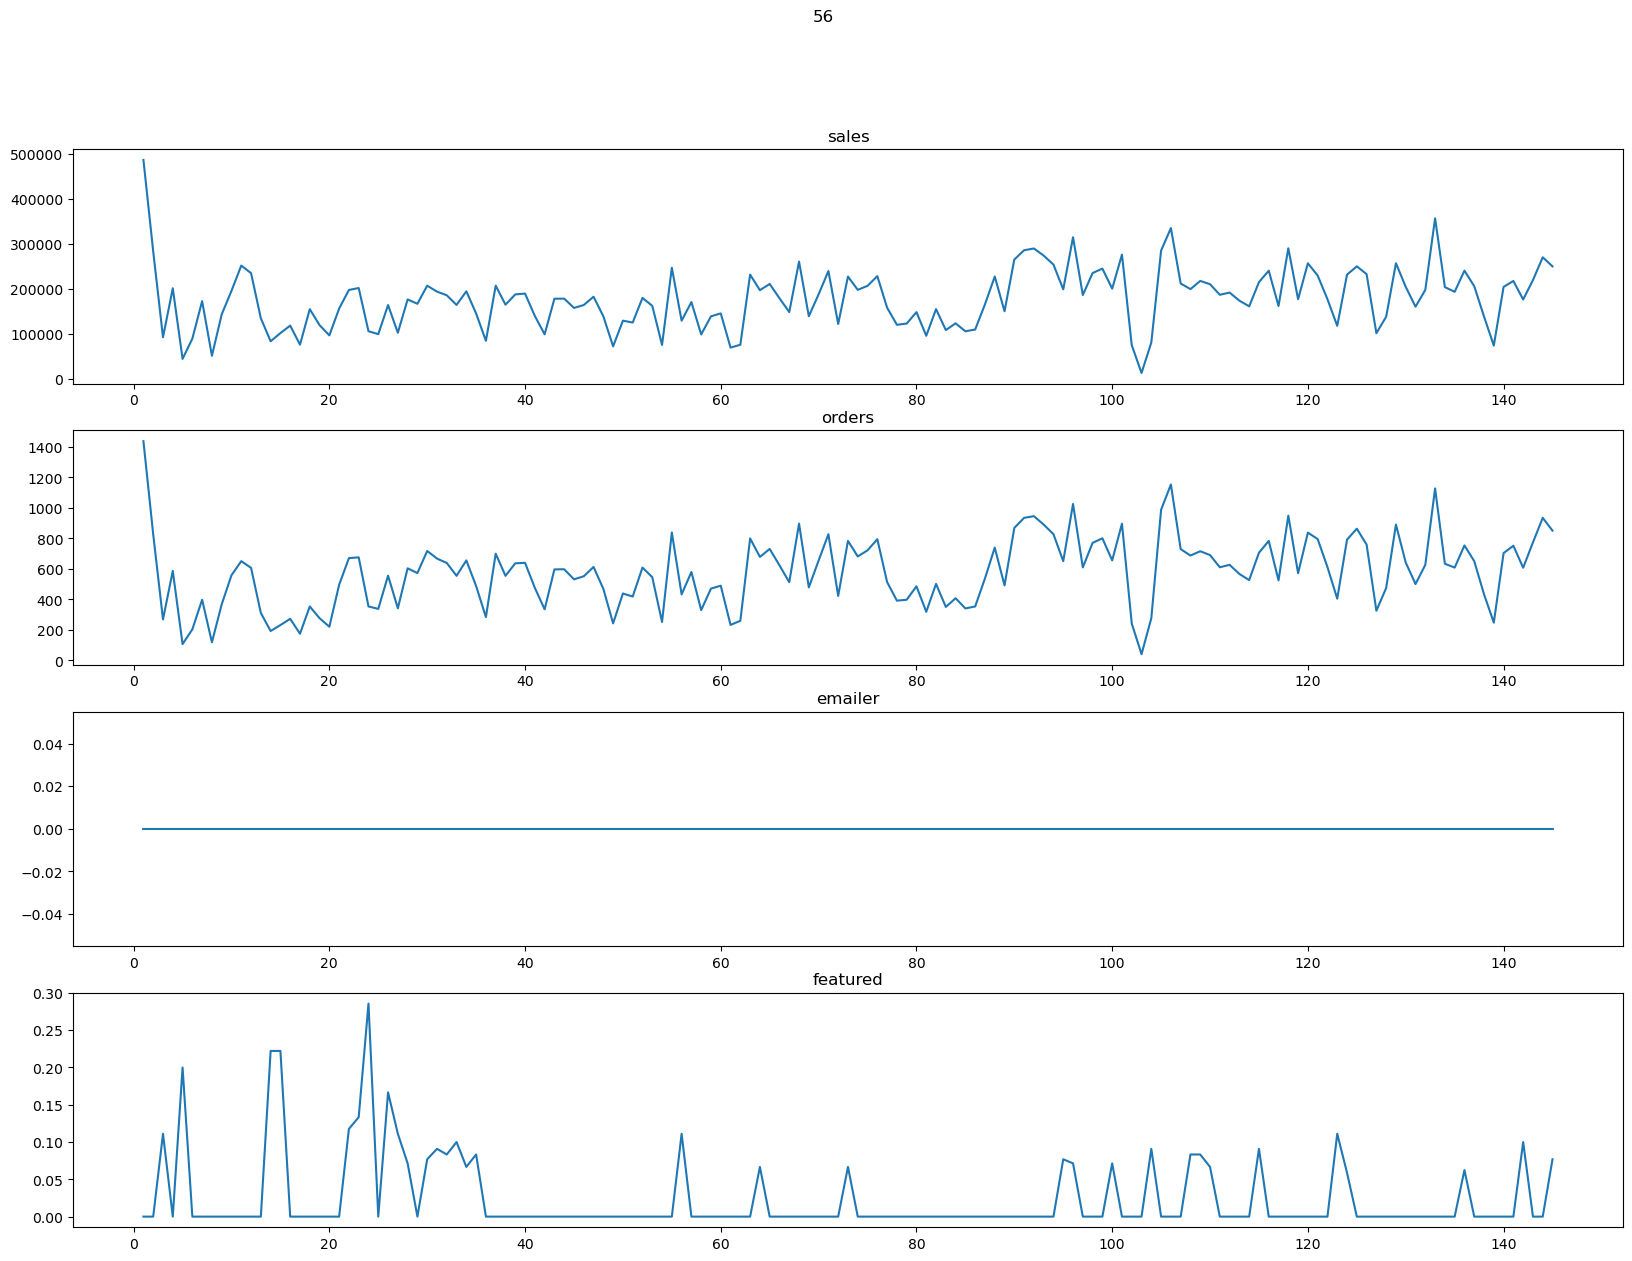

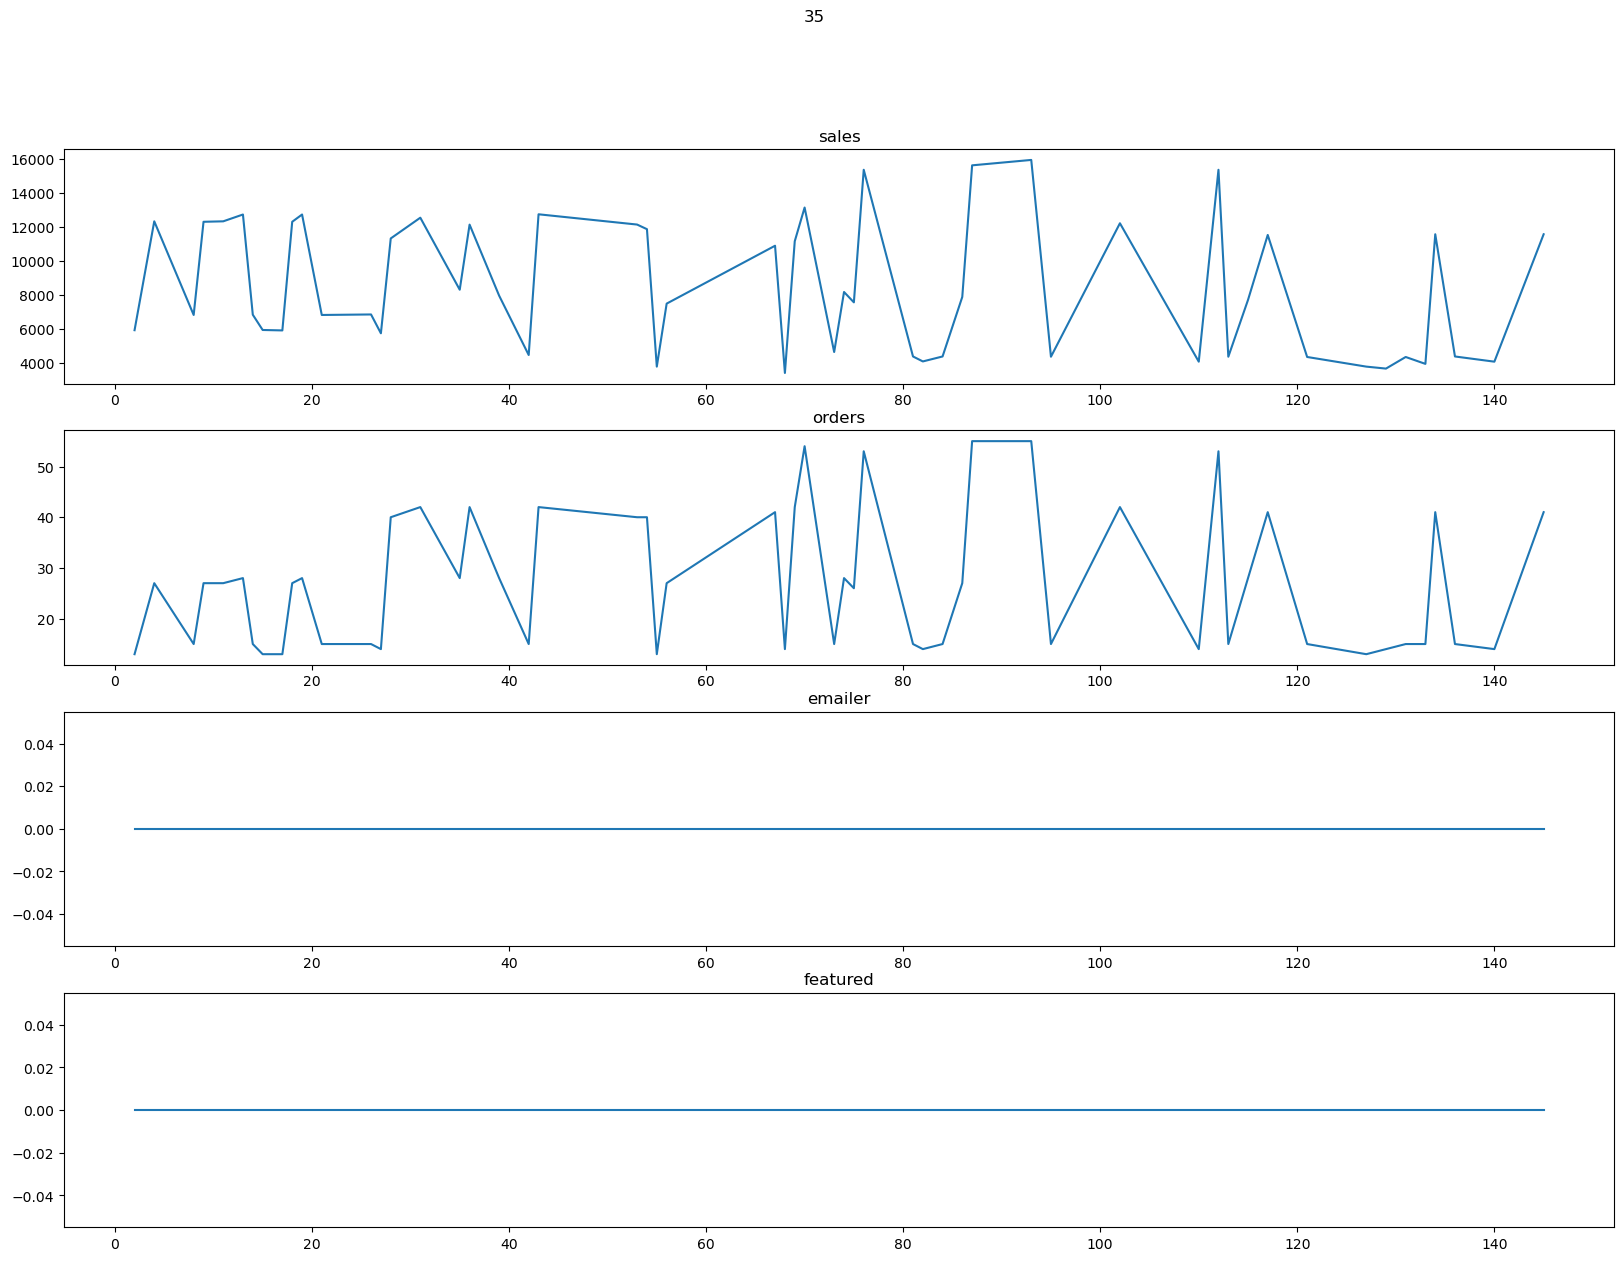

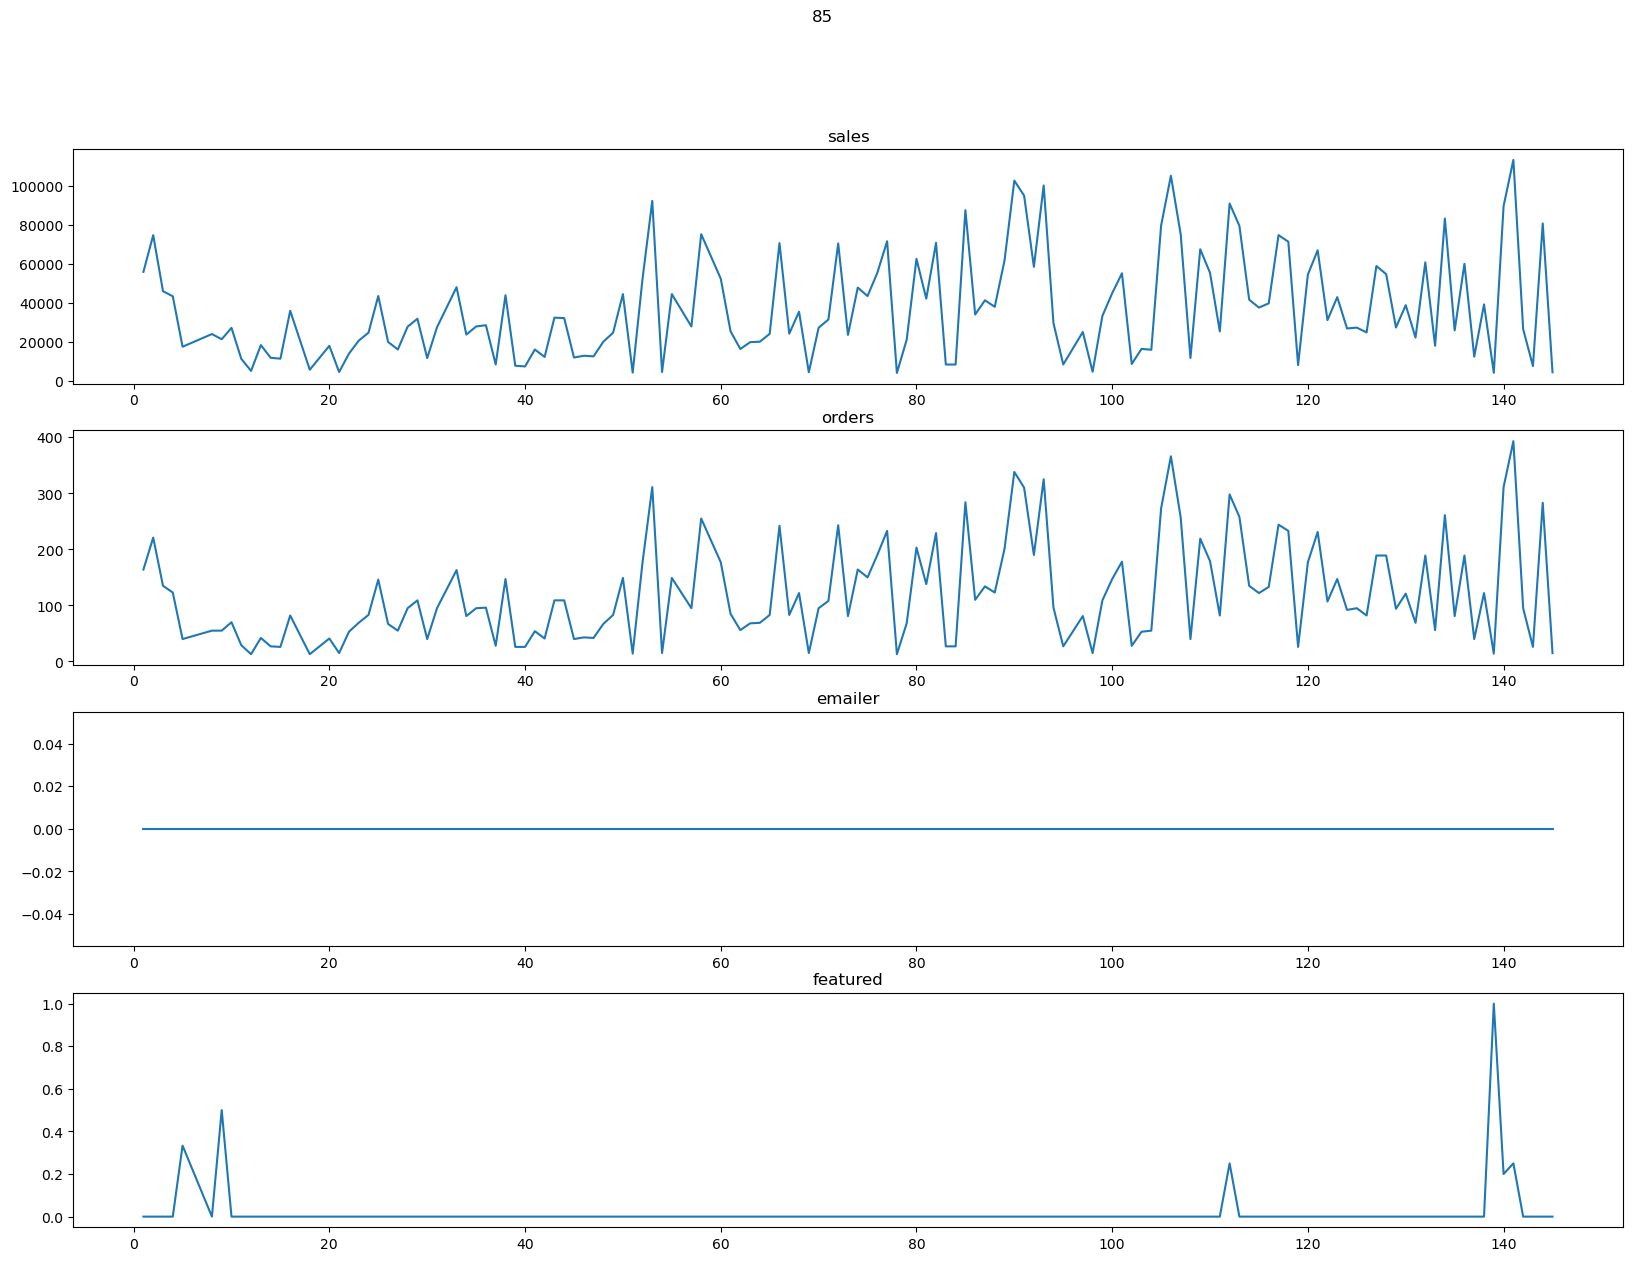

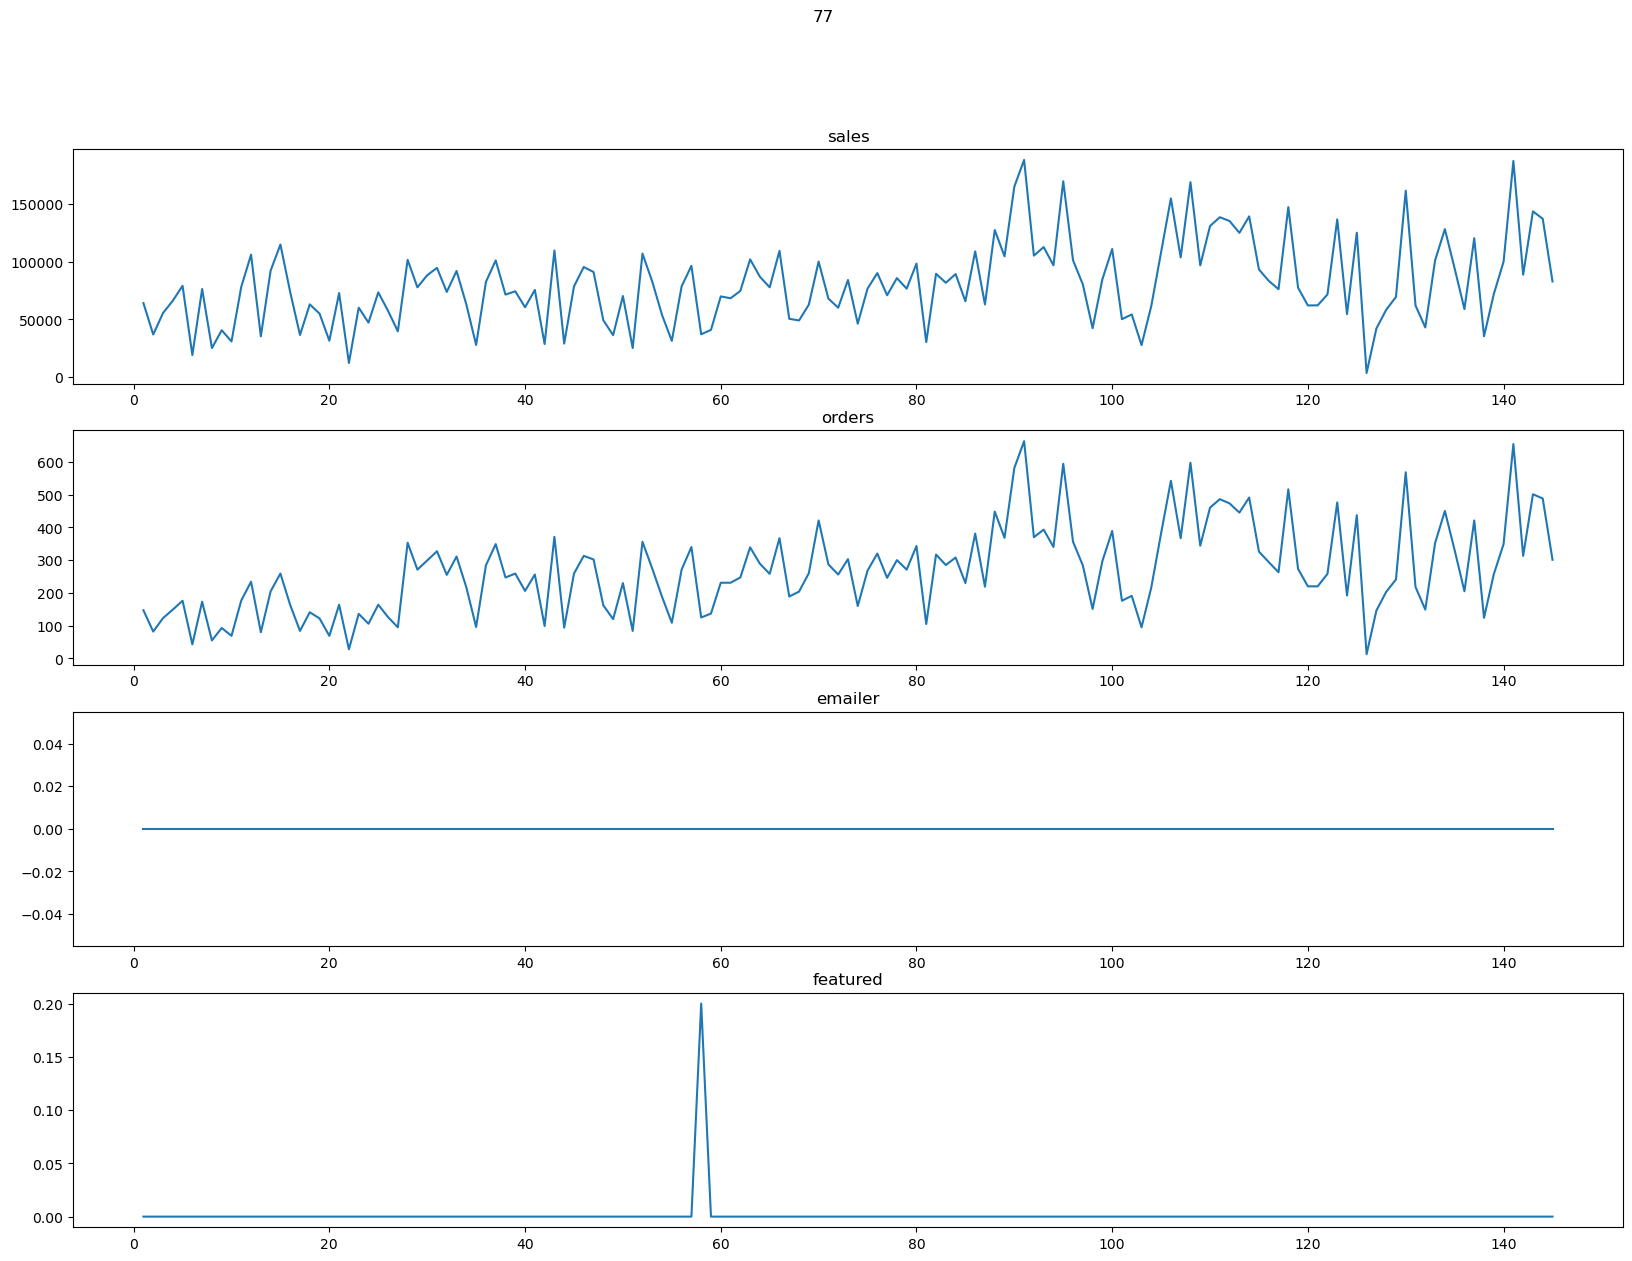

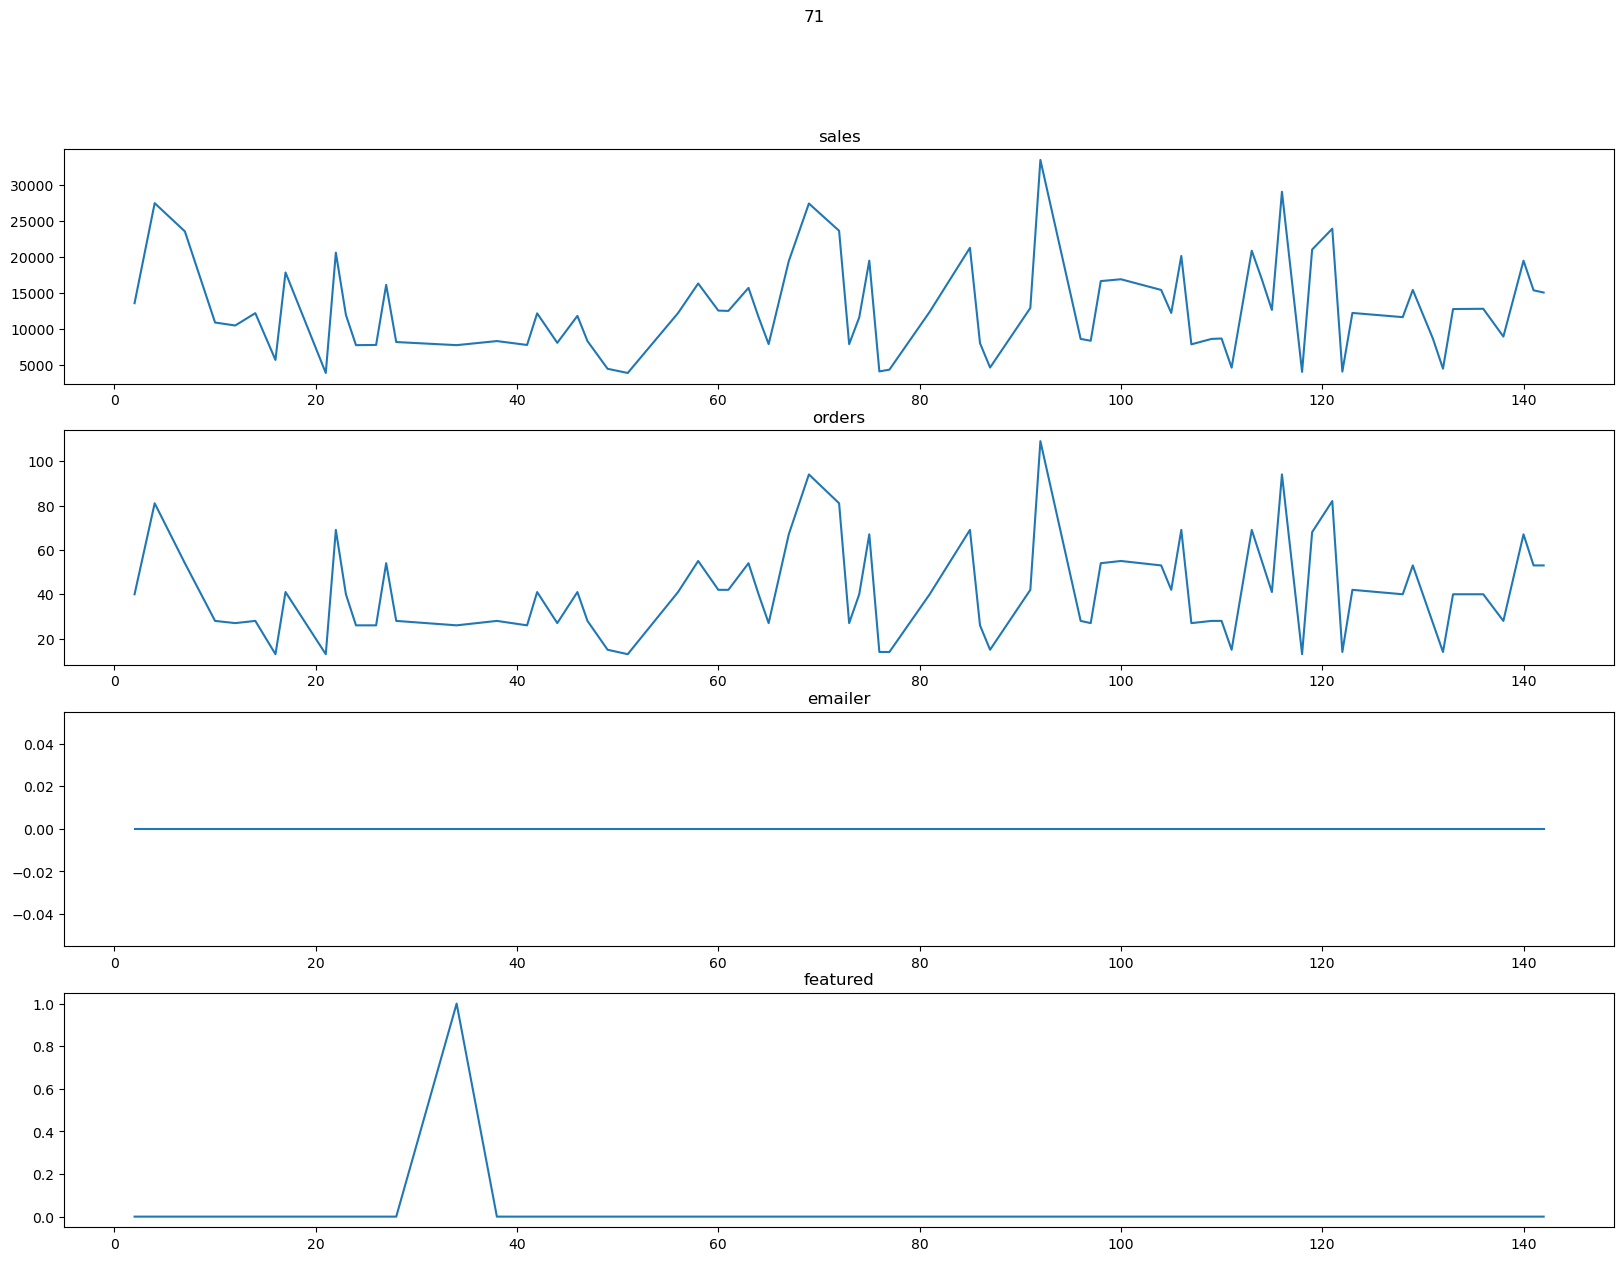

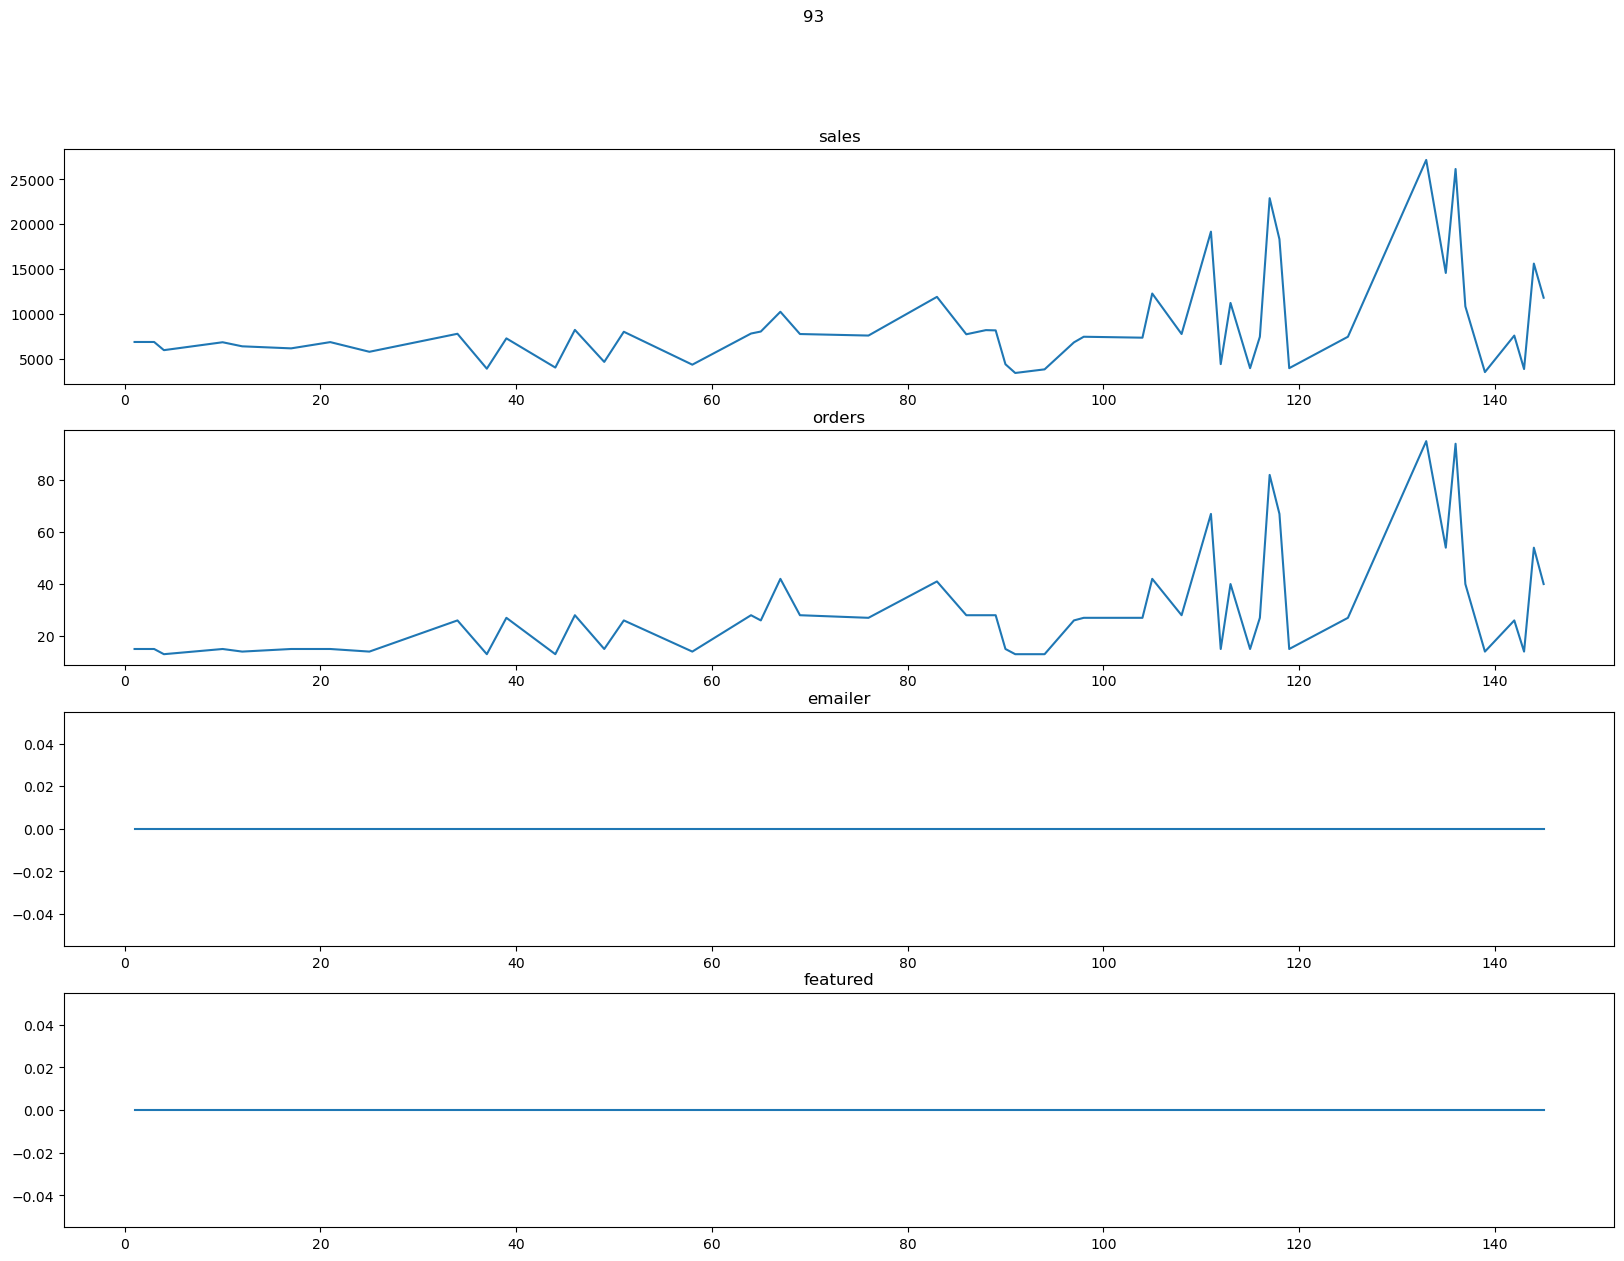

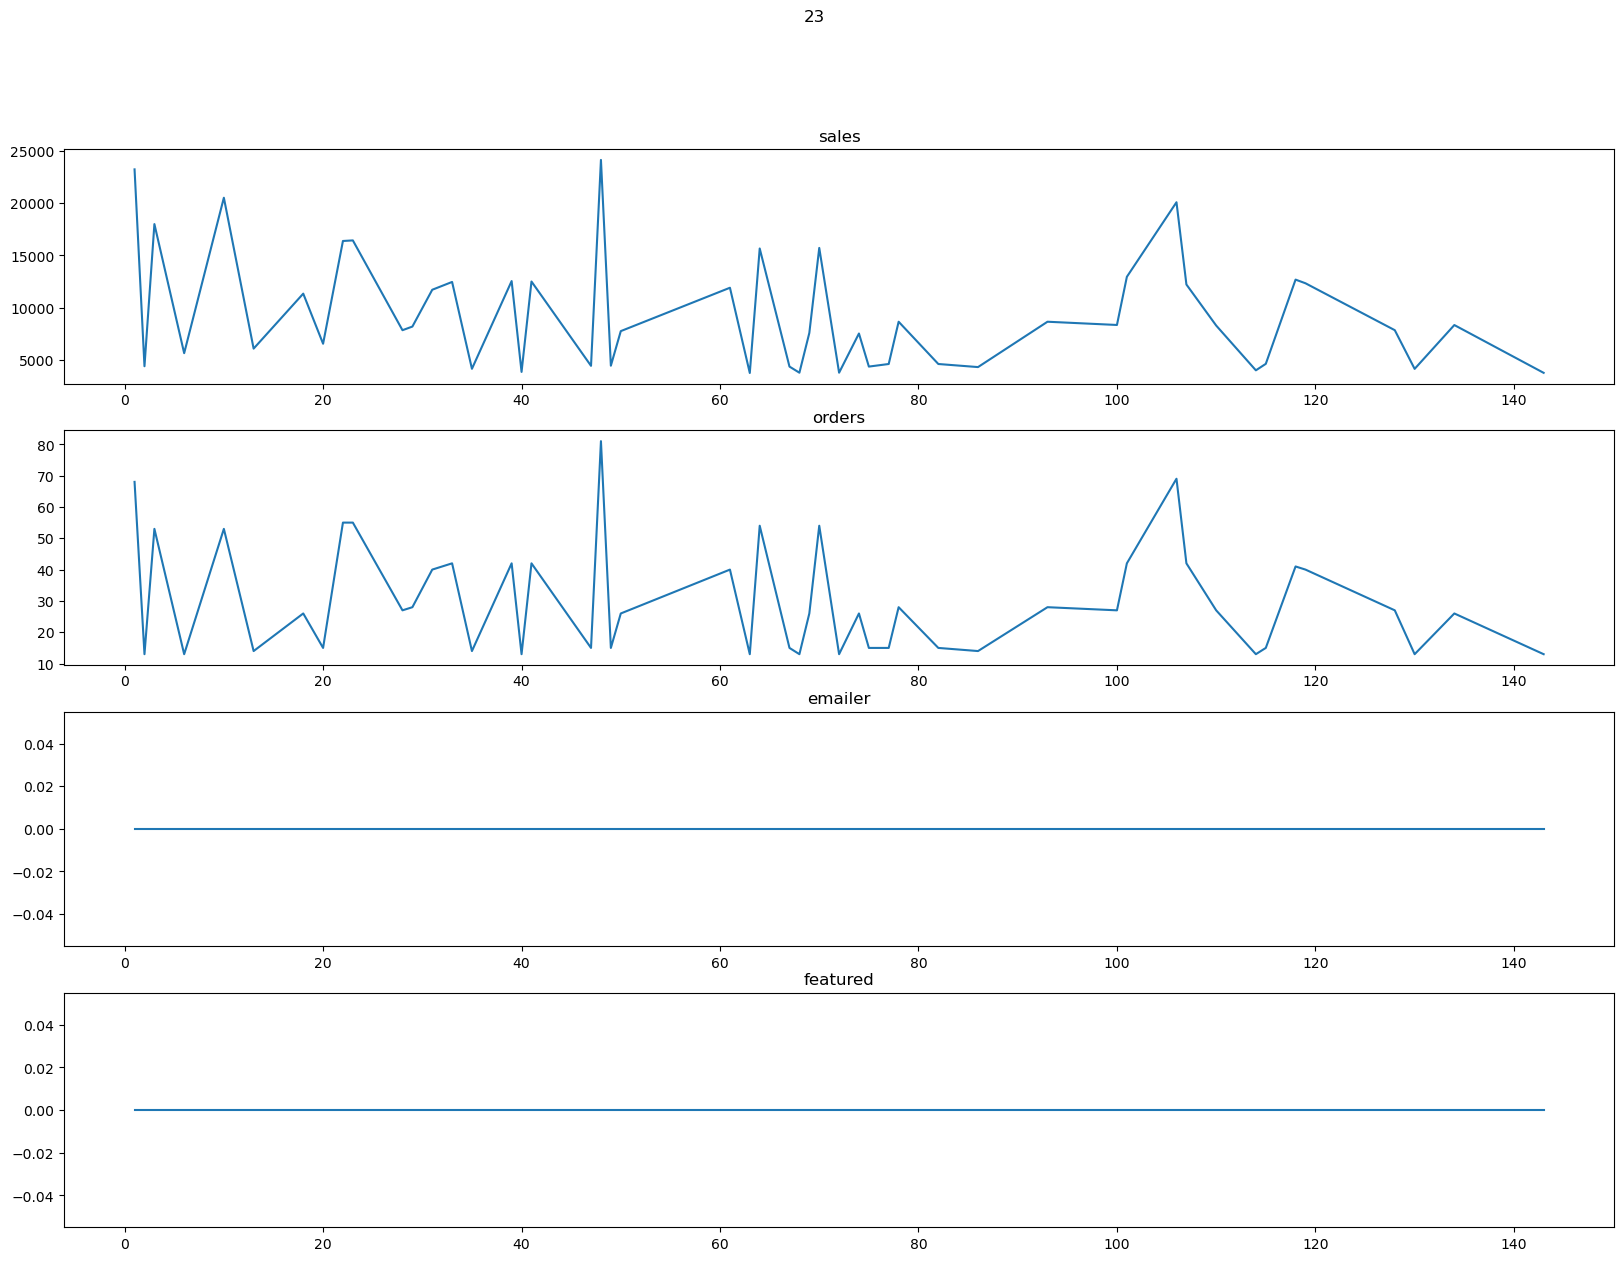

In [45]:
deliveries_meal_specified = deliveries[deliveries['meal_id']==2139]

for i in deliveries['region_code'].unique():
    region_specified = deliveries_meal_specified[deliveries_meal_specified['region_code']==i]
    weekly_region_specified =region_specified.groupby('week',as_index=False)\
                                                      .agg({'orders':'sum', 'sales':'sum', 'emailer':'mean', 'featured':'mean'})

    fig, ax = plt.subplots(figsize=(20,14), nrows = 4, ncols = 1)
    fig.suptitle(f'{i}')
    ax[0].plot(weekly_region_specified['week'], weekly_region_specified['sales'])
    ax[0].set_title('sales')
    ax[1].plot(weekly_region_specified['week'], weekly_region_specified['orders'])
    ax[1].set_title('orders')
    ax[2].plot(weekly_region_specified['week'], weekly_region_specified['emailer'])
    ax[2].set_title('emailer')
    ax[3].plot(weekly_region_specified['week'], weekly_region_specified['featured'])
    ax[3].set_title('featured')

    plt.show()

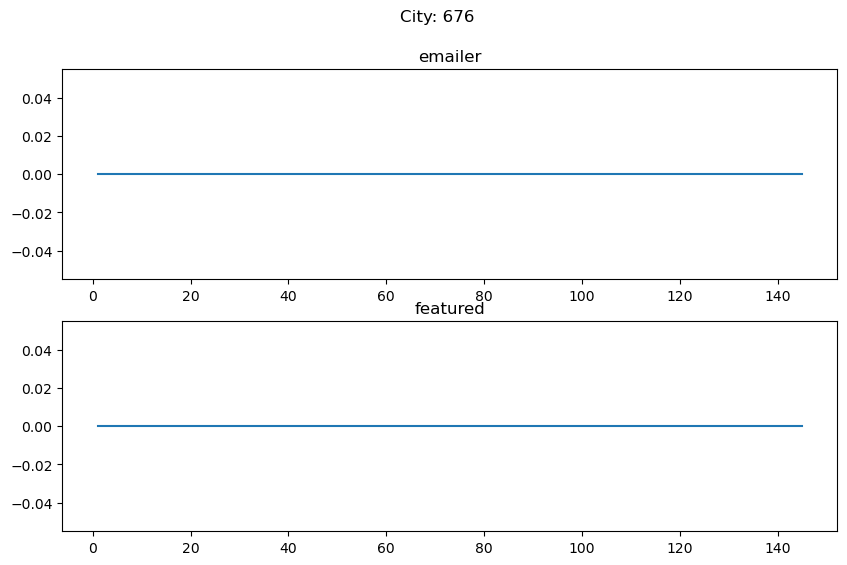

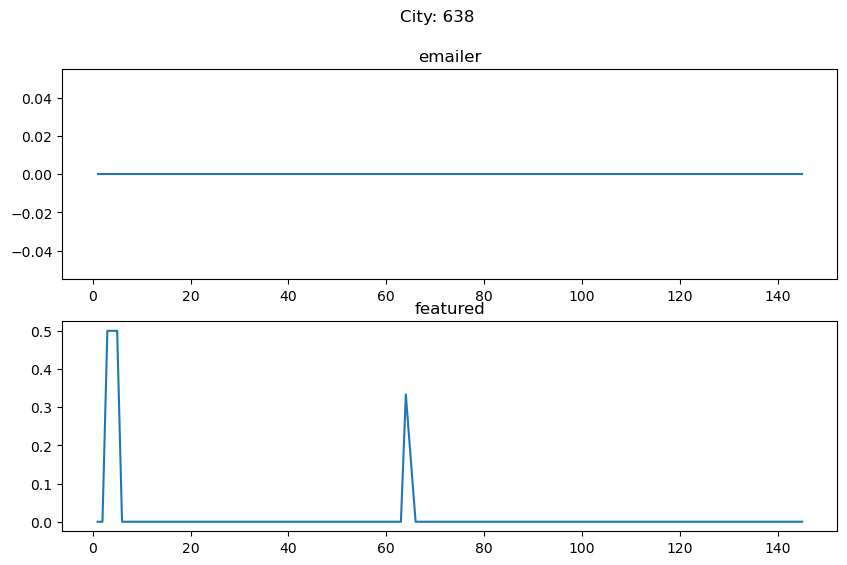

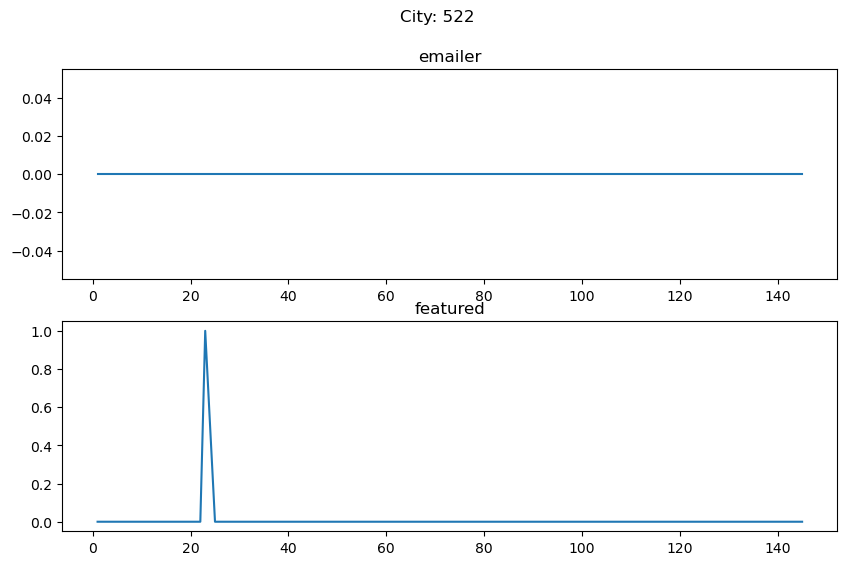

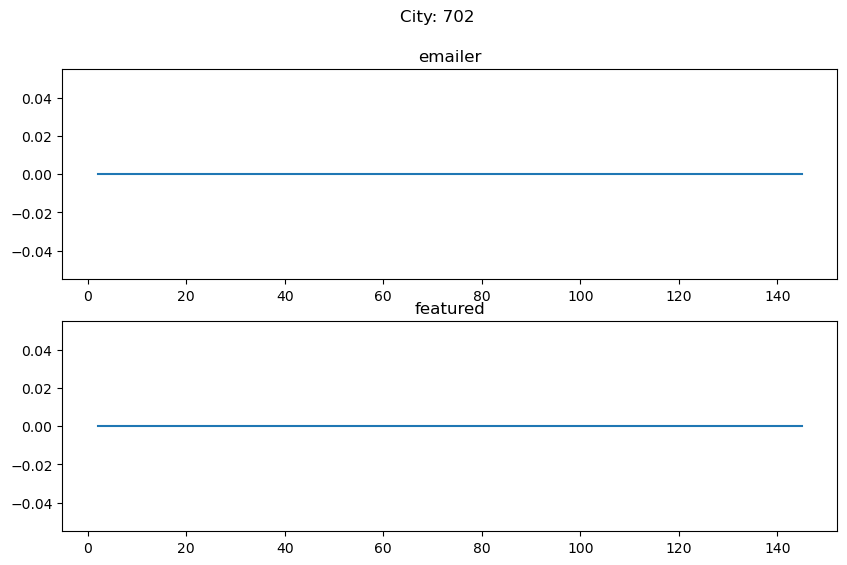

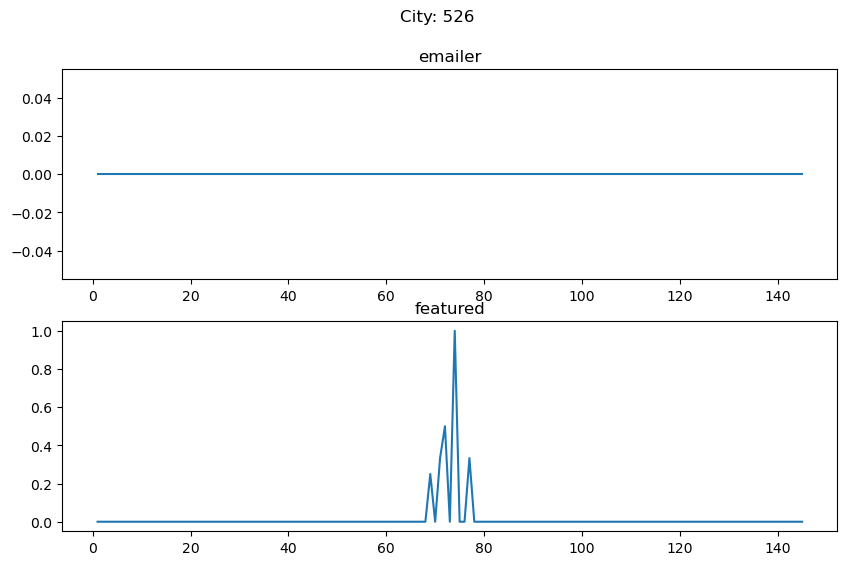

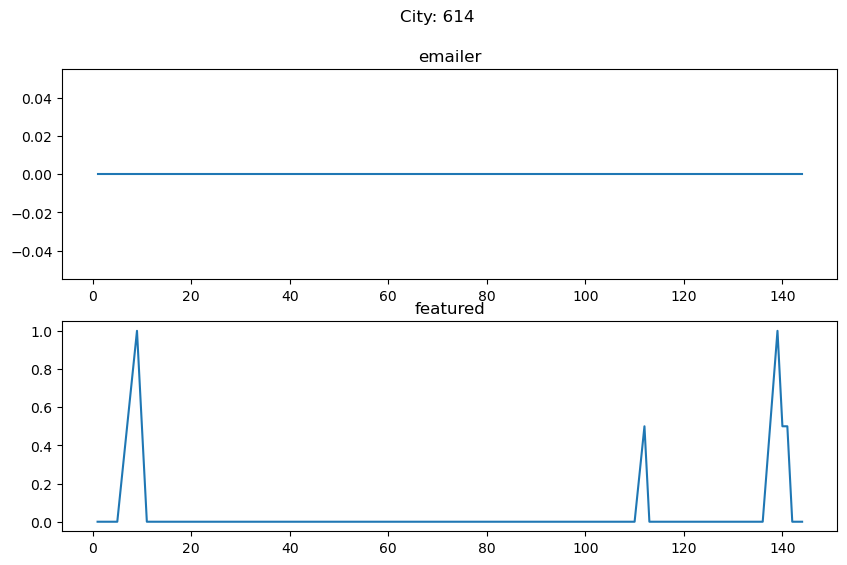

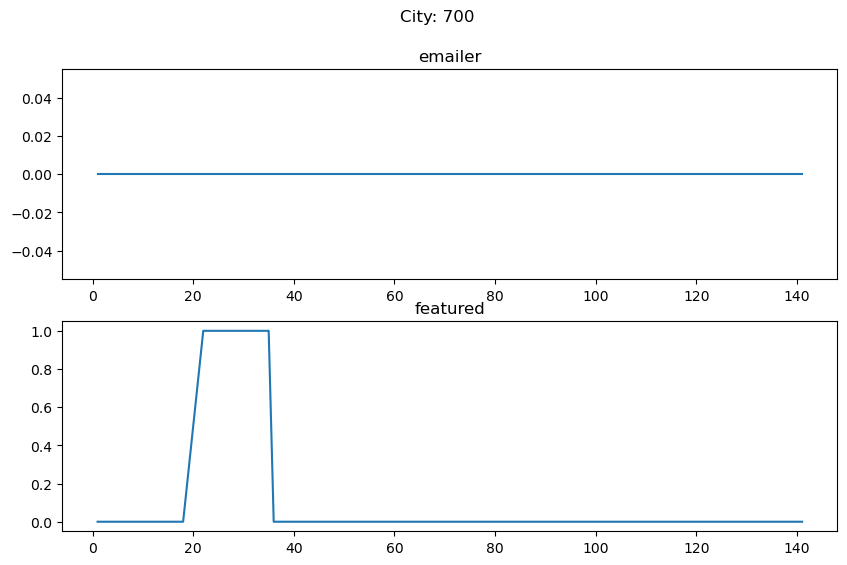

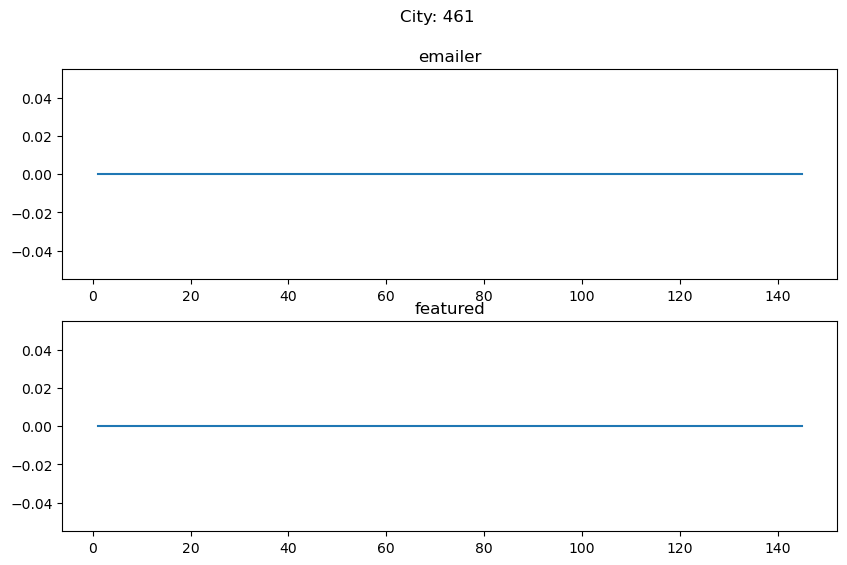

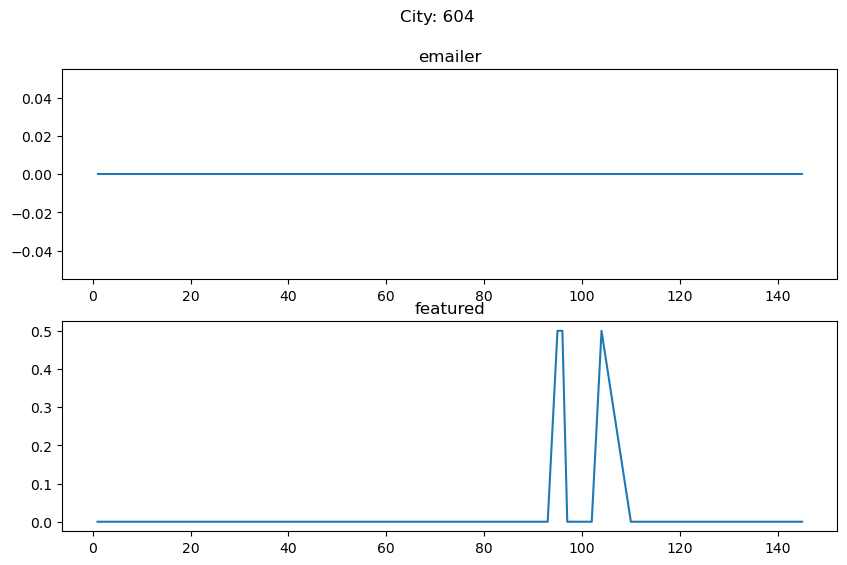

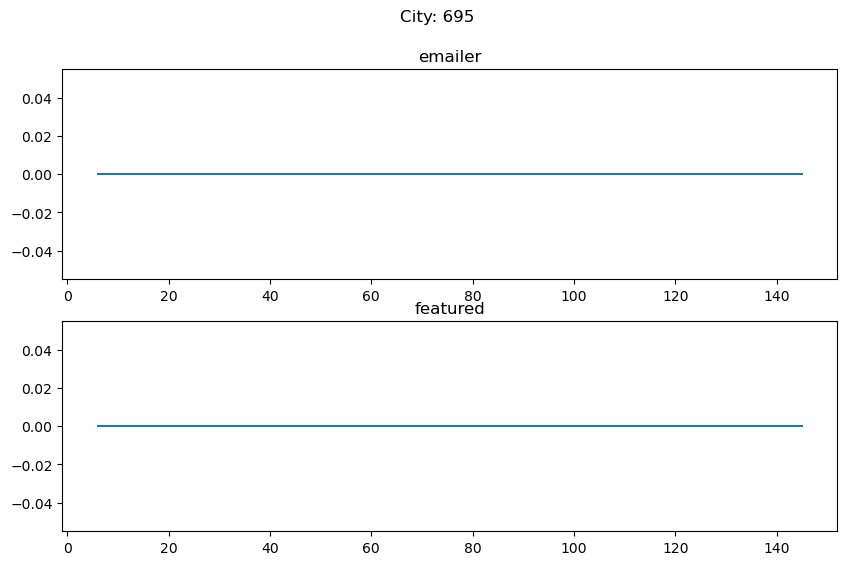

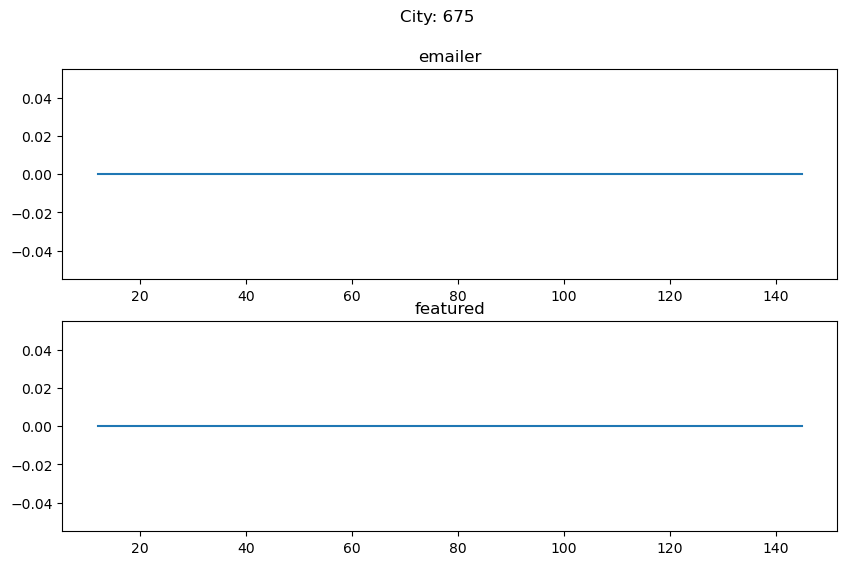

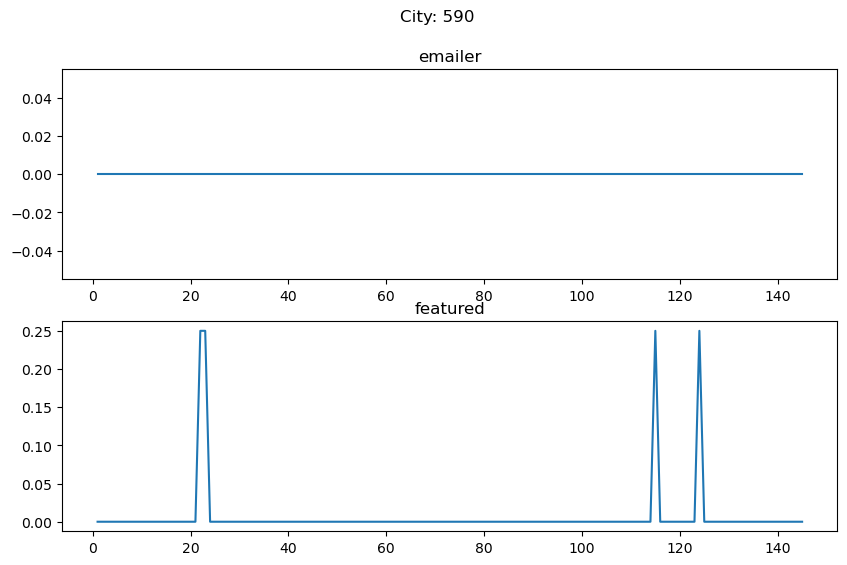

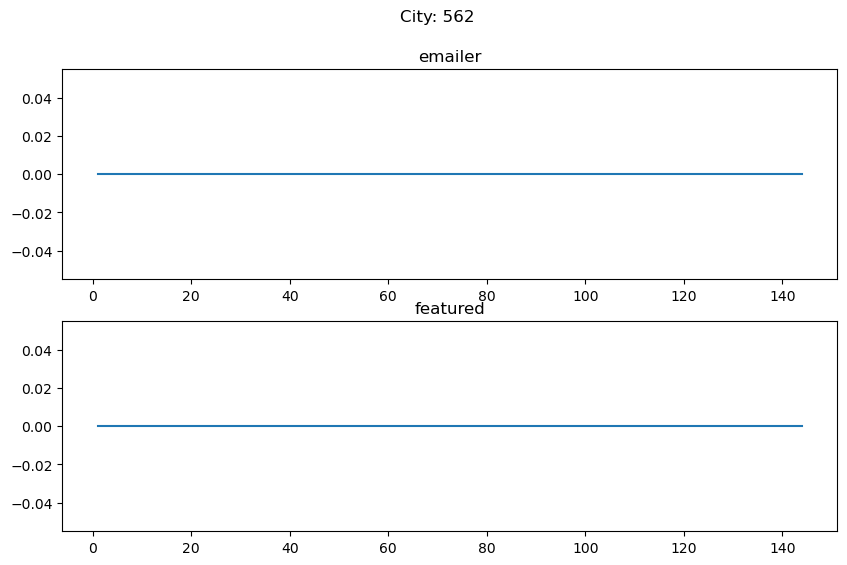

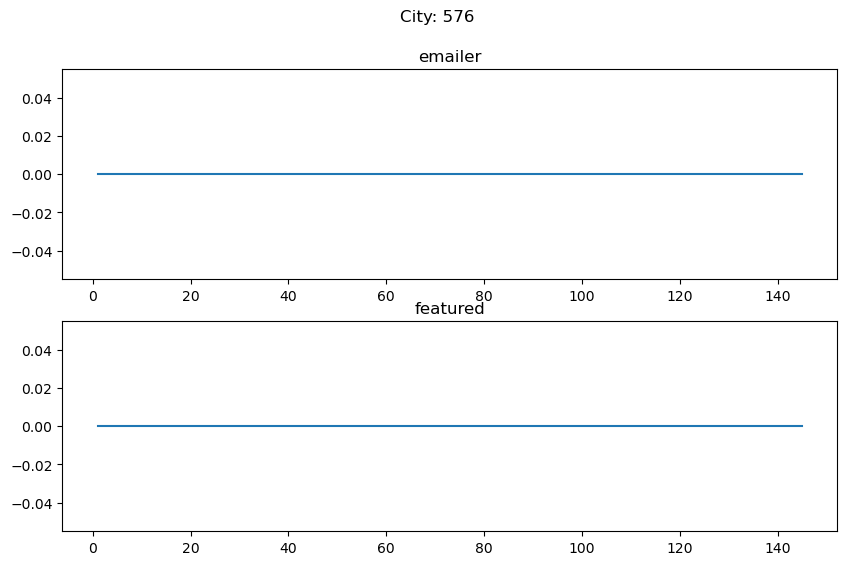

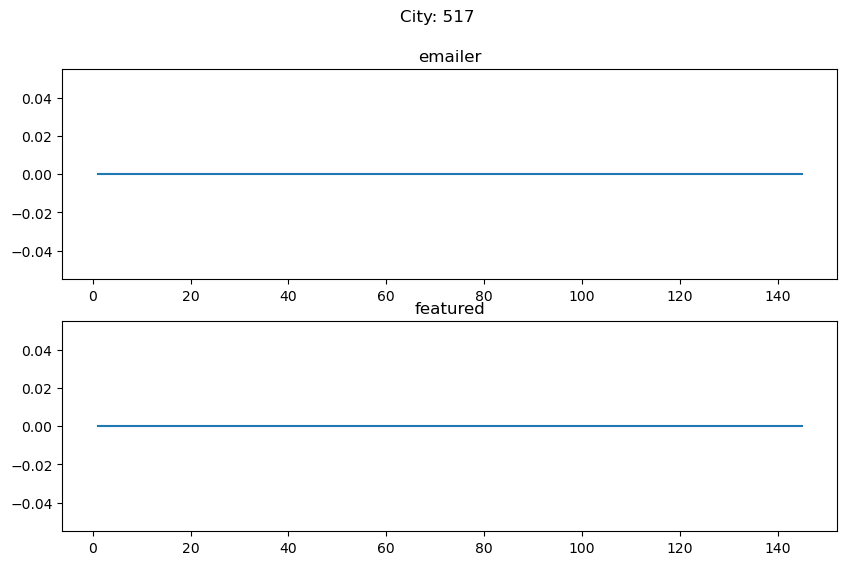

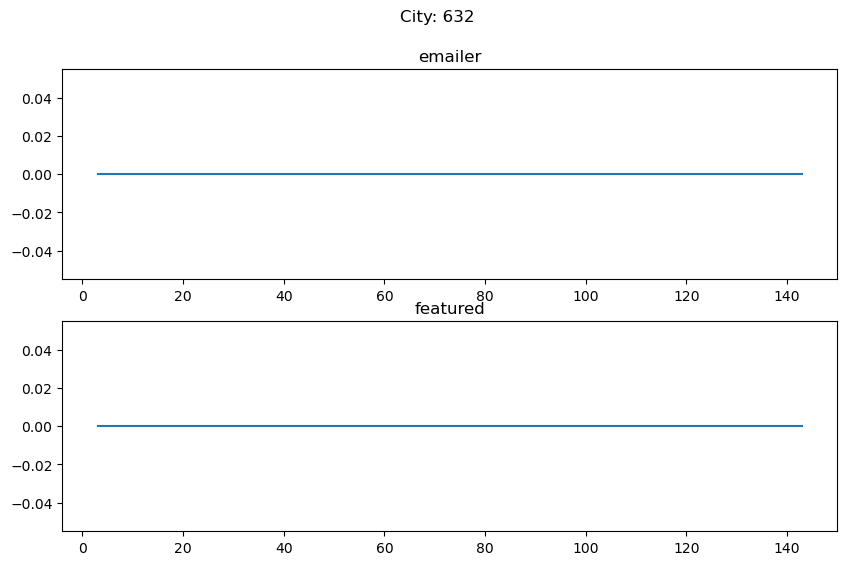

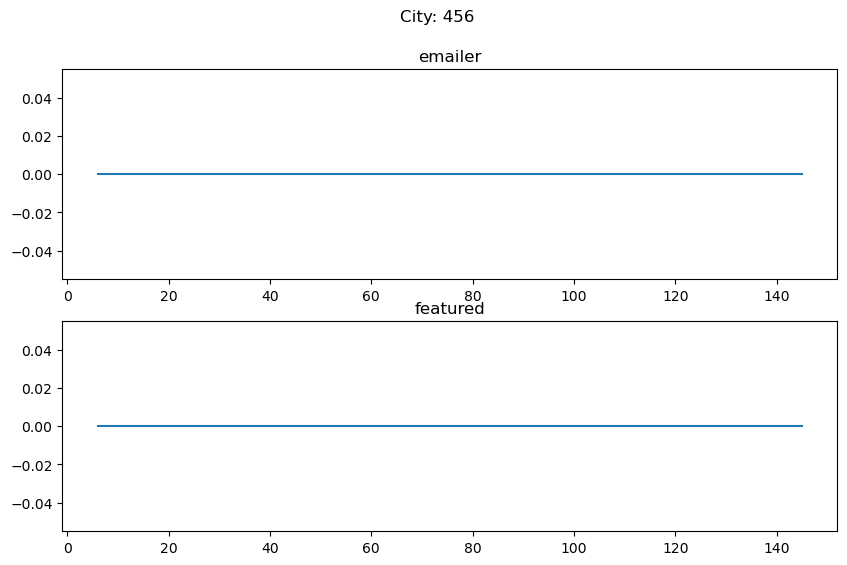

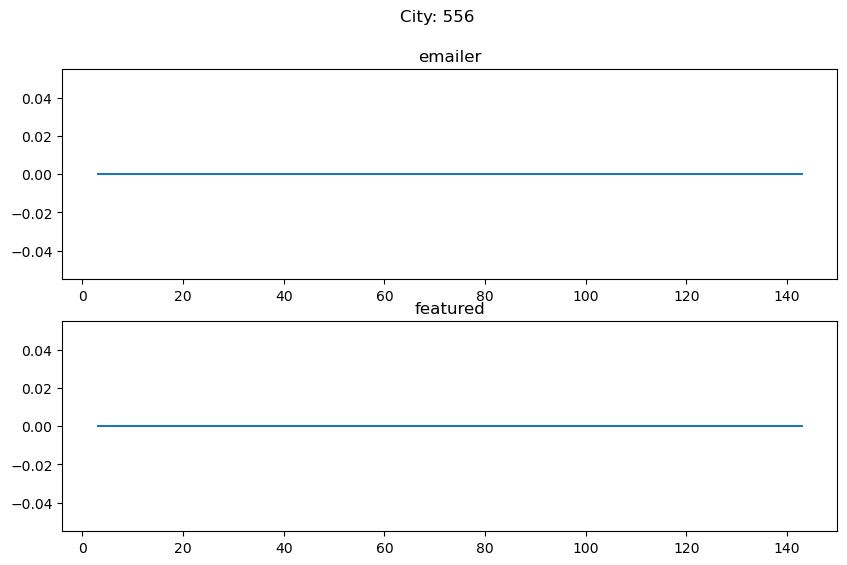

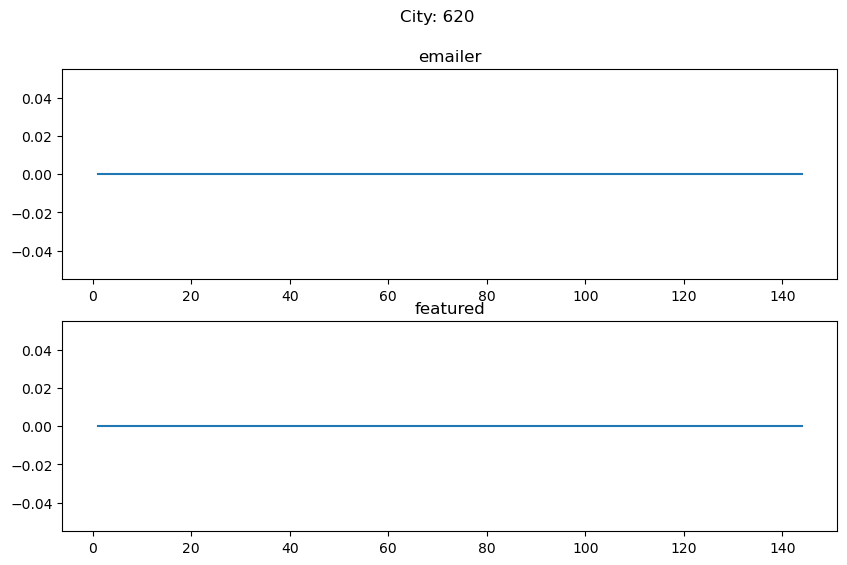

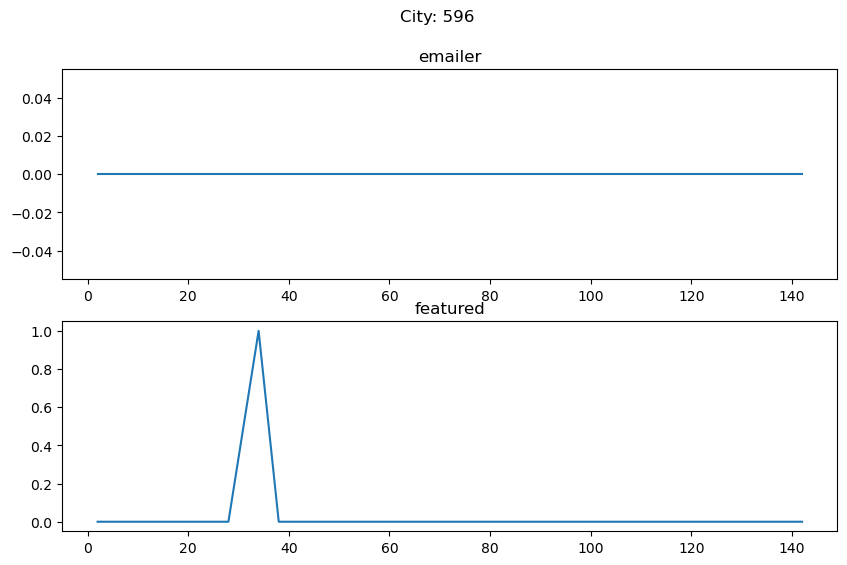

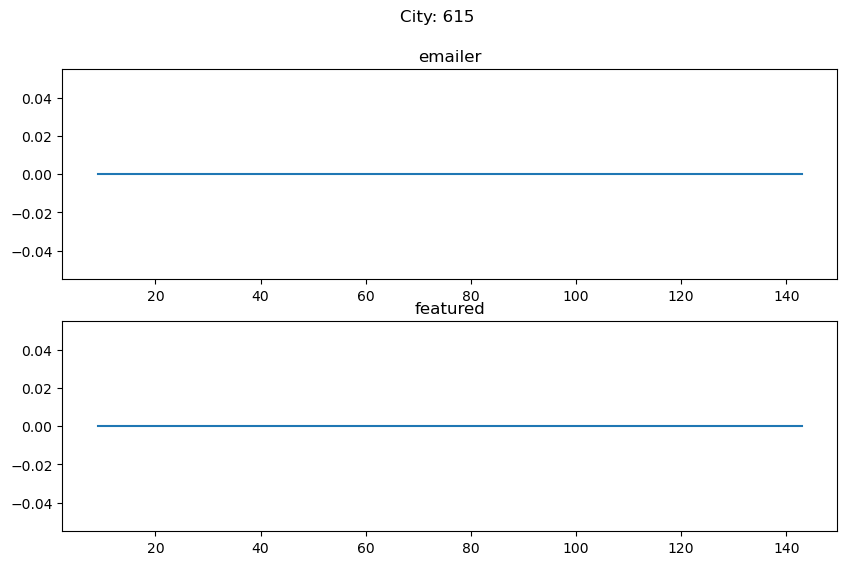

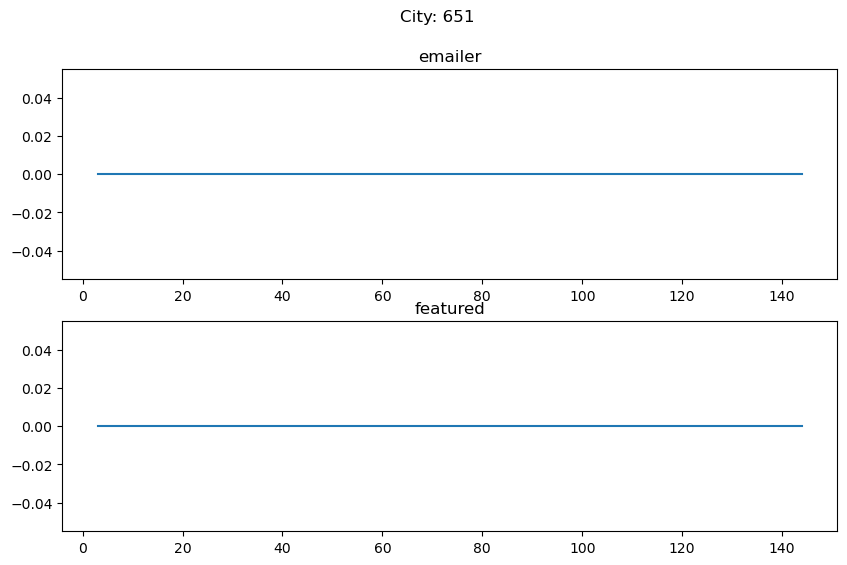

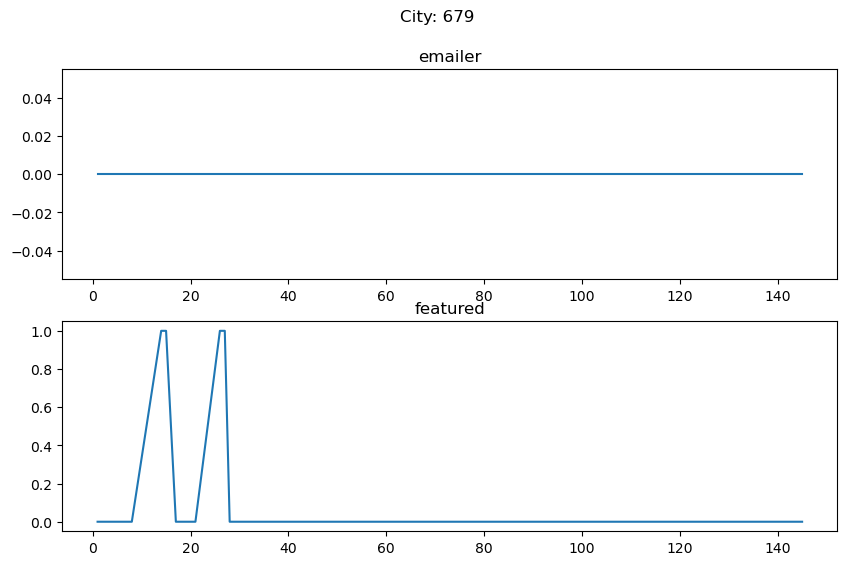

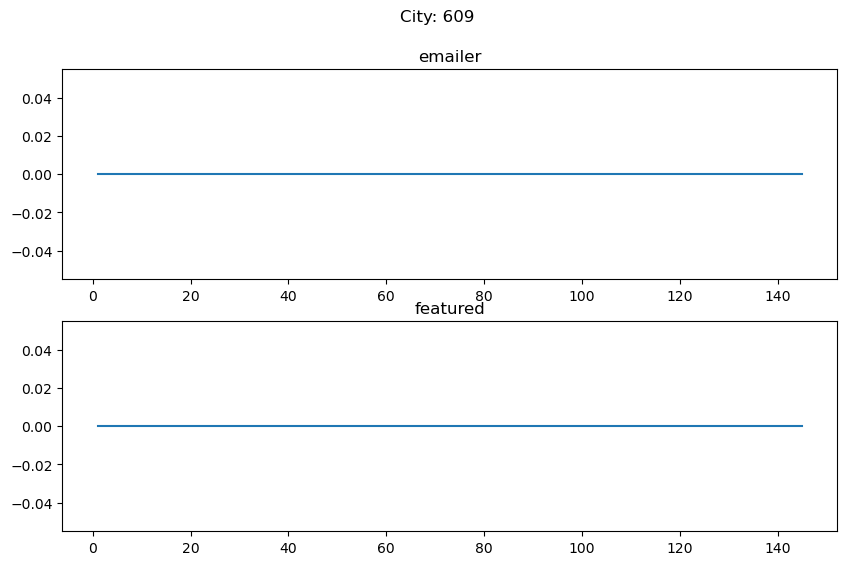

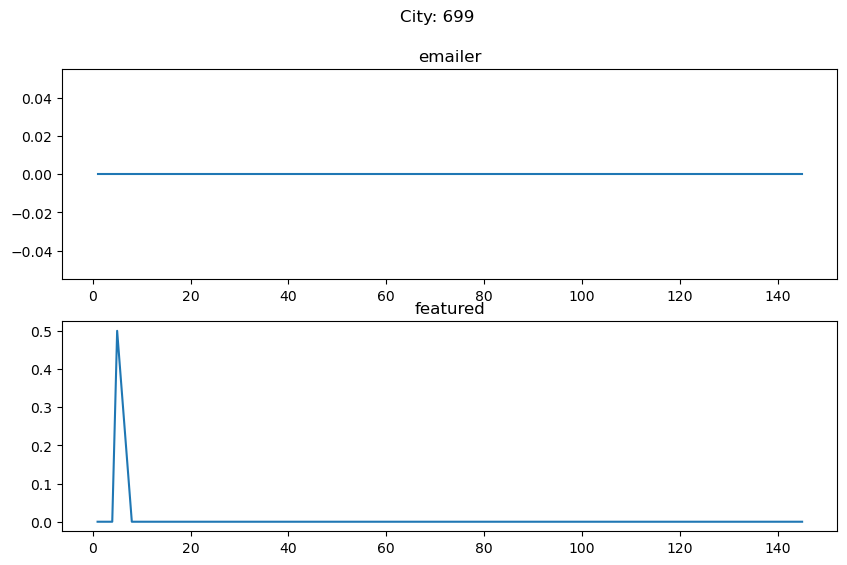

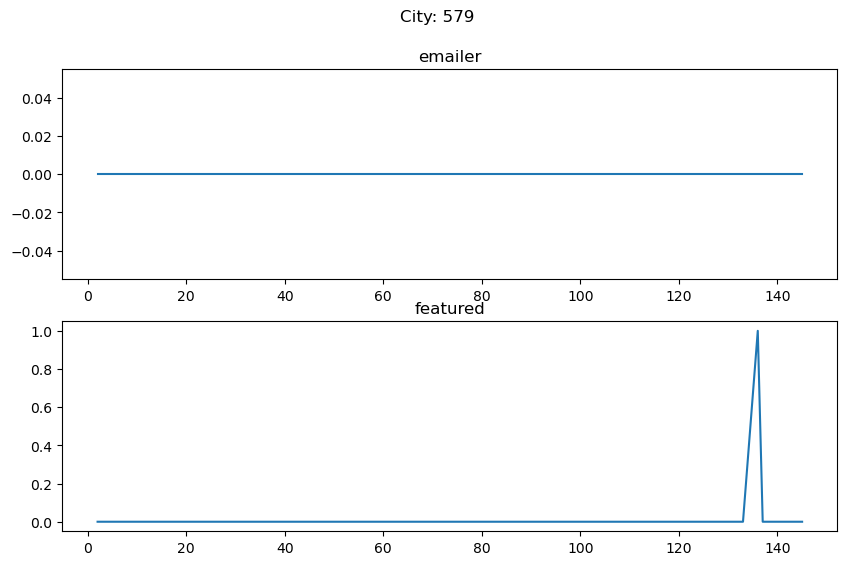

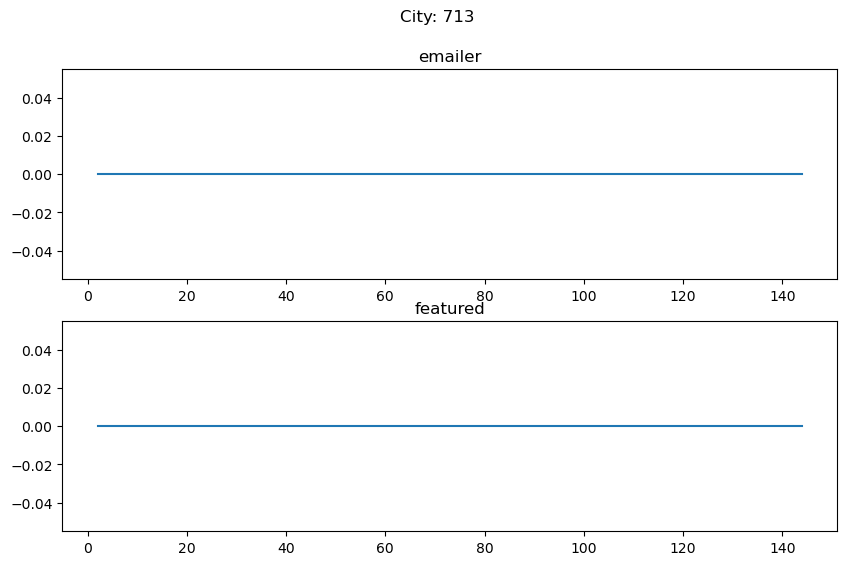

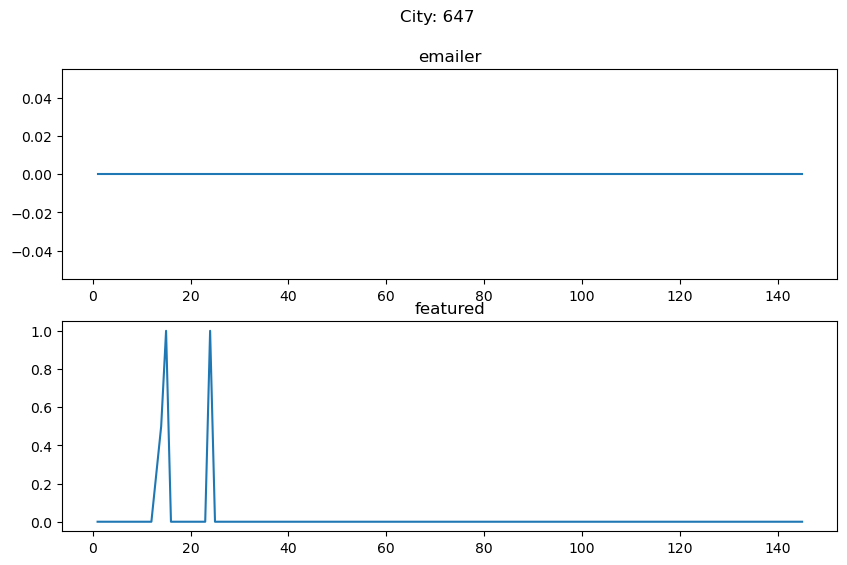

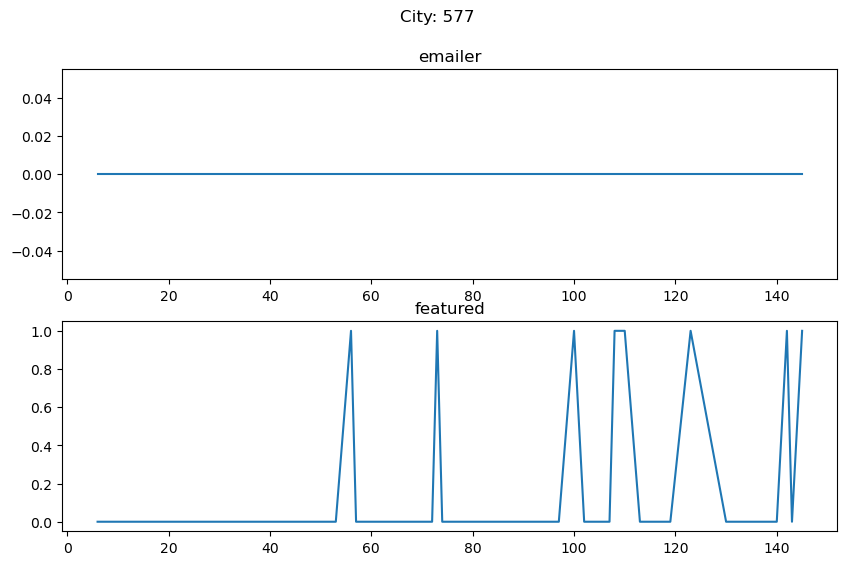

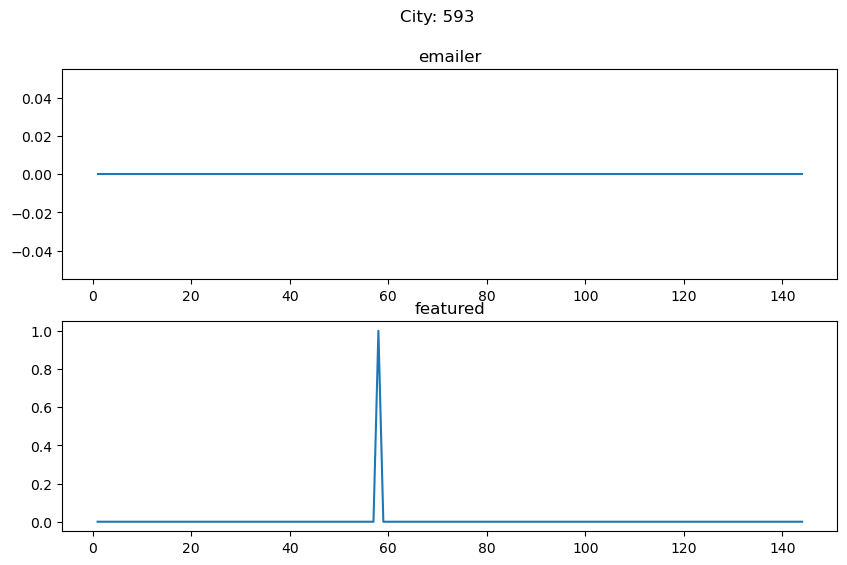

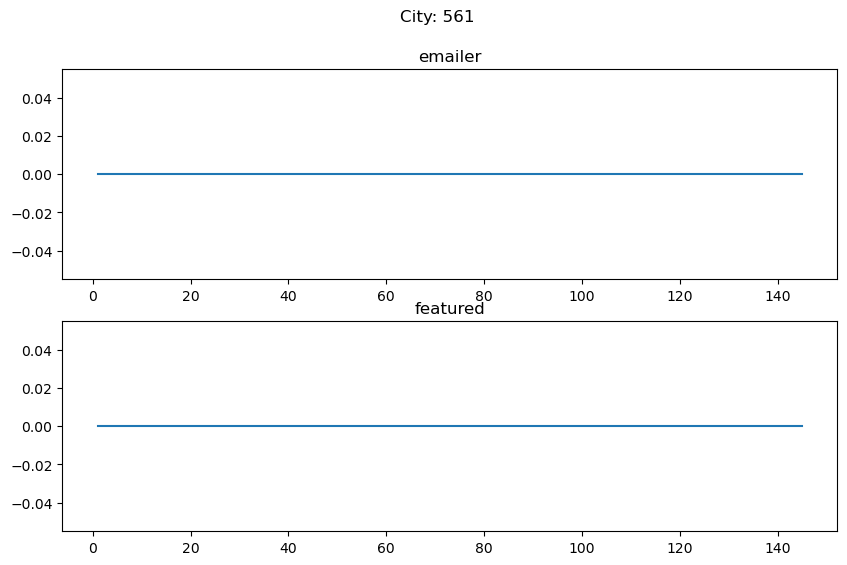

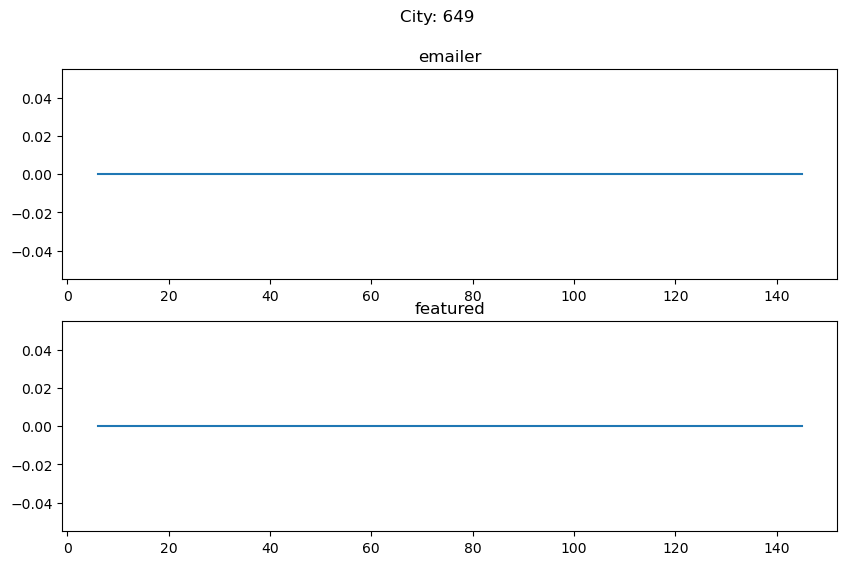

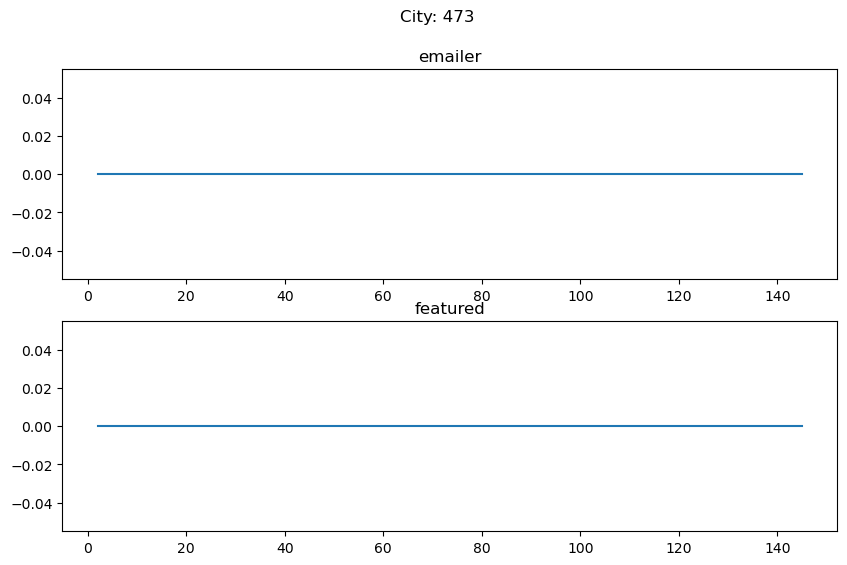

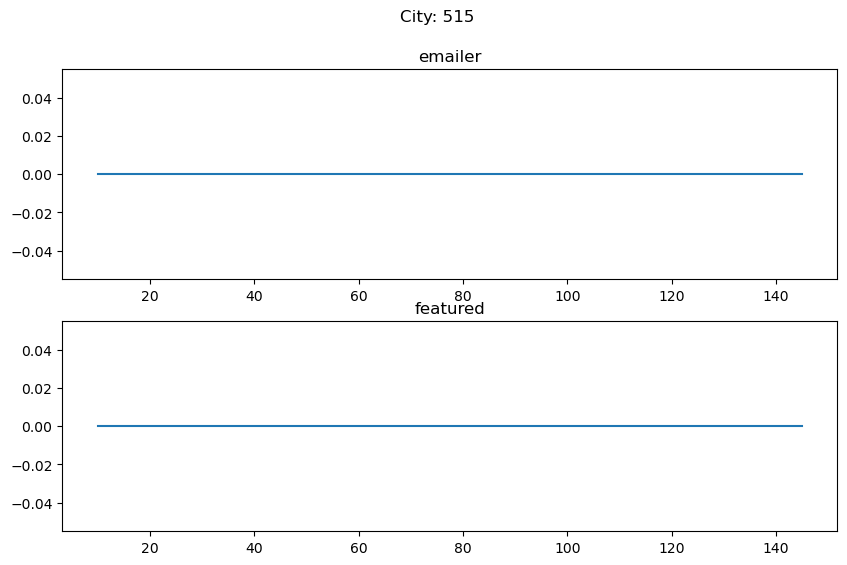

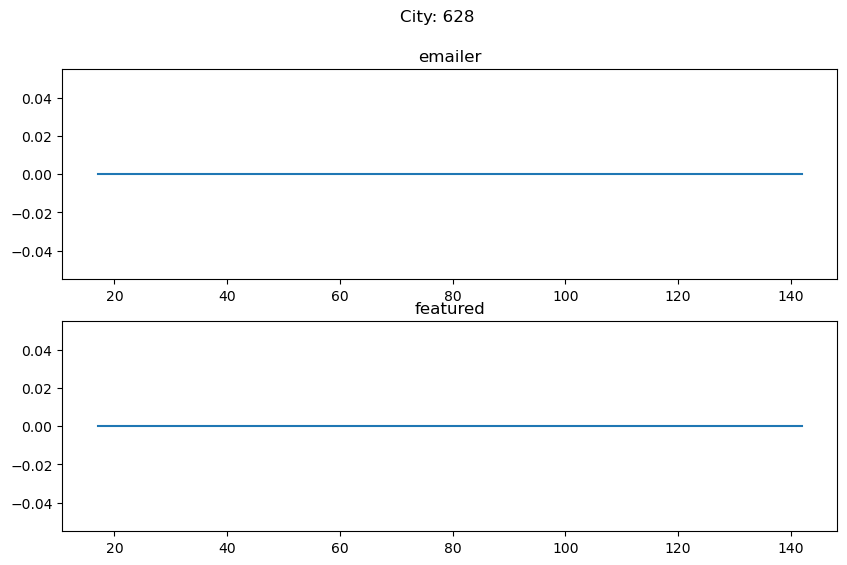

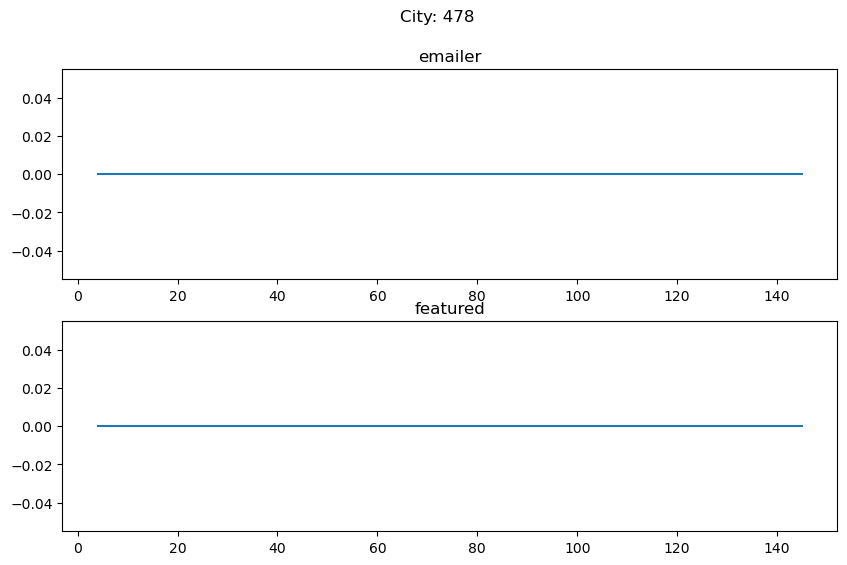

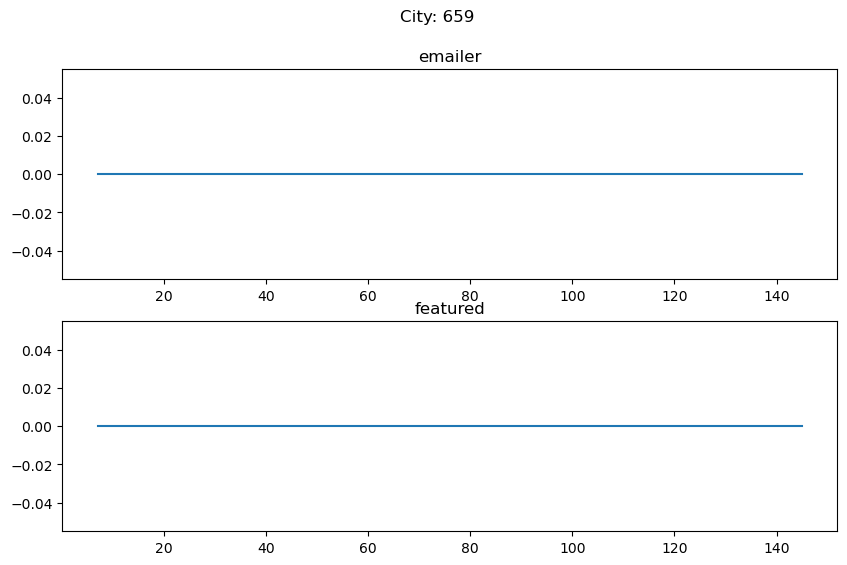

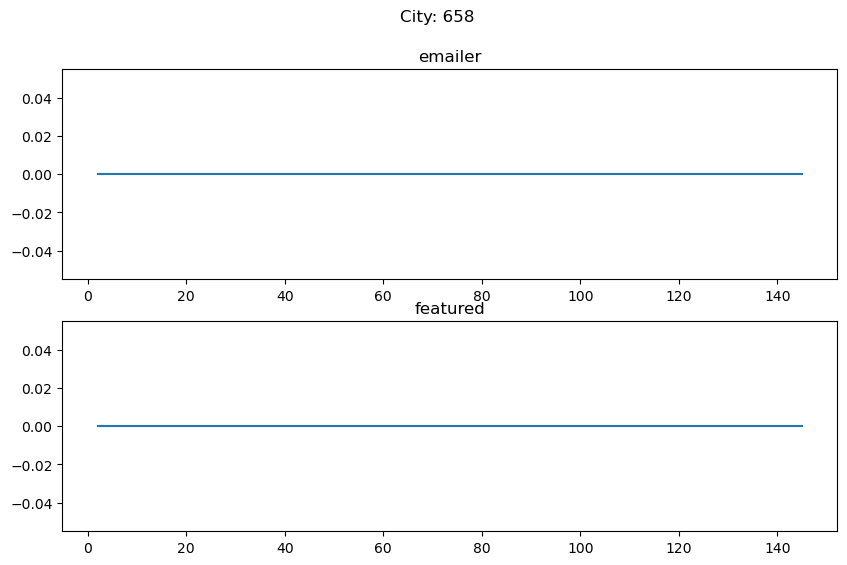

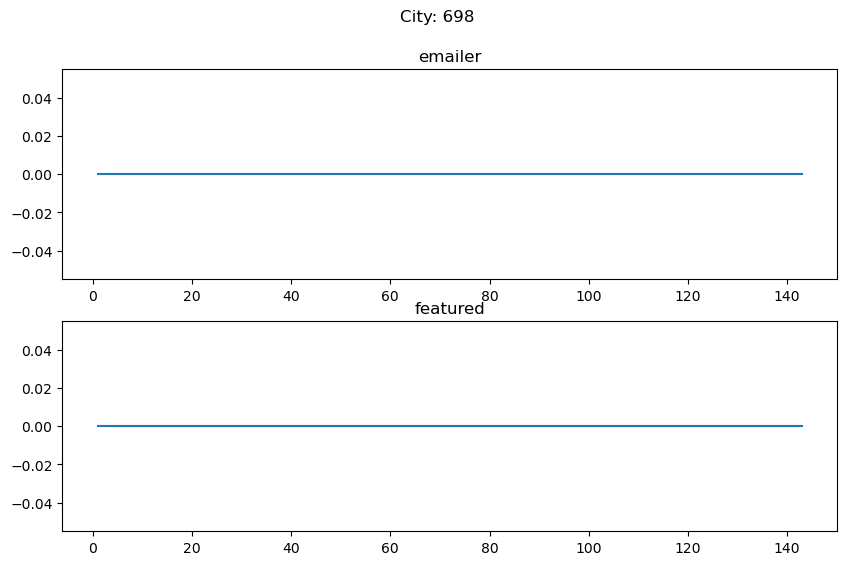

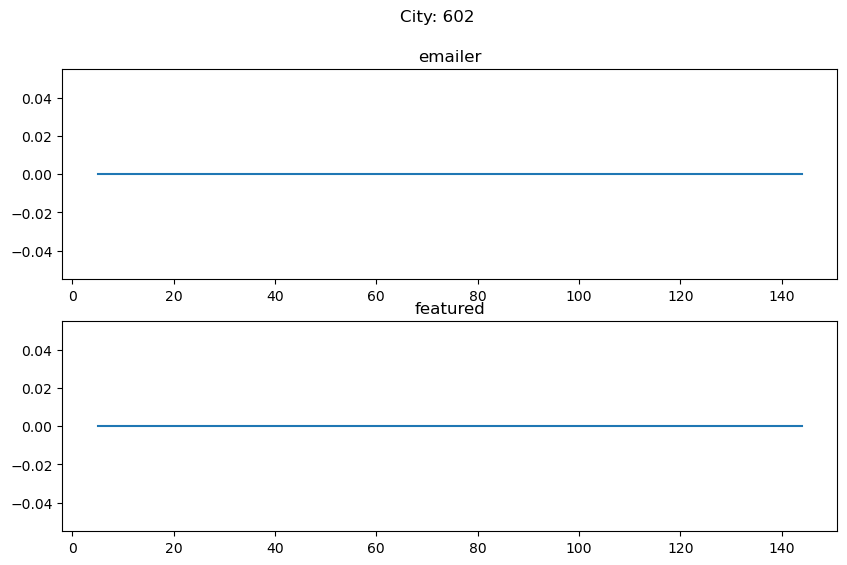

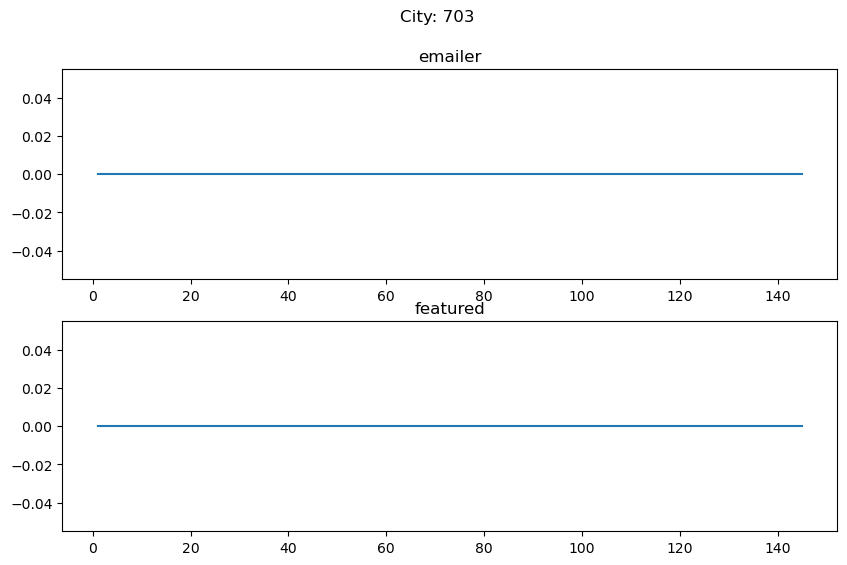

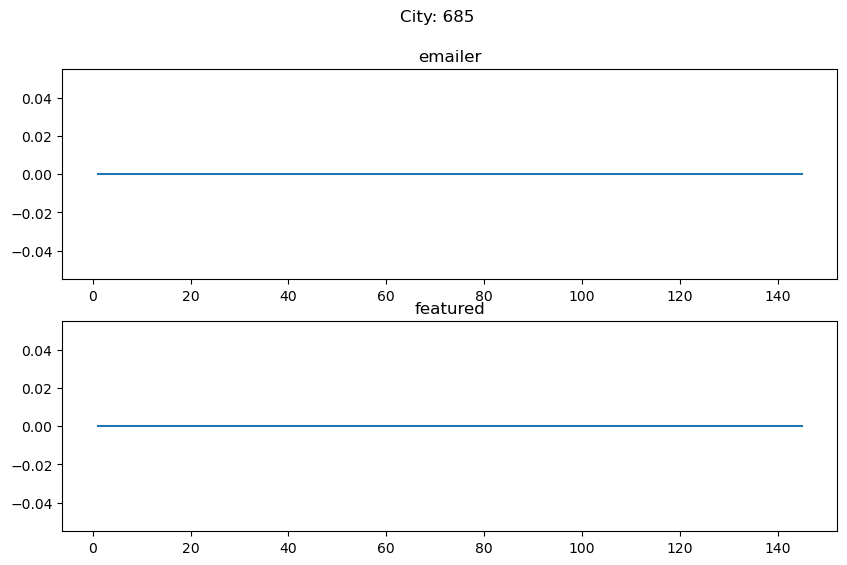

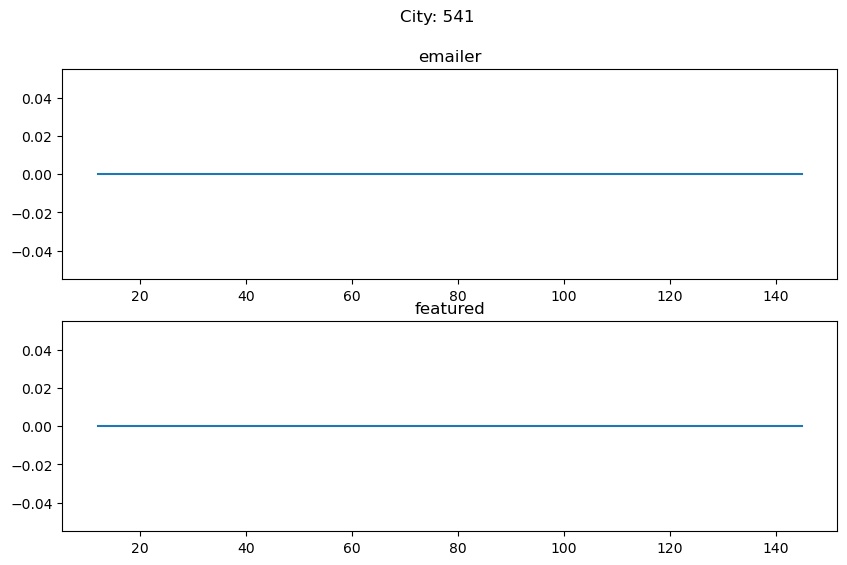

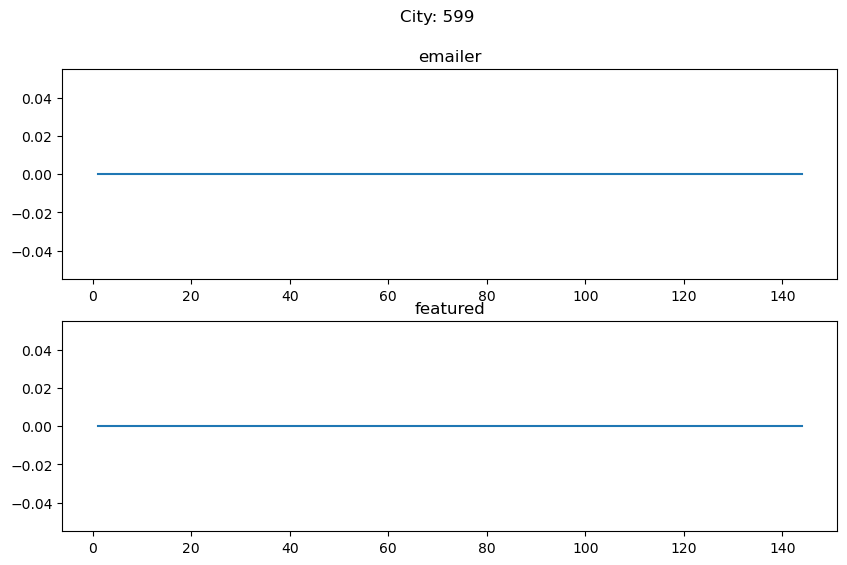

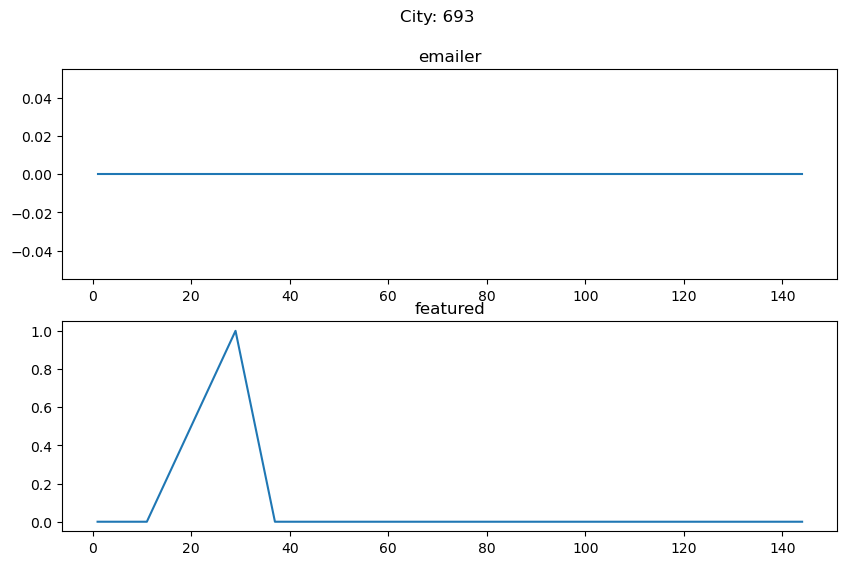

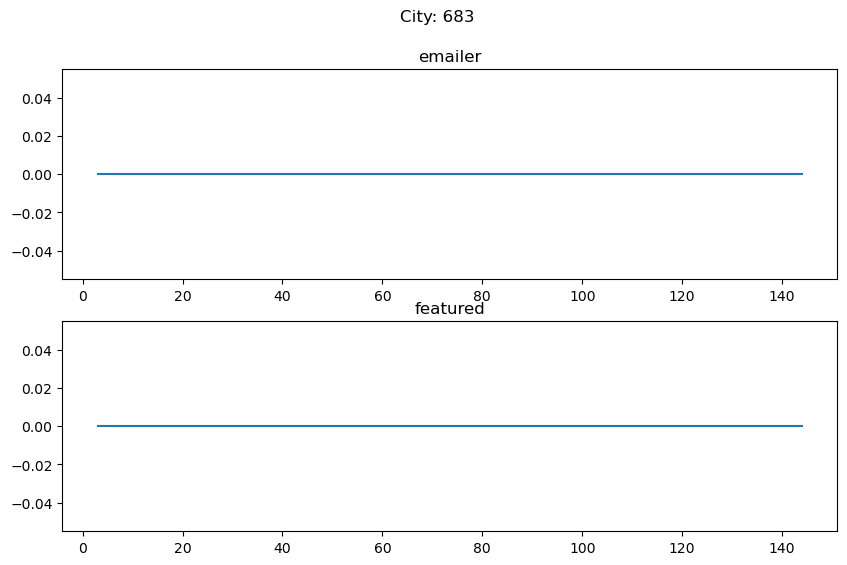

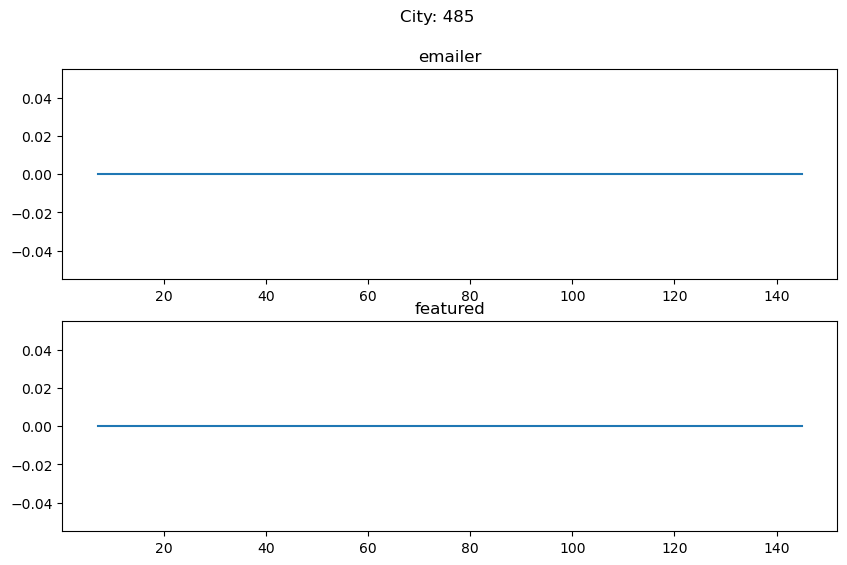

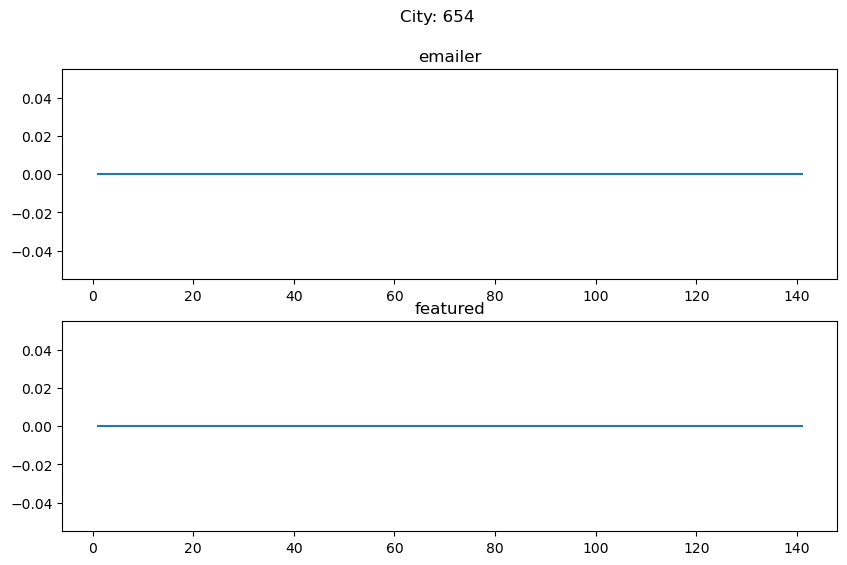

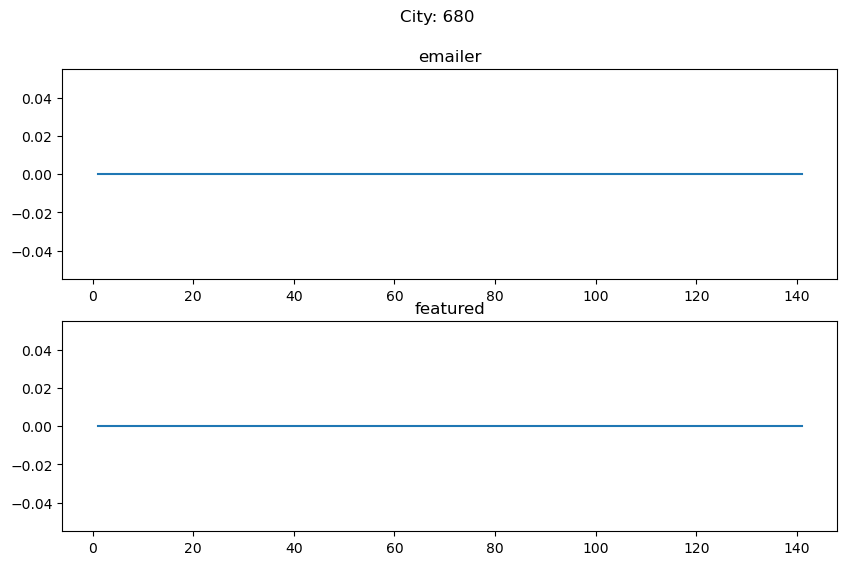

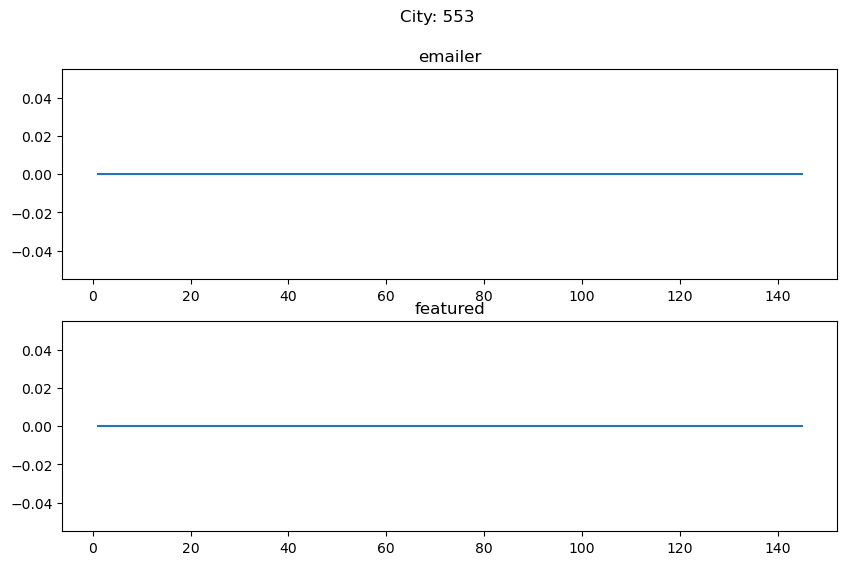

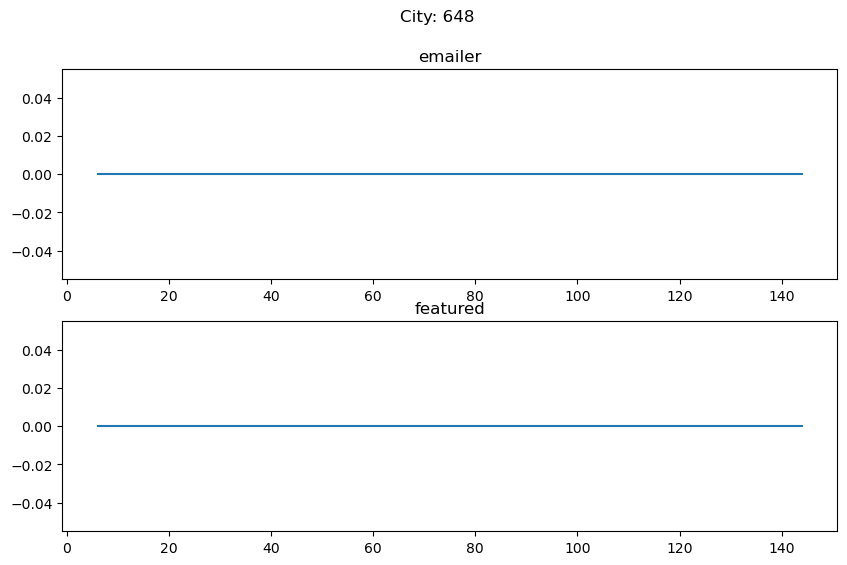

In [46]:
deliveries_meal_specified = deliveries[deliveries['meal_id']==2139]

for i in deliveries['city_code'].unique():
    city_specified = deliveries_meal_specified[deliveries_meal_specified['city_code']==i]
    weekly_city_specified =city_specified.groupby('week',as_index=False)\
                                                      .agg({'emailer':'mean', 'featured':'mean'})

    fig, ax = plt.subplots(figsize=(10,6), nrows = 2, ncols = 1)
    fig.suptitle(f'City: {i}')
    ax[0].plot(weekly_city_specified['week'], weekly_city_specified['emailer'])
    ax[0].set_title('emailer')
    ax[1].plot(weekly_city_specified['week'], weekly_city_specified['featured'])
    ax[1].set_title('featured')

    plt.show()

### First categorize promotion in one column. 1=emailer, 2=featured, 3=both, 0=none

In [47]:
deliveries.columns

Index(['id', 'week', 'center_id', 'city_code', 'region_code', 'center_type',
       'op_area', 'meal_id', 'category', 'cuisine', 'checkout_price',
       'base_price', 'emailer', 'featured', 'orders', 'sales', 'discount'],
      dtype='object')

In [48]:
print(deliveries['emailer'].unique())
print(deliveries['emailer'].dtype)

[0 1]
int64


In [49]:
print(deliveries['featured'].unique())
print(deliveries['featured'].dtype)

[0 1]
int64


In [50]:
promo_analysis_df = deliveries.copy()

email_only = (promo_analysis_df['emailer']==1)&(promo_analysis_df['featured']==0)
featured_only = (promo_analysis_df['emailer']==0)&(promo_analysis_df['featured']==1)
both_promo = (promo_analysis_df['emailer']==1)&(promo_analysis_df['featured']==1)
none_promo = (promo_analysis_df['emailer']==0)&(promo_analysis_df['featured']==0)

conditions = [email_only, featured_only, both_promo, none_promo]

promo_cat = [1, 2, 3, 0]

promo_analysis_df['promotion'] = np.select(conditions, promo_cat)

promo_analysis_df[['emailer','featured','promotion']].head()

emailer  featured  promotion
114136        0         0          0
96763         0         1          2
189605        0         0          0
96636         1         0          1
189711        0         1          2

In [51]:
promo_analysis_df.groupby('promotion')[['sales']].mean()

sales
promotion               
0           58019.712813
1          117350.751117
2           96402.681912
3          223669.898083

### Second, clean sales outliers for each meal_id in automated way

In [52]:
grouped_by_promo = promo_analysis_df.groupby(['meal_id', 'promotion'])[['sales']]

def detect_outliers_by_promo(df):
    Q1 = df['sales'].quantile(0.25)
    Q3 = df['sales'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df['sales'] < lower_bound) | (df['sales'] > upper_bound)]

# Detect outliers for each meal_id and promotion_type group
outliers_by_promo = grouped_by_promo.apply(detect_outliers_by_promo)

# Optionally, remove the outliers
def remove_outliers_by_promo(df):
    outliers = detect_outliers_by_promo(df)
    return df[~df.isin(outliers)]

cleaned_promo_analysis_df = grouped_by_promo.apply(remove_outliers_by_promo)

### Create a loop to do anova for each meal_id
The dictionary contains: 
1. Columns observed
2. Featured or emailer or both or none
3. Sample size for each group
4. Mean for each group
5. p-value

In [53]:
cleaned_promo_analysis_df.reset_index(inplace=True)

In [54]:
cleaned_promo_analysis_df=cleaned_promo_analysis_df[['meal_id','promotion','sales']]

In [55]:
cleaned_promo_analysis_df=cleaned_promo_analysis_df[cleaned_promo_analysis_df['sales'].notna()]

In [56]:
# Function to calculate the one-way ANOVA, Tukey HSD, and mean for each promotion group
def anova_per_meal(meal_data):
    # Group sales by promotion type
    group_0 = meal_data[meal_data['promotion'] == 0]['sales']
    group_1 = meal_data[meal_data['promotion'] == 1]['sales']
    group_2 = meal_data[meal_data['promotion'] == 2]['sales']
    group_3 = meal_data[meal_data['promotion'] == 3]['sales']
    
    # Check if each group has at least two non-identical data points
    groups = [group_0, group_1, group_2, group_3]
    valid_groups = [group for group in groups if len(group) > 1 and group.nunique() > 1]
    
    # Perform one-way ANOVA only if there are at least two valid groups
    if len(valid_groups) >= 2:
        f_stat, p_value = f_oneway(*valid_groups)
    else:
        p_value = float('NaN')  # Set NaN if ANOVA cannot be performed
    
    # Calculate means for each promotion group
    mean_0 = group_0.mean() if not group_0.empty else None
    mean_1 = group_1.mean() if not group_1.empty else None
    mean_2 = group_2.mean() if not group_2.empty else None
    mean_3 = group_3.mean() if not group_3.empty else None

    tukey_result = "Not significant"  # Default result if no Tukey test is done

    # Perform Tukey HSD test if p-value < 0.05
    if p_value < 0.05:
        # Combine sales and promotion columns for Tukey HSD test
        tukey_data = meal_data[['sales', 'promotion']].dropna()
        tukey_test = pairwise_tukeyhsd(endog=tukey_data['sales'],
                                       groups=tukey_data['promotion'],
                                       alpha=0.05)
        tukey_result = tukey_test.summary().as_html()
        try:
            tukey_result = pd.read_html(tukey_result, header=0, index_col=0)[0].reset_index()
            tukey_result = tukey_result[tukey_result['reject']==True][['group1', 'group2']].values.tolist()
        except:
            pass
            
    return pd.Series({
        'mean_none': mean_0,
        'mean_email': mean_1,
        'mean_featured': mean_2,
        'mean_both': mean_3,
        'p_value': p_value,
        'tukey_result': tukey_result
    })

# Apply the function for each meal_id
result_df = cleaned_promo_analysis_df.groupby('meal_id').apply(anova_per_meal).reset_index()

# Display the result
display(result_df)

meal_id      mean_none     mean_email  mean_featured      mean_both  \
0      1062   66254.363985   64542.727569  113827.938969  112487.809091   
1      1109  114819.846529  178412.896277  166594.561682  326844.886305   
2      1198   37660.537397            NaN   40887.571481            NaN   
3      1207   43520.860442   71470.243304  104595.164058  118954.597904   
4      1216   18359.318481   22755.908231   20792.025697   26505.874118   
5      1230   44343.820707   76284.204384  106068.978026  125300.133218   
6      1247   13315.560473            NaN   11895.996154            NaN   
7      1248    8640.275899   15316.647520   12825.520241   22802.622747   
8      1311   46845.163845            NaN   56244.872581            NaN   
9      1438   17385.807256            NaN   36935.657727            NaN   
10     1445   36093.698026   88984.788179   92198.347500  146230.993795   
11     1525   33675.082156   31269.629571   73473.087062   50943.227079   
12     1543   28253.280674   44510.034483   35701.238253   58743.580726   
13     1558   53469.500337   99618.318857  102914.215299  163226.908872   
14     1571   44238.276475   51709.388333  101459.747031   97684.187619   
15     1727  125940.375646  322787.514057  217757.117329  302120.339615   
16     1754  112974.498994  292979.340377  231060.878014  360236.763310   
17     1770   11605.462204            NaN   15684.831000            NaN   
18     1778   44309.918358   32874.732883  100641.835506   77388.022115   
19     1803   48014.293105            NaN   71977.575231            NaN   
20     1847   12730.221005            NaN   28425.291216            NaN   
21     1878   32982.073361   51364.353333   42832.213280   78407.836335   
22     1885   67722.027104   62509.297075  143846.908901  104208.039737   
23     1902   12020.745352            NaN   11644.046000            NaN   
24     1962  103518.437107  188556.465253  180588.864063  253905.381433   
25     1971   73698.115158  234999.322526  202028.966982  320663.245593   
26     1993   53694.940145   54303.186435  114381.733037  101884.264176   
27     2104   31123.815689   49885.142857   99311.321429   75420.807500   
28     2126   23403.396758   27931.335617   29557.813869   33785.869000   
29     2139   11433.245564            NaN   14336.172115            NaN   
30     2290  167297.135538  390697.306223  267088.989091  581656.609674   
31     2304   21722.611160   35662.495068   31830.928719   50967.222444   
32     2306   11462.513337   20750.824580   22100.762012   27017.751494   
33     2322   55174.362459   91456.367754  128176.740428  152481.090439   
34     2444   30528.202641   80769.555908   88555.166386  145093.069198   
35     2490   61906.963159  106283.134474  173512.159796  219498.261266   
36     2492   16820.226998   37271.653354   21890.593220   42476.452105   
37     2494   16319.921100            NaN   26767.355000            NaN   
38     2539   28272.388086   29343.555278   69596.235931   68141.305400   
39     2569   97036.733711  176644.166667  153328.749636  266293.703636   
40     2577   28543.994322   36883.222629   43005.820263   54690.135238   
41     2581   74727.109491  140308.078750  139925.497071  195701.885131   
42     2631   10913.287577   18963.556364   14747.771333   25019.088319   
43     2640   45561.876005   77422.907805   62390.303311   94069.839456   
44     2664  107907.400469  160755.551910  186454.774918  253361.171429   
45     2704   33930.197568   44315.455610   64841.617525   68975.763977   
46     2707   95859.336179  125322.183059  216096.354227  233437.988732   
47     2760   25499.656423            NaN   58811.712327            NaN   
48     2826  116150.091664  170867.533565  195992.843740  289677.831561   
49     2867   29932.160598   63687.809612   73871.991845  103836.282661   
50     2956   42234.623271   59906.916000   78841.144828  121725.255556   

          p_value                                      tukey_result  
0    2.825957e-58                

In [57]:
# manually input the best promo
result_df['best'] = [
    'featured', #1062
    'both', #1109
    'none', #1198
    'both', #1207
    'email', #1216
    'both', #1230
    'none', #1247
    'both', #1248
    'none', #1311
    'featured', #1438
    'both', #1445
    'featured', #1525
    'both', #1543
    'both', #1558
    'featured', #1571
    'email', #1727
    'both', #1754
    'featured', #1770
    'featured', #1778
    'featured', #1803
    'featured', #1847
    'both', #1878
    'featured', #1885
    'none', #1902
    'both', #1962
    'both', #1971
    'featured', #1993
    'featured', #2104
    'both', #2126
    'featured', #2139
    'both', #2290
    'both', #2304
    'both', #2306
    'both', #2322
    'both', #2444
    'both', #2490
    'both', #2492
    'featured', #2494
    'featured', #2539
    'both', #2569
    'both', #2577
    'both', #2581
    'both', #2631
    'both', #2640
    'both', #2664
    'featured', #2704
    'featured', #2707
    'featured', #2760
    'both', #2826
    'featured', #2867
    'both' #2956
]

# Function to save DataFrame as an image
def save_df_as_image(dataframe, path):
    fig, ax = plt.subplots(figsize=(len(dataframe.columns), len(dataframe)*0.5))  # Adjust size accordingly
    
    # Hide axes
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    ax.set_frame_on(False)
    
    # Render the table
    table = ax.table(cellText=dataframe.values, colLabels=dataframe.columns, cellLoc='center', loc='center')
    
    # Style the table (optional)
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)  # Adjust scaling for better readability

    # Save the table as a PNG image
    plt.savefig(path, bbox_inches='tight', dpi=300)
    plt.close()

# Save the sample DataFrame as a PNG image
save_df_as_image(result_df, "promo_analysis.png")

# Forecast future orders

Steps:
1. Problem Definition:
   Explore ways of forecasting food order numbers to assist purchasing managers in their planning. Create a function to predict meal order for each meal_id and city.
2. Exploratory Analysis
3. Choose and fit models
   a. Create train and test set
   b. Create naive prediction
   c. Fit linear regression model
4. Evaluate forecasting models

## Explore

In [58]:
deliveries.columns

Index(['id', 'week', 'center_id', 'city_code', 'region_code', 'center_type',
       'op_area', 'meal_id', 'category', 'cuisine', 'checkout_price',
       'base_price', 'emailer', 'featured', 'orders', 'sales', 'discount'],
      dtype='object')

In [59]:
# Weekly Average order per meal per city, is there average order less than 1
raw_forecast = deliveries.copy()

average_order_meal_city = raw_forecast.groupby(['city_code', 'meal_id'])[['orders']].mean()
average_order_meal_city['mean_under_1'] = np.where(average_order_meal_city['orders']<1, 1, 0)
(average_order_meal_city['mean_under_1']>0).any()

False

In [60]:
# Weekly minimum order per meal per city, is there minimum order less than 1
min_order_meal_city = raw_forecast.groupby(['city_code', 'meal_id'])[['orders']].min()
min_order_meal_city['min_under_1'] = np.where(min_order_meal_city['orders']<1, 1, 0)
(min_order_meal_city['min_under_1']>0).any()

False

In [61]:
# How many cities
city_count = deliveries['city_code'].nunique()
print(f"Cities: {city_count}")

# How many meal_id
meal_id_count = deliveries['meal_id'].nunique()
print(f"Meal: {meal_id_count}")

# How many permutation
print(f"{city_count*meal_id_count}")

Cities: 51
Meal: 51
2601


In [62]:
#how many weeks
deliveries['week'].nunique()

145

## Clean dataset for forecasting needs

1. Create dataset for each city and meal_id per week, add columns for emailer, featured and discount.
2. Train, test split
3. Create PACF to determine highly correlated and above confidence interval lags, then create the shifts
4. Do naive prediction and linear regression
5. Evaluate the MAE

In [63]:
# Create dataset for each city and meal_id per week, add columns for emailer, featured and discount.
forecast_data = raw_forecast[['week', 'meal_id', 'city_code', 'emailer', 'featured', 'discount', 'orders','sales']]\
                .groupby(['week', 'meal_id', 'city_code'],as_index=False)\
                .agg({'orders':'sum','emailer':'max', 'featured':'max', 'discount':'min'})
forecast_data.head()

week  meal_id  city_code  orders  emailer  featured  discount
0     1     1062        473     231        0         0 -1.164483
1     1     1062        478     365        0         0  0.632351
2     1     1062        485     460        0         0 -0.592382
3     1     1062        517     270        0         0  1.096732
4     1     1062        526    1407        0         0 -0.551116

In [64]:
weeks_series = pd.DataFrame({'week': [i for i in range(1, 146, 1)]})
meal_id_series = pd.DataFrame({'meal_id':forecast_data['meal_id'].unique()})
city_code_series = pd.DataFrame({'city_code':forecast_data['city_code'].unique()})

base_wm = pd.merge(weeks_series, meal_id_series, how='cross')
base_wmc = pd.merge(base_wm, city_code_series, how='cross')

forecast_data_new = base_wmc.merge(forecast_data, on=['week', 'meal_id', 'city_code'], how='left').fillna(0)
forecast_data_new.head()

week  meal_id  city_code  orders  emailer  featured  discount
0     1     1062        473   231.0      0.0       0.0 -1.164483
1     1     1062        478   365.0      0.0       0.0  0.632351
2     1     1062        485   460.0      0.0       0.0 -0.592382
3     1     1062        517   270.0      0.0       0.0  1.096732
4     1     1062        526  1407.0      0.0       0.0 -0.551116

In [65]:
# Step 1: Define function to create lag features
def create_lag_features(data, lags):
    if lags is None:
        return data
    for lag in lags:
        data[f'lag_{lag}'] = data['orders'].shift(lag)
    return data

# Step 2: Naive forecast function
def ma3(data): 
    data['ma3'] = data['orders'].rolling(3).mean().shift(1)
    data['ma3'] = data['ma3'].fillna(0)
    return data

# Step 3: Forecast function with visualization and LightGBM
def forecast_meal(train_df, forecast_df, plot=True):
    """
    Function to forecast inputted dataframe using linear regression, LightGBM and naive prediction, with comparison plots.
    
    Parameters:
        train_df(pandas.core.frame.DataFrame): Training data with required columns (see docstring).
        forecast_df(pandas.core.frame.DataFrame): Current data to forecast with required columns (see docstring).
        plot(bool, default: True): If True, generate comparison line plots.
    
    Returns:
        result_df(pandas.core.frame.DataFrame): Results including forecasted and actual orders, along with MAE.
    """
    # Test parameter input if None
    if train_df is None:
        print('No train_df')
        return

    if forecast_df is None:
        print('No forecast data')
        return
        
    # Test required column
    train_req_col = ['week','meal_id','city_code', 'emailer', 'featured', 'discount', 'orders']
    forecast_req_col = ['meal_id', 'city_code', 'emailer', 'featured', 'discount']

    if not all(col in train_df.columns for col in train_req_col):
        print("Wrong input! Please read the docstring!")
        return

    if not all(col in forecast_df.columns for col in forecast_req_col):
        print("Wrong input! Please read the docstring!")
        return

    # Try to convert column content into numeric
    try:
        train_df = train_df[train_req_col].apply(pd.to_numeric)
        forecast_df = forecast_df[forecast_req_col].apply(pd.to_numeric)
    except:
        print("Data can't be converted into number! Read the docstring!")
        return

    # Check if same meal_id and city_code combination exists in both df
    check_df = train_df[['meal_id', 'city_code']].drop_duplicates(subset=['meal_id', 'city_code'])
    if not all(id_list in check_df[['meal_id', 'city_code']].values for id_list in forecast_df[['meal_id', 'city_code']].values):
        print("Missing some combination of meal_id and city_code! Check the docstring!")
        return

    # The machine learning part
    results = []
    test_size = 0.2

    # Loop through each meal_id and city combination
    for meal_id, city in forecast_df[['meal_id', 'city_code']].values:
        select_meal = train_df['meal_id'] == meal_id
        select_city = train_df['city_code'] == city
        group = train_df[select_meal & select_city]
        group = group.sort_values('week').reset_index(drop=True)
    
        # Step 4: Create lag features based on PACF with confidence interval
        pacf_values, confint = pacf(group['orders'], nlags=52, alpha=0.05)
        lower_conf = confint[:, 0]
        upper_conf = confint[:, 1]
        best_lags = [lag for lag, val in enumerate(pacf_values) if val < lower_conf[lag] or val > upper_conf[lag]]
    
        group = create_lag_features(group, best_lags)
        group = group.dropna()
    
        # Train-test split
        train_size = int(len(group) * (1 - test_size))
        train, test = group[:train_size], group[train_size:]
    
        # Naive forecast
        test = ma3(group)[train_size:]
    
        # Train linear regression
        X_train = train.drop(columns=['orders', 'meal_id', 'city_code'])
        y_train = train['orders']
        X_test = test.drop(columns=['orders', 'ma3', 'meal_id', 'city_code'])
        y_test = test['orders']
    
        # Linear Regression
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        test['lr_forecast'] = lr_model.predict(X_test)
    
        # LightGBM with Random Search
        lgb_model = lgb.LGBMRegressor(random_state=42, verbosity=-1)
        param_dist = {
            'num_leaves': [31, 50, 70],
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 7, 10],
        }
        random_search = RandomizedSearchCV(lgb_model, param_distributions=param_dist, n_iter=10, 
                                           cv=3, random_state=42, scoring='neg_mean_absolute_error')
        random_search.fit(X_train, y_train)
        test['lgb_forecast'] = random_search.predict(X_test)
    
        # MAE calculation
        naive_mae = mean_absolute_error(test['orders'], test['ma3'])
        lr_mae = mean_absolute_error(test['orders'], test['lr_forecast'])
        lgb_mae = mean_absolute_error(test['orders'], test['lgb_forecast'])
    
        # Step 9: Predict on real data (forecast_df)
        subset_forecast = forecast_df[(forecast_df['meal_id'] == meal_id) & (forecast_df['city_code'] == city)]
        subset_forecast['week'] = train_df['week'].max() + 1
    
        for lag in best_lags:
            if lag is None:
                break
            subset_forecast[f'lag_{lag}'] = subset_forecast.apply(
                lambda row: train_df[(train_df['meal_id'] == row['meal_id']) & 
                                     (train_df['city_code'] == row['city_code']) & 
                                     (train_df['week'] == (row['week'] - lag))]['orders'].values[0]
                if len(train_df[(train_df['meal_id'] == row['meal_id']) & 
                                (train_df['city_code'] == row['city_code']) & 
                                (train_df['week'] == (row['week'] - lag))]['orders']) > 0
                else 0, axis=1
            )
    
        subset_forecast = subset_forecast.dropna()
        X_forecast = subset_forecast[X_train.columns]

        pred_lr = lr_model.predict(X_forecast)[0]
        pred_naive = group[group['week'] == group['week'].max()]['orders'].values[0]
        pred_lgb = random_search.predict(X_forecast)[0]

        results.append({
            'meal_id': meal_id,
            'city': city,
            'emailer': subset_forecast['emailer'].values[0],
            'featured': subset_forecast['featured'].values[0],
            'discount': subset_forecast['discount'].values[0],
            'pred_naive': pred_naive,
            'pred_lr': pred_lr,
            'pred_lgb': pred_lgb,
            'naive_mae': naive_mae,
            'lr_mae': lr_mae,
            'lgb_mae': lgb_mae
        })

        # Step 10: Plot comparison if requested
        if plot:
            plt.figure(figsize=(10, 6))
            sns.lineplot(x=test['week'], y=test['orders'], label='Test Orders', marker='o')
            sns.lineplot(x=test['week'], y=test['ma3'], label='Moving Average 3', marker='o')
            sns.lineplot(x=test['week'], y=test['lr_forecast'], label='LR Forecast', marker='o')
            sns.lineplot(x=test['week'], y=test['lgb_forecast'], label='LGBM Forecast', marker='o')

            # Add annotations for discount, emailer, and featured
            for i in range(len(test)):
                week = test['week'].iloc[i]
                discount = test['discount'].iloc[i].round(2)
                emailer = test['emailer'].iloc[i]
                featured = test['featured'].iloc[i]
                
                # Annotation text (discount, emailer, featured)
                annotation = f"{discount}\n, {emailer}\n, {featured}"
                
                # Place the annotation above the corresponding 'orders' value
                plt.text(week, test['orders'].iloc[i] + 0.05, annotation, 
                         horizontalalignment='center', fontsize=6, color='black')

            plt.title(f'Forecast Comparison for Meal ID: {meal_id} and City: {city}')
            plt.xlabel('Week')
            plt.ylabel('Orders')
            plt.legend()
            plt.show()


    return pd.DataFrame(results)

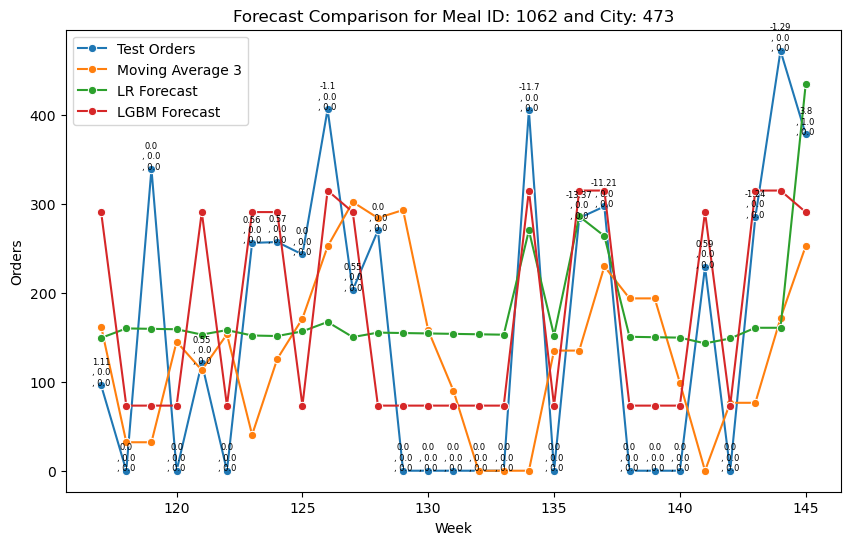

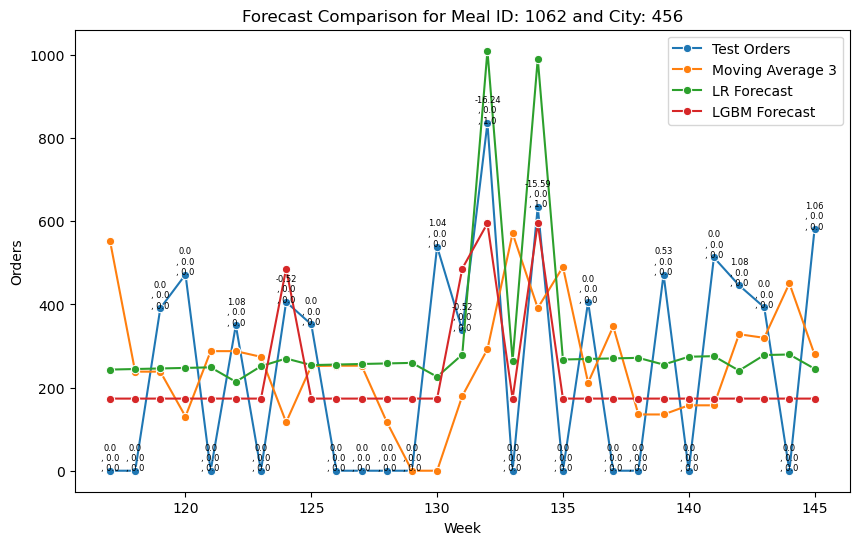

meal_id  city  emailer  featured  discount  pred_naive     pred_lr  \
0     1062   473        1         1      -0.3       378.0  474.789401   
1     1062   456        1         1      -0.3       581.0  702.707104   

     pred_lgb   naive_mae      lr_mae     lgb_mae  
0  113.001868  142.103448  127.986662   92.067435  
1  486.362725  273.689655  225.318894  204.995413

In [66]:
# Create forecast with real data
forecast_real = pd.DataFrame({
    'meal_id':[1062, 1062],
    'city_code':[473, 456],
    'emailer':[1, 1],
    'featured':[1, 1],
    'discount':[-0.3, -0.3]
})

# Step 11: Call the function and pass your dataframe
result_df = forecast_meal(forecast_data_new, forecast_real)

# Step 12: View results
display(result_df)